# Relaxed Solver for Dynamic Unbalanced Optimal Transport

In this notebook, we check the behavior of `dynamic_wfr_relaxed_grid` function which solves the unbalanced dynamic OT problem on a rectangular grid.

In [1]:
# Import relevant libraries
import sys
import torch
sys.path.append('../relaxed')
from dynamic_wfr_relaxed import wfr_grid, wfr_grid_scipy, wfr_grid_scipy_tunerel, _WFR_energy, _div_plus_pz_grid, _batch_project_affine, _calculate_derivatives
import numpy as np
import matplotlib.pyplot as plt

def plot_pvz_1D(p: torch.Tensor,
                v: torch.Tensor = None,
                z :torch.Tensor = None,
                dx: list = None,
                p2: torch.Tensor = None):
    """Plots the change of p, v and z over time on 1D. \
        We plot the graph assuming that the i,j element represents the value at\
        t=i/T, x=j*dx.
    
    p (torch.Tensor of shape (T + 1, N)) : The mass density.

    v (torch.Tensor of shape (T, N, 1)) : The velocity field.

    z (torch.Tensor of shape (T, N)) : The source field.

    dx (list of a single float) : The list containing the space step. \
    If None, we assume that dx = [1/N].

    p2 (torch.Tensor) : The terminal density. If given, we plot the terminal \
    density at each time.

    """
    time_steps = p.shape[0]
    space_steps = p.shape[-1]
    if dx is None:
        dx = [1.0/space_steps]

    xs = np.arange(0, space_steps*dx[0], dx[0])
    
    X, Y = np.meshgrid(xs, np.zeros_like(xs))

    for time_step in range(time_steps):
        plt.figure(figsize=(10, 6))
        plt.plot(xs, p[time_step], label = 'Density')
        if p2 is not None and time_step == time_steps-1:
            plt.plot(xs, p2, color='r', label = 'Terminal Dist')
        
        if time_step < time_steps-1:
            if v is not None:
                U = np.tile(v[time_step].squeeze(), (1, space_steps))
                V = np.zeros_like(X)
                plt.quiver(X, Y, U/np.sqrt(U**2), V, cmap='jet')
            if z is not None:
                plt.plot(xs, z[time_step], color='c', label = 'Source')

        plt.title(f't={time_step/(time_steps-1)}')
        plt.legend()
        plt.show()

def plot_p_1D_same(p: torch.Tensor,
                dx: list = None,
                p2: torch.Tensor = None):
    """Plots the change of p over time on 1D. \
        We plot the graph assuming that the i,j element represents the value at\
        t=i/T, x=j*dx.
    
    p (torch.Tensor of shape (T + 1, N)) : The mass density.

    v (torch.Tensor of shape (T, N, 1)) : The velocity field.

    z (torch.Tensor of shape (T, N)) : The source field.

    dx (list of a single float) : The list containing the space step. \
    If None, we assume that dx = [1/N].

    p2 (torch.Tensor) : The terminal density. If given, we plot the terminal \
    density at each time.

    """
    time_steps = p.shape[0]
    space_steps = p.shape[-1]
    if dx is None:
        dx = [1.0/space_steps]

    xs = np.arange(0, space_steps*dx[0], dx[0])

    plt.figure(figsize=(10, 6))
    plt.title(f'Density at each time')
    for time_step in range(time_steps):
        plt.plot(xs, p[time_step], label = f't={time_step/(time_steps-1)}')
        if p2 is not None and time_step == time_steps-1:
            plt.plot(xs, p2, color='r', label = 'Terminal Dist')
        plt.legend()
    plt.show()

from scipy.special import i0
def von_mises_pdf(x, mu, k):
    return np.exp(k*np.cos(x-mu))/(2*np.pi*i0(k))

## Example 1: Scaling of the uniform distribution

Expected solution:
$\begin{align} \textrm{WFR}_1 &= \sqrt{2} \tag*{} \\ \rho &= (t+1)^2 \rho_0 \otimes dt \tag*{} \end{align}$


We first calculate the solution using SGD.

WFR distance: tensor(1.3125)


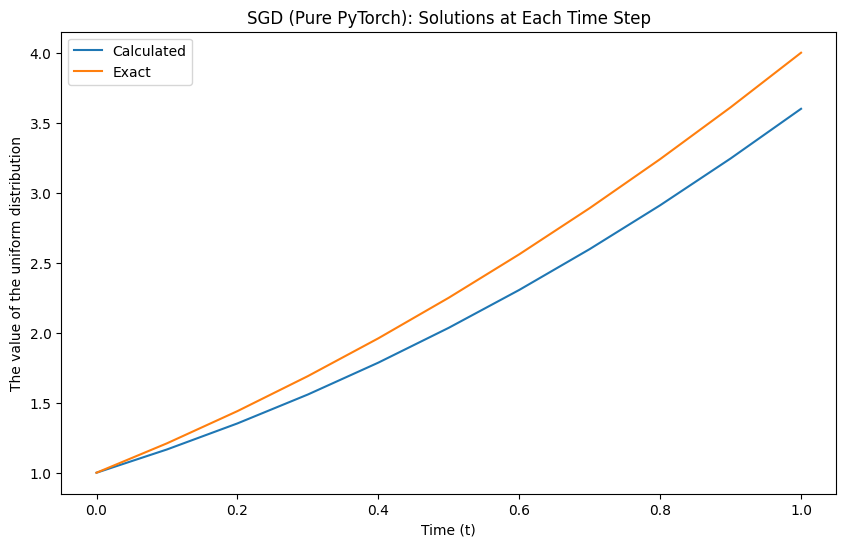

In [12]:
T = 10
N = 10
p1 = torch.ones(N)
p2 = 4*p1

wfr, p, v, z = wfr_grid(p1, p2, delta=1, rel=70, T=T, lr=1e-3)

print('WFR distance:', wfr)

# Convert the tensor to a NumPy array
data = p.numpy()

# Create the spatial grid
t = np.linspace(0, 1, T+1)  # Spatial points

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(t, p[:, 0], label = 'Calculated')
plt.plot(t, (t+1)**2, label = 'Exact')

plt.xlabel('Time (t)')
plt.ylabel('The value of the uniform distribution')
plt.title('SGD (Pure PyTorch): Solutions at Each Time Step')
plt.legend()
plt.show()

We note that there are `rel`s that gives the better results than the above. We use the same `rel` as below for comparison.

We now do the same using the scipy LBFGS. 

WFR distance: 1.4647174723824161


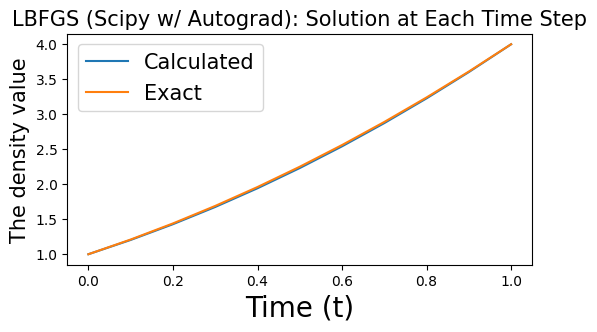

In [6]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

wfr, p, v, z = wfr_grid_scipy(p1,
                            p2, 
                            delta=1, 
                            rel=70, 
                            T=T)

print('WFR distance:', wfr)


# Create the spatial grid
t = np.linspace(0, 1, T+1)  # Spatial points

# Plotting
plt.figure(figsize=(6, 3))

plt.plot(t, p[:, 0], label = 'Calculated')
plt.plot(t, (t+1)**2, label = 'Exact')


plt.xlabel('Time (t)', fontsize = '20')
plt.ylabel('The density value', fontsize = '15')
plt.title('LBFGS (Scipy w/ Autograd): Solution at Each Time Step', fontsize = '15')
plt.legend(fontsize='15')
plt.show()

In [5]:
print(max(np.abs(p[:, 0]-(t+1)**2)))

0.01888371846688175


We will now investigate how we can tune the `rel` parameter. We gradually increase the `rel` parameter from 1 to 100 and see how the error between the exact solution changes.

91


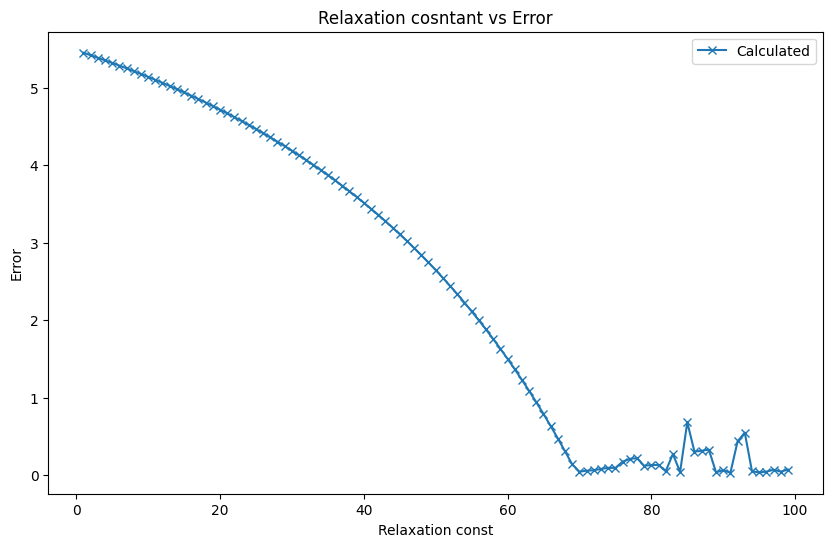

In [4]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

rels = np.arange(1,100, 1)
error = []

t = np.linspace(0, 1, T+1)
exact = (t+1)**2

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T)
    error.append(np.linalg.norm(p[:, 0]-exact))

min_ind = np.argmin(error)
print(rels[min_ind])

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, error, label = 'Calculated')

plt.xlabel('Relaxation const')
plt.ylabel('Error')
plt.title('Relaxation cosntant vs Error')
plt.legend()
plt.show()

We note that the error monotonically decreases until it reaches the plateau, and then it oscilates. We will now see if we can observe the same phenomenon without using the exact solution. We plot the calculated WFR distance against the relaxation parameter.

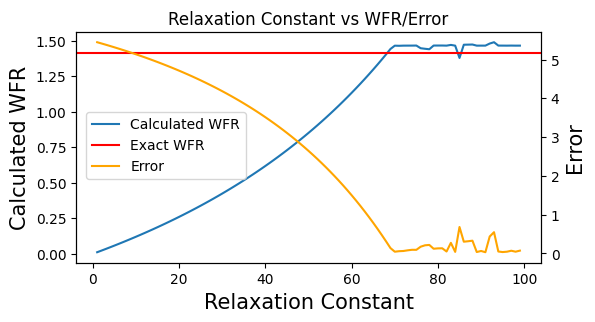

In [5]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

rels = np.arange(1,100,1)
wfrs = []
errors = []

t = np.linspace(0, 1, T+1)
exact = (t+1)**2

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T)
    wfrs.append(float(wfr))
    errors.append(np.linalg.norm(p[:, 0]-exact))

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(rels, wfrs, label='Calculated WFR')
ax1.axhline(y=np.sqrt(2), color='r', linestyle='-', label = 'Exact WFR')
ax1.set_xlabel('Relaxation Constant', fontsize = '15')
ax1.set_ylabel('Calculated WFR', fontsize = '15')
ax1.set_title('Relaxation Constant vs WFR/Error')
ax2 = ax1.twinx()
ax2.plot(rels, errors, color = 'orange', label = 'Error')
ax2.set_ylabel('Error', fontsize = '15')
fig.legend(loc ='center left', bbox_to_anchor = (0.13,0.5))
plt.show()

We observe the same phenomenon with a quantity that does not require the outside knowledge. We can establish the tuning strategy from this. Namely, we increase the parameter until the calculated WFR stops increasing.

## Example 2: Translation of von-Mises distribution

The von-Mises distribution is a continuous distribution on $[0,2\pi]$ defined by the pdf

$\begin{equation} f(x|\mu,\kappa) = \frac{\exp(\kappa \cos(x-\mu))}{2\pi I_0(\kappa)}\end{equation}\tag*{}$

where $I_0(\kappa)$ is the modifed Bessel function of the first kind of order 0. This is often referred to as the normal distribution on a circle.

We first check if the WFR plateau also appears in this case. We plot the WFR distance calculated by the Sinkhorn algorithm.

In [5]:
from scipy.special import i0
def von_mises_pdf(x, mu, k):
    return np.exp(k*np.cos(x-mu))/(2*np.pi*i0(k))

In [7]:
import ot
import scipy.spatial as ss

def truncated_cos(x: np.ndarray):
    return np.cos(np.clip(x, None, np.pi/2.))


N = 10
dx = [2*np.pi/N]
xs = np.arange(0, 2*np.pi, 2*np.pi/N).reshape(-1,1)

p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

dist = ss.distance_matrix(xs, xs)
cost = -np.log(truncated_cos(dist/2.)**2)
wfr_sink = np.sqrt(2.*ot.unbalanced.sinkhorn_unbalanced2(
    p1,
    p2,
    cost,
    0.01,
    1.
))

In [80]:
T = 10
N = 10
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

rels = np.arange(1,100,1)
wfrs = []

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, dx=dx)
    wfrs.append(float(wfr))

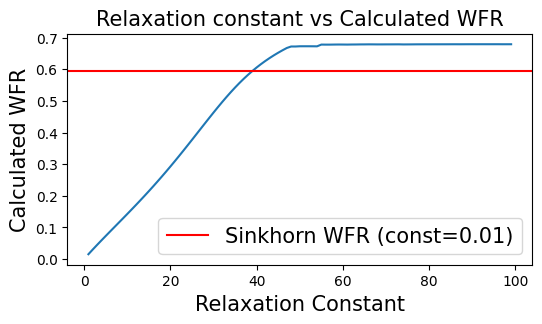

In [98]:
# Plotting
plt.figure(figsize=(6, 3))

plt.plot(rels, wfrs)
plt.axhline(y=wfr_sink, color='r', linestyle='-', label = 'Sinkhorn WFR (const=0.01)')
plt.xlabel('Relaxation Constant', fontsize = '15')
plt.ylabel('Calculated WFR', fontsize='15')
plt.title('Relaxation constant vs Calculated WFR', fontsize = '15')
plt.legend(fontsize = '15')
plt.show()

Again we observe the plateau. We will now plot the solution at each time for `rel`=50.

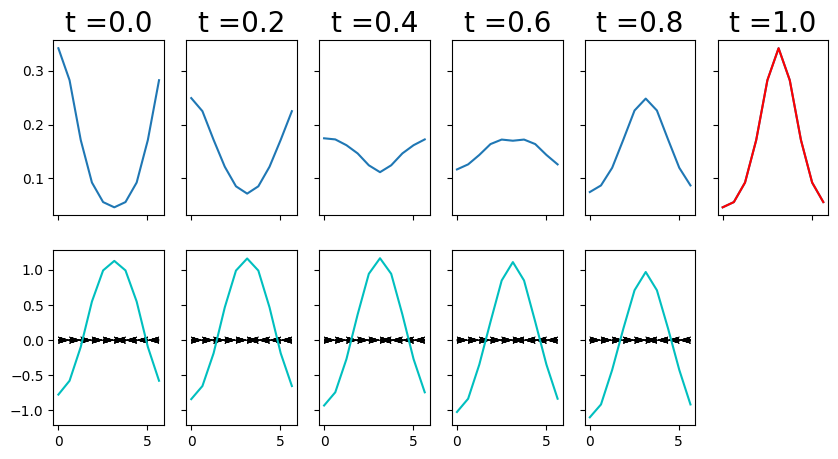

In [138]:
T = 10
N = 10
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)
wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=50, T=T, dx=dx)

# Plotting

time_steps = p.shape[0]
space_steps = p.shape[-1]
if dx is None:
    dx = [1.0/space_steps]

xs = np.arange(0, space_steps*dx[0], dx[0])

X, Y = np.meshgrid(xs, np.zeros_like(xs))

time_steps = [0, 2, 4, 6, 8, 10]
fig, ax = plt.subplots(2, len(time_steps), figsize = (10, 5), sharex='col', sharey = 'row')

for i in range(len(time_steps)):
    ax[0, i].plot(xs, p[time_steps[i]])
    ax[0, i].set_title(f't ={time_steps[i]/10}', fontsize = '20')
    if p2 is not None and i == 5:
        ax[0, i].plot(xs, p2, color='r')
    if i < 5:
        if v is not None:
            U = np.tile(v[time_steps[i]].squeeze(), (1, space_steps))
            V = np.zeros_like(X)
            ax[1,i].quiver(X, Y, U/np.sqrt(U**2), V, width=0.05, scale=10)
        if z is not None:
            ax[1,i].plot(xs, z[time_steps[i]], color='c')

ax[1,5].axis('off')
plt.show()

# Example 2.1: Oscillating solution
Here, we take $N$ to be large and $T$ to be small to observe an oscillating solution originating from the violation of the CFL condition. 

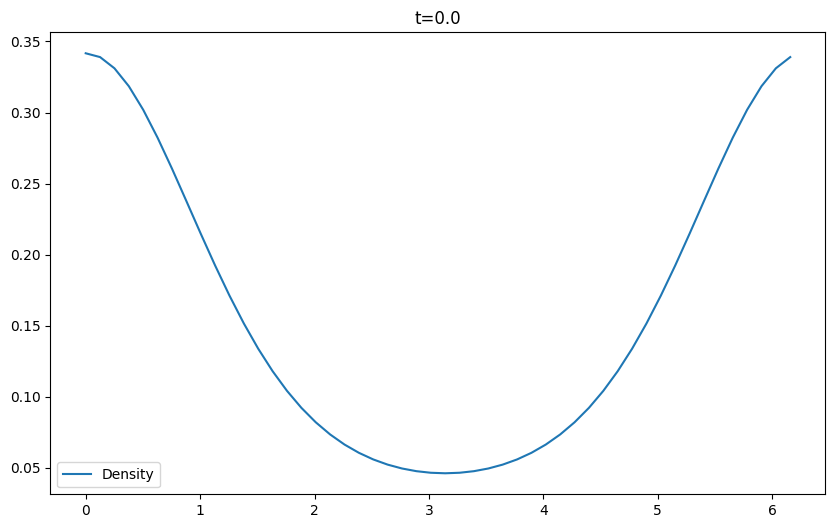

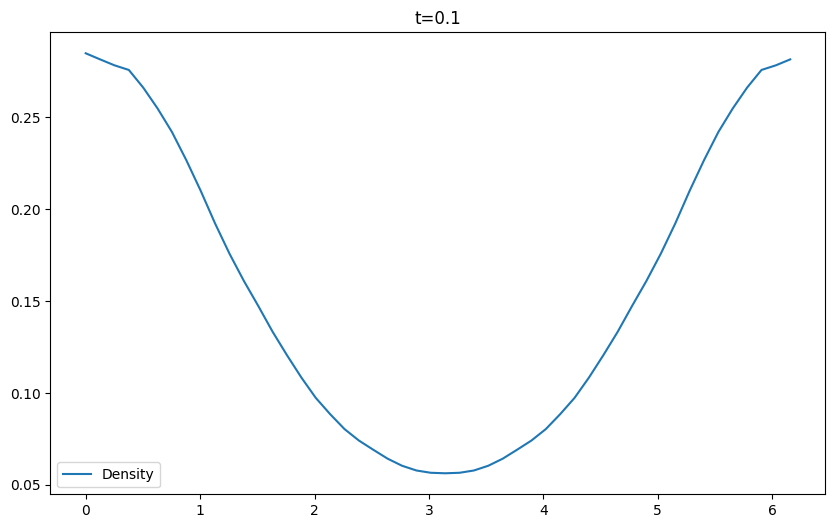

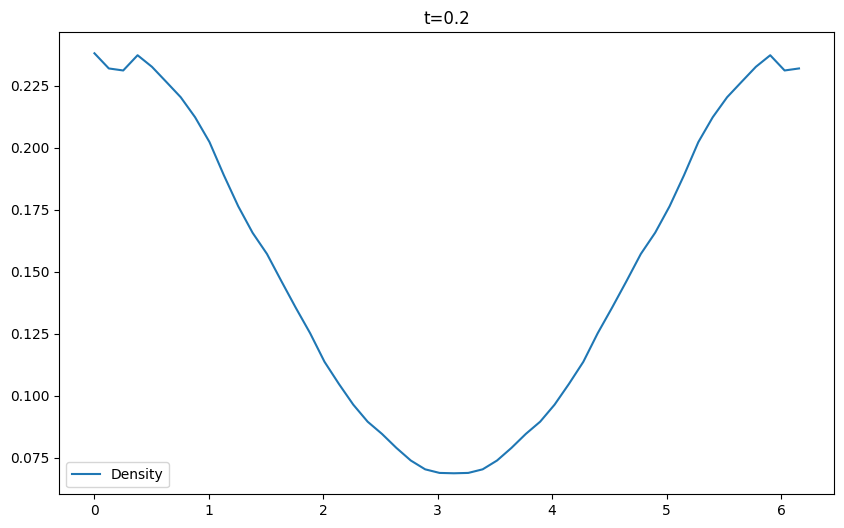

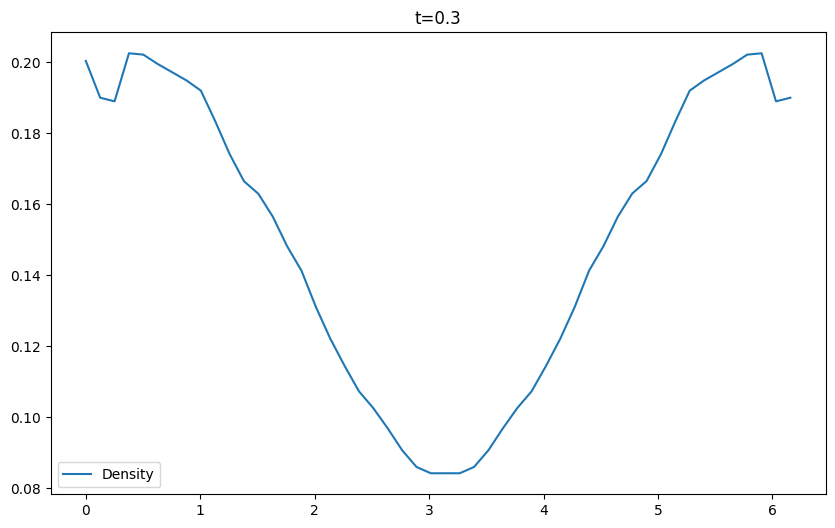

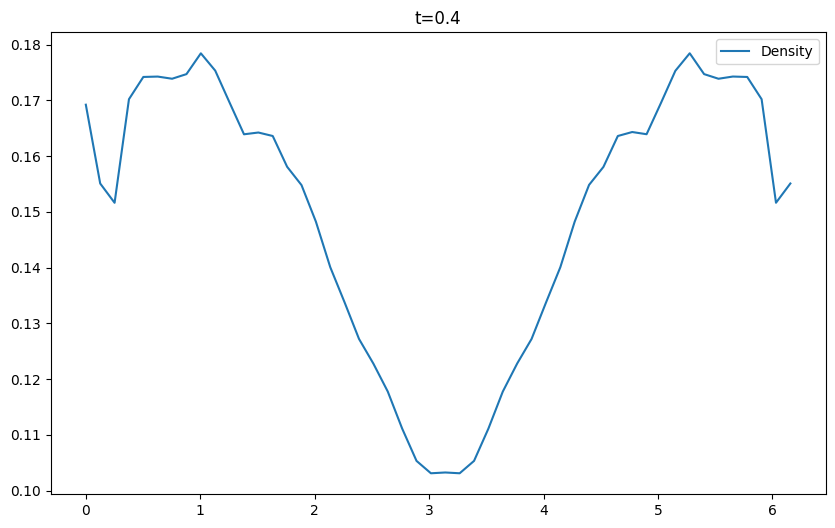

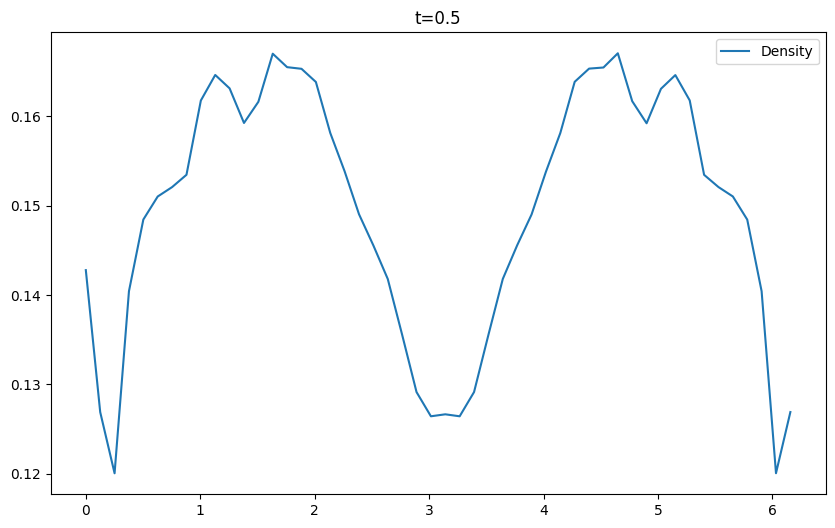

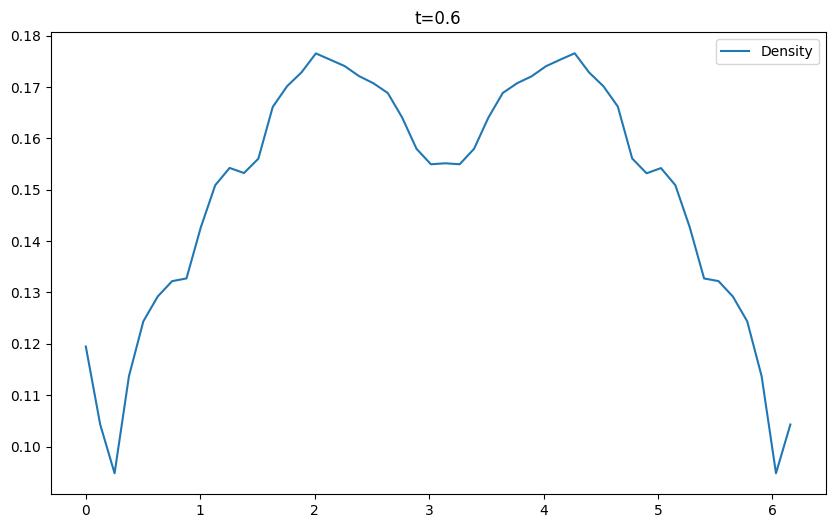

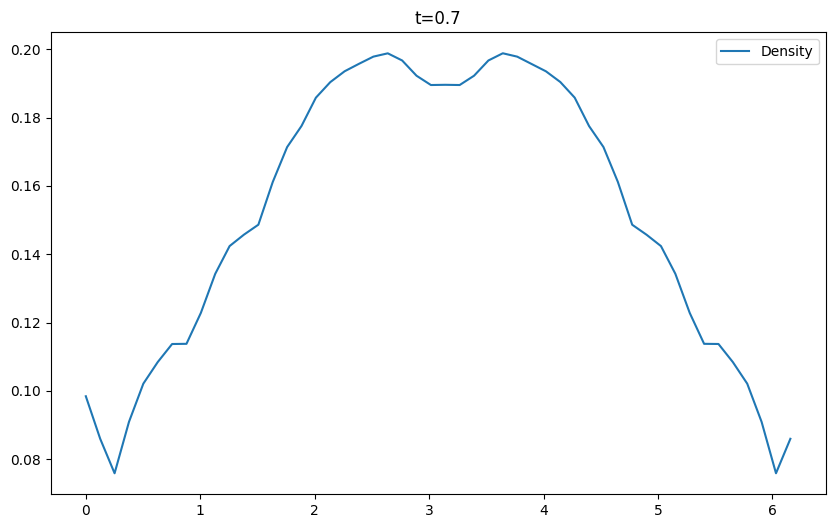

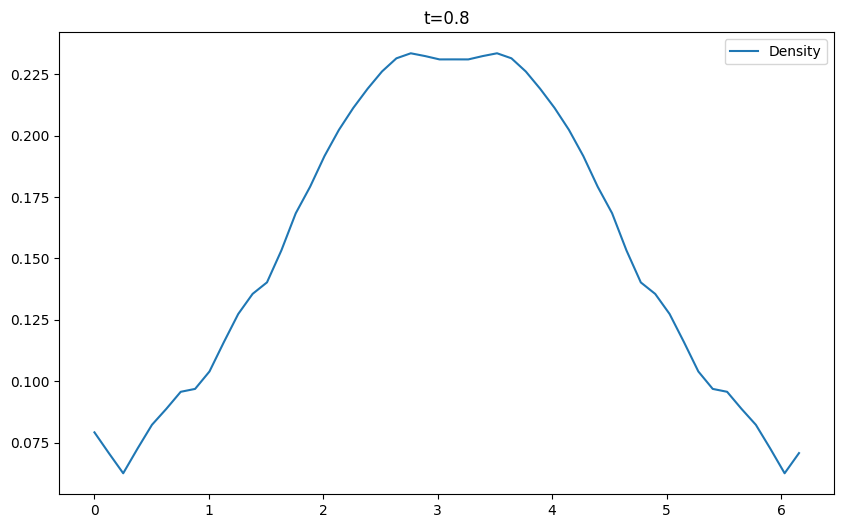

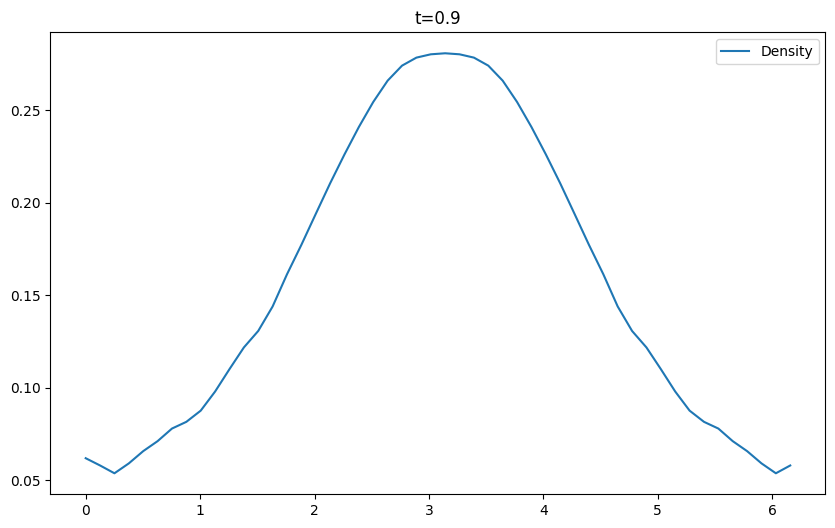

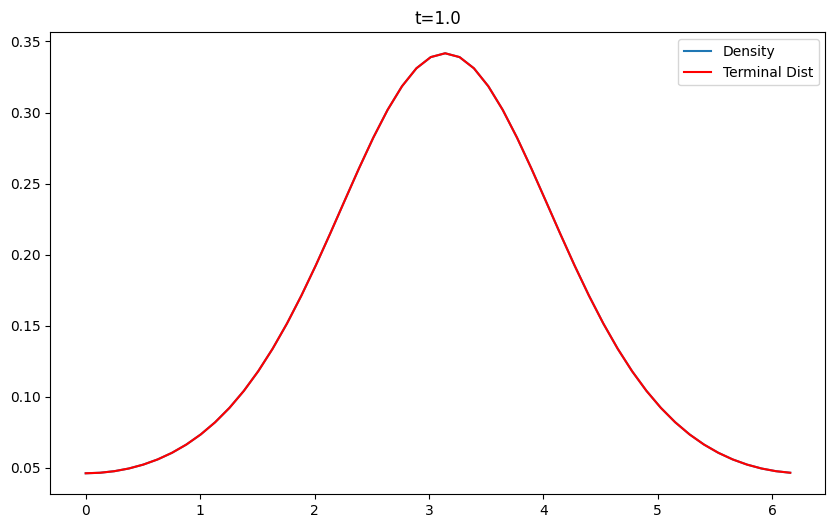

In [25]:
T = 10
N = 50
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)
wfr, p, v, z, best_rel = wfr_grid_scipy_tunerel(p1, p2, delta=1, rel_start=100, rel_stop=200, rel_step = 1, T=T, dx=dx)

# Plotting

plot_pvz_1D(p, None, None, dx=dx, p2 = p2)

# Example 3: Scaling with total mass constraint

Here, we do the same experiment as Example 1 under the total mass constraint $\rho_t(\Omega) = f(t)$. We interpolate the uniform distributions of mass $1$ and mass $4$, but under the constraint $\rho_t(\Omega)=f(t) = 6 \sin\left(\frac{5\pi}{6} t\right)+1$. 

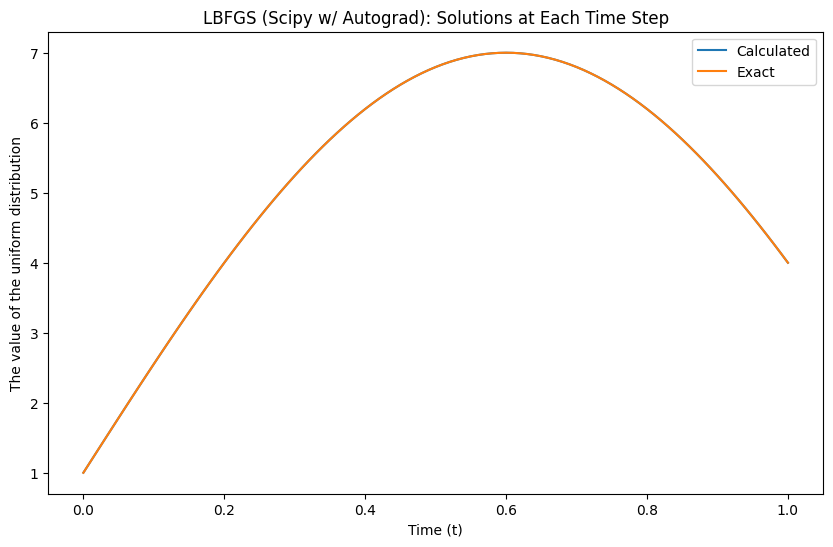

In [3]:
T = 100
N = 100
p1 = np.ones(N)
p2 = 4*np.ones(N)


t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 6*np.sin((5*np.pi/6)*t)+1

wfr, p, v, z, best_rel = wfr_grid_scipy_tunerel(p1, p2, delta=1, rel_start=1, rel_stop=10, rel_step = 1, T=T, H=H, F=F)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(t, p[:, 0], label = 'Calculated')
plt.plot(t, F, label = 'Exact')

plt.xlabel('Time (t)')
plt.ylabel('The value of the uniform distribution')
plt.title('LBFGS (Scipy w/ Autograd): Solutions at Each Time Step')
plt.legend()
plt.show()

We observe that the our calculated density matches well with the expected solution. We also observe an interesting phenomenon shown below.

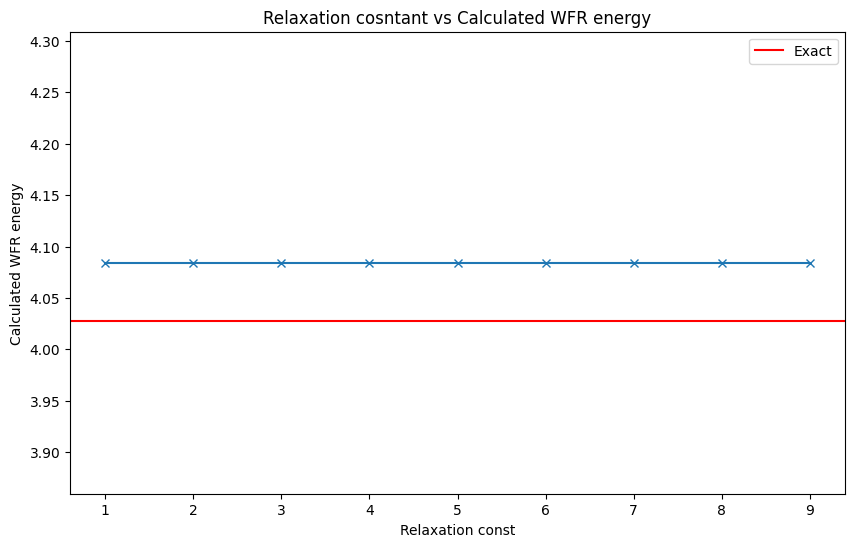

In [4]:
wfrs = []
rels = np.arange(1, 10, 1)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=4.0275581885737655, color='r', linestyle='-', label = 'Exact')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.legend()
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We observe that the calclated WFR is always the same regardless of the relaxation constant. We have also tested for a large range of `rel`, and still observed the same phenomenon. We believe it is because the constraint leaves no wiggle room for our `v`, `z` and end up being the same for all `rel`.

We will now check if the WFR energy converges to the exact solution as $T\to \infty$.

In [ ]:
wfrs = []
Ts = list(range(100,10000, 100))

for T in Ts:
    N = 10
    p1 = np.ones(N)
    p2 = 4*np.ones(N)

    t = np.linspace(0, 1, T+1)
    H = np.ones((T+1, N))
    F = 6*np.sin((5*np.pi/6)*t)+1

    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=1, T=T, H=H, F=F)
    wfrs.append(wfr)
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(Ts, wfrs, label = 'Calculated WFR')
plt.yscale('log')
plt.axhline(y=4.0275581885737655, color='r', linestyle='-', label = 'Exact')

plt.xlabel('T: The number of time steps')
plt.ylabel('Square root of the WFR energy')
plt.title('The number of time steps vs Calculated WFR')
plt.legend()
plt.show()
#19 min for all steps, 24.7 sec for T=10000, N=10

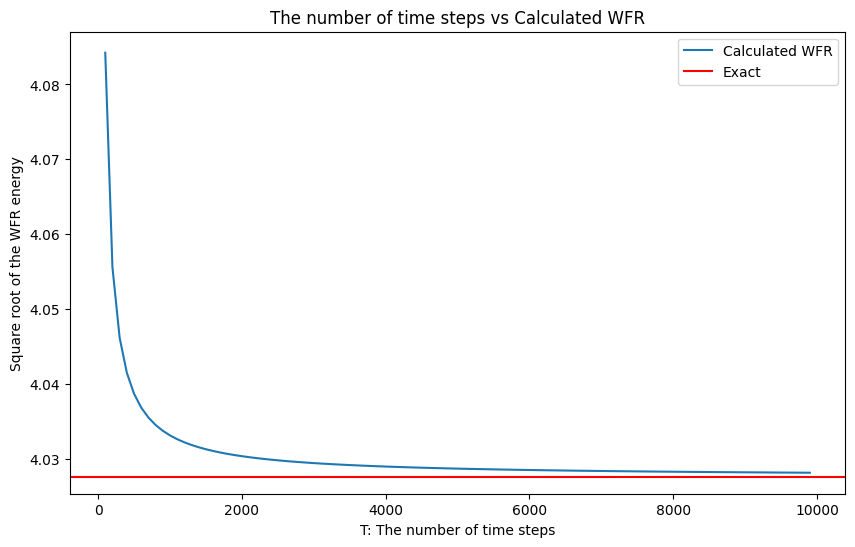

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(Ts, wfrs, label = 'Calculated WFR')
plt.axhline(y=4.0275581885737655, color='r', linestyle='-', label = 'Exact')
plt.xlabel('T: The number of time steps')
plt.ylabel('Square root of the WFR energy')
plt.title('The number of time steps vs Calculated WFR')
plt.legend()
plt.show()

### Example 4: Scaling of von Mises with total mass constraint $\rho_t(\Omega) =2(t-1/2)^2+1/2$ (a U-shaped function)

To test our algorithm further, we consider the interpolation of the **same** von-Mises under the constraint above. We should have a nontrivial solution due to the constraint. In particular, the optimal sqrt energy should be 

$\begin{align}  \textrm{WFR}^{1,F}_\delta = \left(\frac{1}{2}\int_{0}^{1}\frac{F'(t)^2}{F(t)}dt \right)^{1/2}= \sqrt{4-\pi} \end{align} \tag*{}$

We first check the relationship between the optimal WFR and the relaxation constant.

In [19]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = p1

wfrs = []
rels = np.arange(1, 100, 1)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, dx=dx, H=H, F=F)
    wfrs.append(float(wfr))

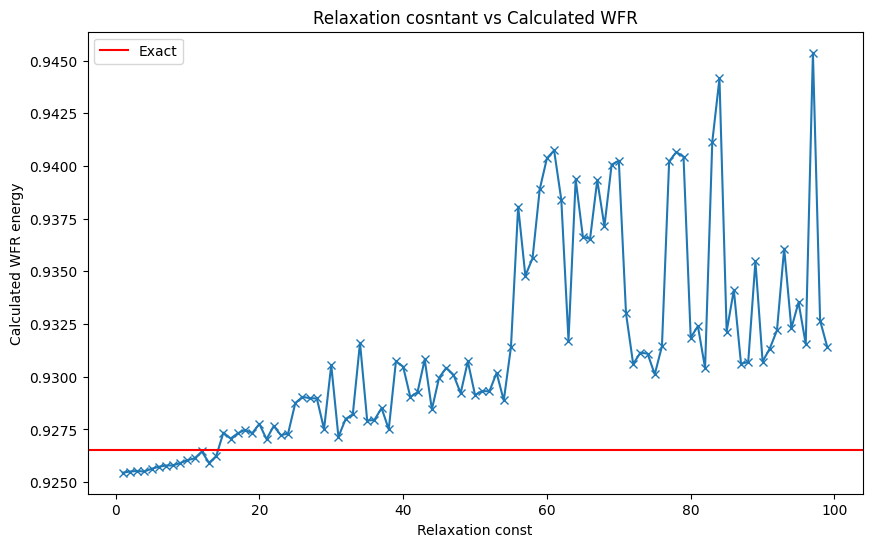

In [21]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=np.sqrt(4-np.pi), color='r', linestyle='-', label = 'Exact')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.legend()
plt.title('Relaxation cosntant vs Calculated WFR')

plt.show()

We observe that there is a phase transition at around `rel`=60 and after the thereshold, the WFR energy drops below the exact value. To observe what happens after `rel=100`, we will continue this experiment below.

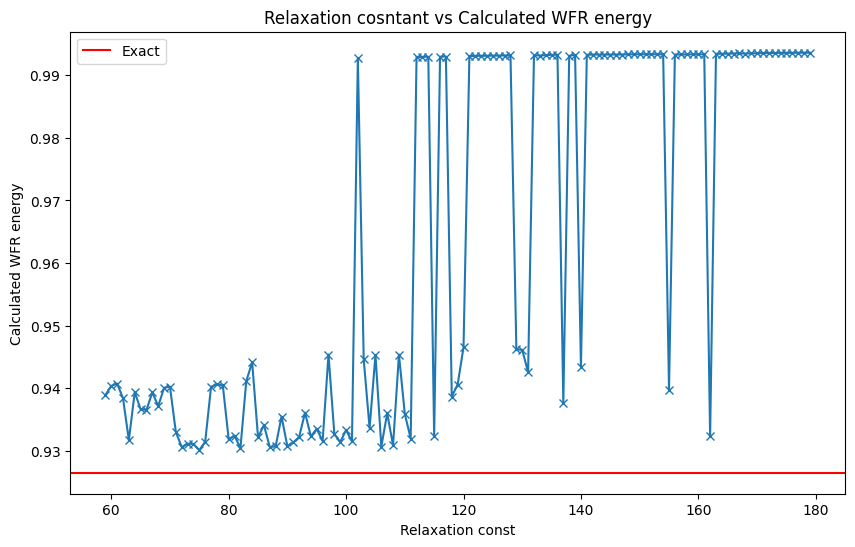

In [24]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = p1

wfrs = []
rels = np.arange(59, 180, 1)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, dx=dx, H=H, F=F)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=np.sqrt(4-np.pi), color='r', linestyle='-', label = 'Exact')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.legend()
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We will now take $T\to \infty$ for a fixed `rel`=60 and see if we can also observe the convergence here. 

In [3]:
wfrs = []
Ts = list(range(100,10000, 100))

for T in Ts:
    N = 10
    t = np.linspace(0, 1, T+1)
    H = np.ones((T+1, N))
    F = 2*(t-0.5)**2+0.5
    dx = [2*np.pi/N]

    xs = np.arange(0, 2*np.pi, 2*np.pi/N)
    p1 = von_mises_pdf(xs, 0, 1)
    p2 = p1

    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=60, T=T, H=H, F=F, dx=dx)
    wfrs.append(wfr)
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(Ts, wfrs, label = 'Calculated WFR')
plt.yscale('log')
plt.axhline(y=np.sqrt(4-np.pi), color='r', linestyle='-', label = 'Exact')

plt.xlabel('T: The number of time steps')
plt.ylabel('Square root of the WFR energy')
plt.title('The number of time steps vs Calculated WFR')
plt.legend()
plt.show()

#4281m until 57


KeyboardInterrupt: 

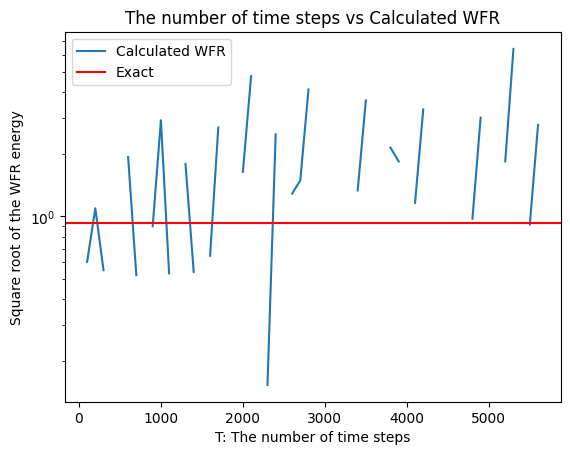

In [7]:
plt.plot(Ts[:57], wfrs, label = 'Calculated WFR')
plt.yscale('log')
plt.axhline(y=np.sqrt(4-np.pi), color='r', linestyle='-', label = 'Exact')

plt.xlabel('T: The number of time steps')
plt.ylabel('Square root of the WFR energy')
plt.title('The number of time steps vs Calculated WFR')
plt.legend()
plt.show()

In [6]:
wfrs_np = np.array(wfrs)
np.save('convergence_example4.npy', wfrs_np)

### Example 4.1: Transport of von Mises with total mass constraint $\rho_t(\Omega) = 2(t-1/2)^2+1/2$

Here, we consider the interpolation of the von-Mises distributions with the same total mass and the different center under the constraint above.

We first plot the square root of the optimal WFR energy against the relaxation constant to see if it still shows the "plateau" behavior.

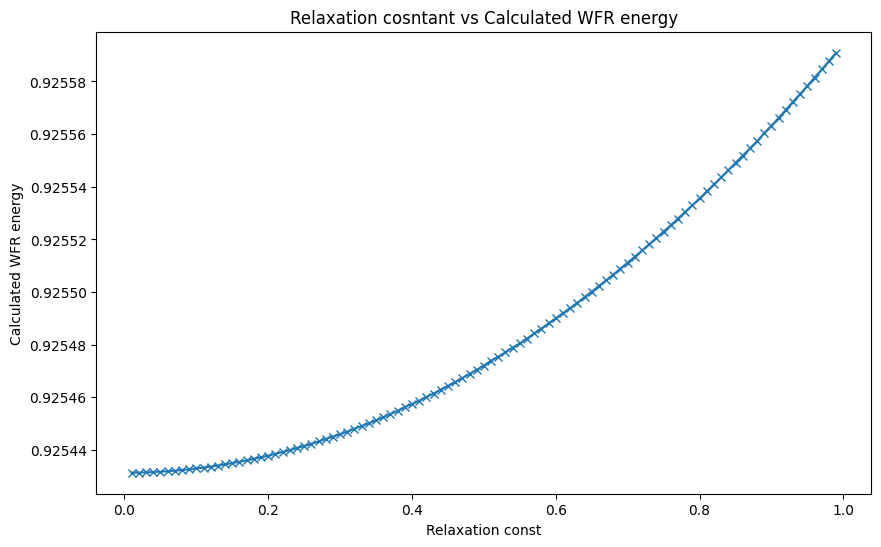

In [33]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

wfrs = []
rels = np.arange(0.01, 1, 0.01)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, dx=dx, H=H, F=F)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We observe that the constrained matching shows a different pattern in this scale. Let's see the behavior in a larger scale.

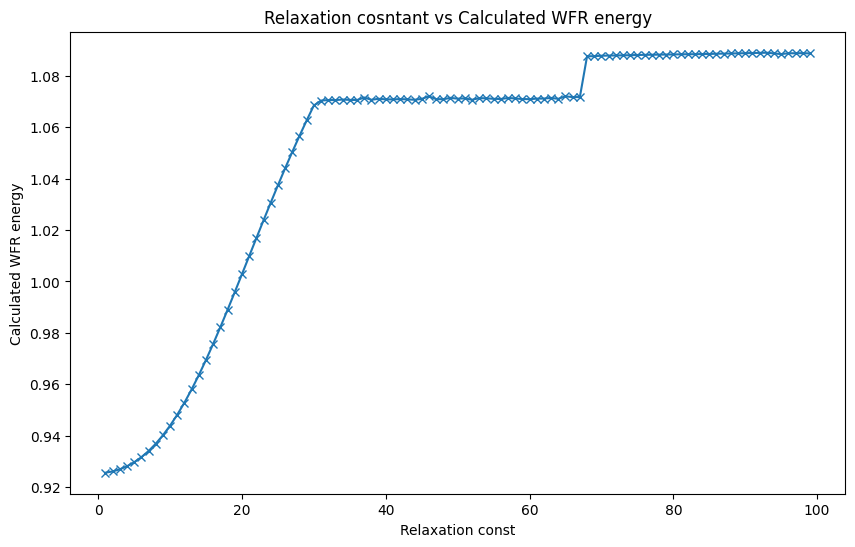

In [34]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

wfrs = []
rels = np.arange(1, 100, 1)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

Indeed, we observe that there is also the plateau behavior in this case. Let us plot the solution when `rel`=30.

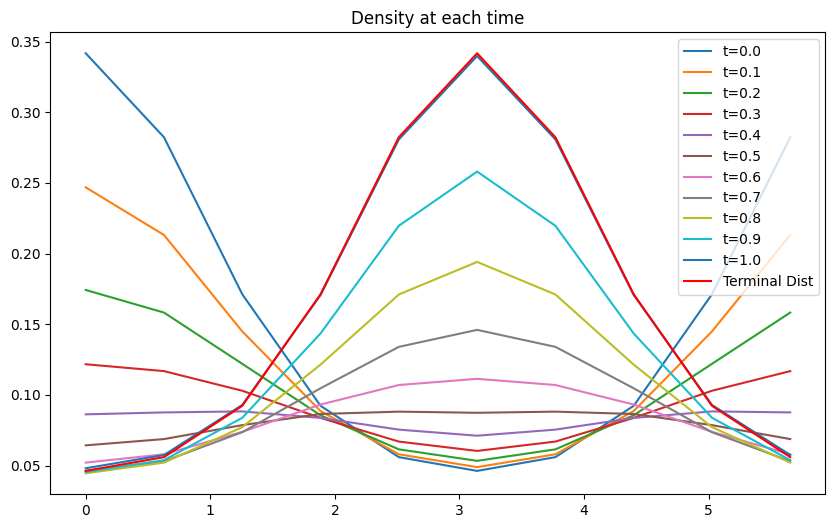

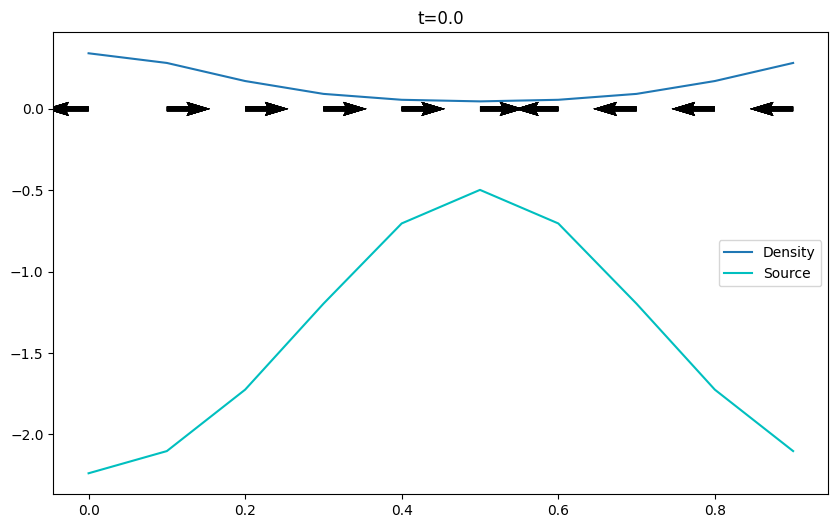

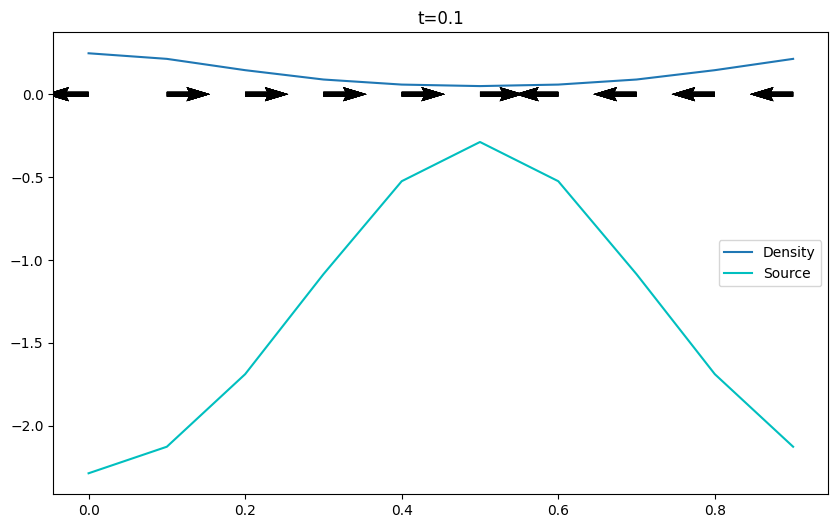

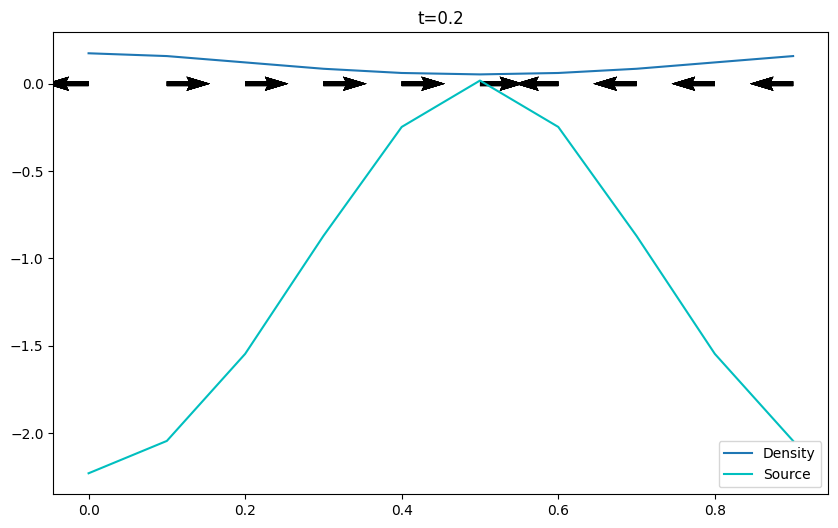

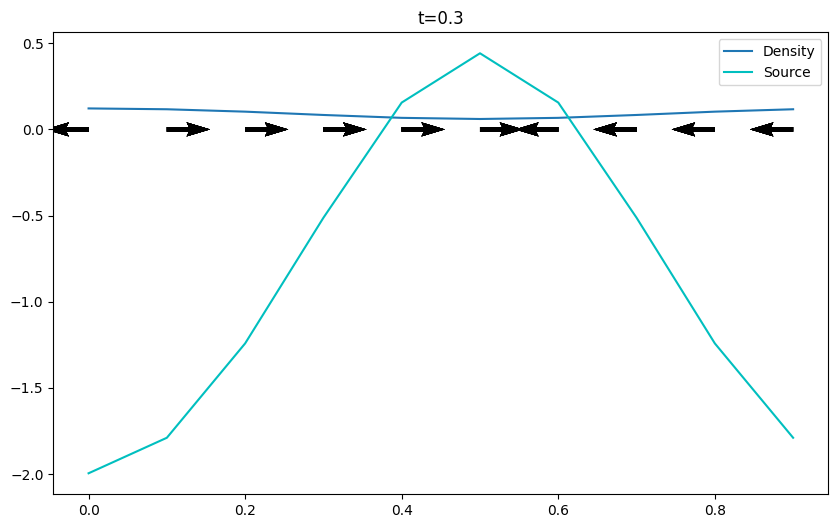

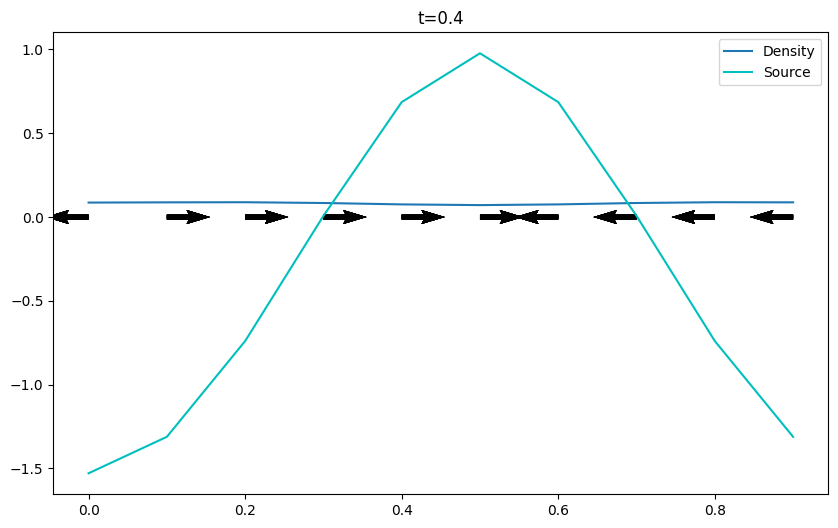

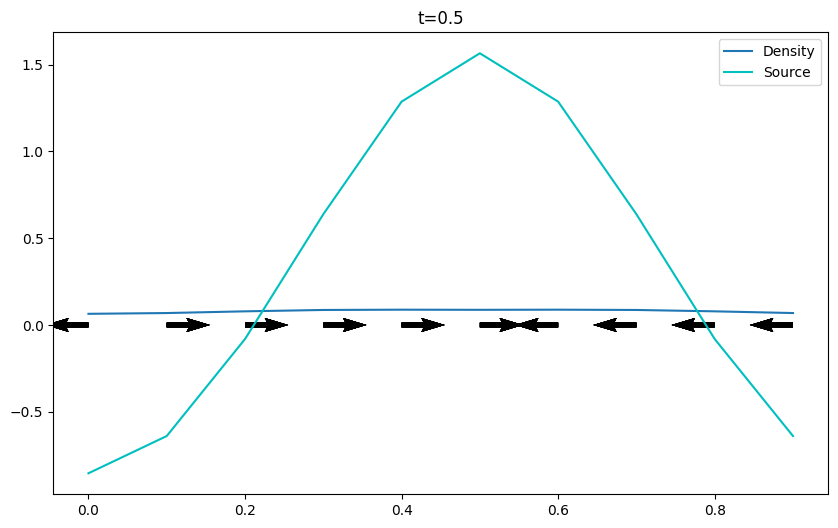

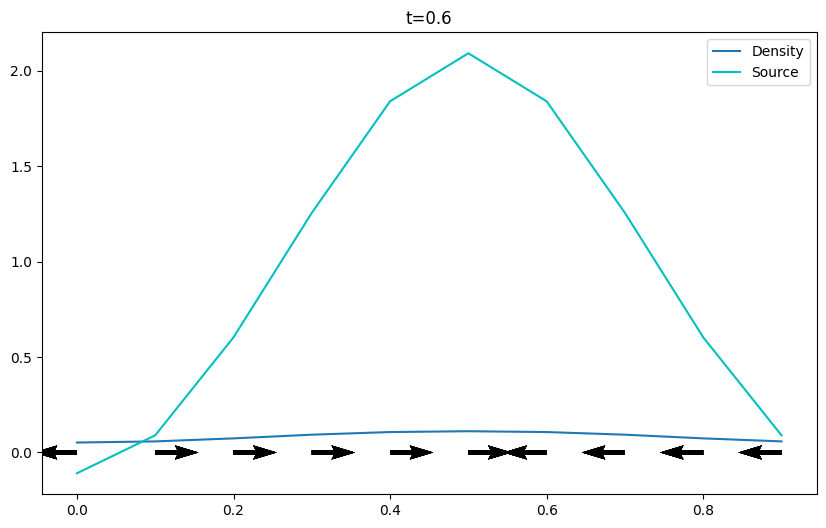

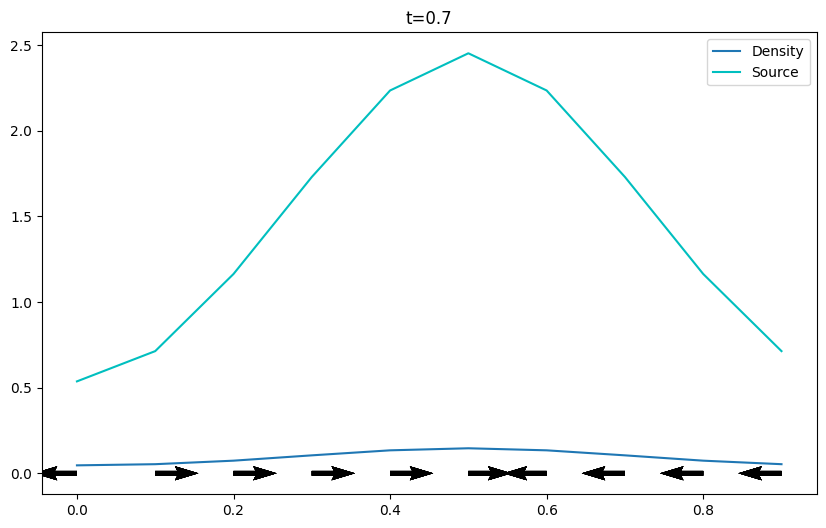

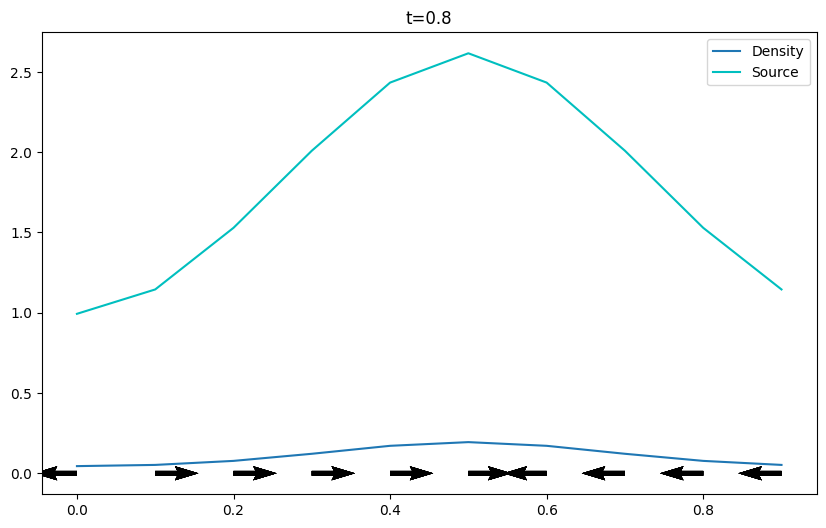

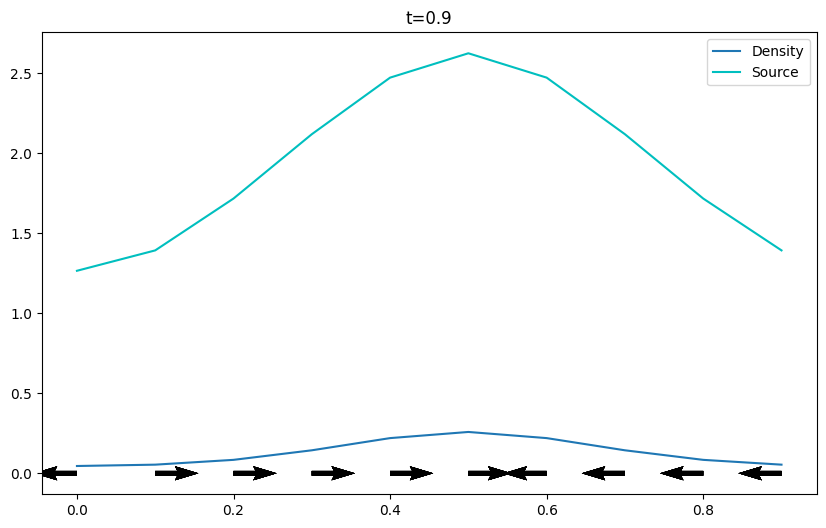

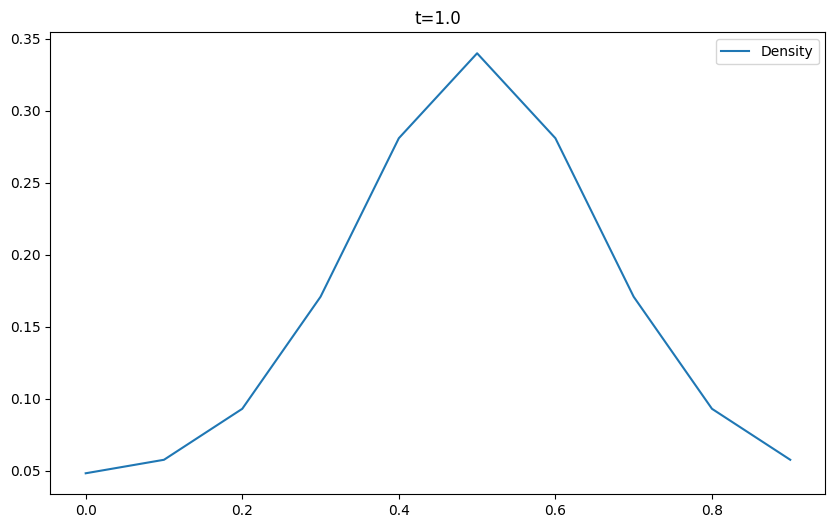

In [35]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)
wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=30, T=T, dx=dx, H=H, F=F)

# Plotting
plot_p_1D_same(p, dx=dx, p2 = p2)
plot_pvz_1D(p, v, z)

### Example 5: The balanced transport with source. Verification of the conjecture.

Here, we consider the constraint $\rho_t(\Omega) =1$. In particular, we would like to verify the conjecture that the optimal path between two Diracs at $x_0,x_1$ with $\|x_0-x_1\|> \pi\delta$ is the constrained FR geodesic $\rho = (a(t)\delta_{x_0} + b(t)\delta_{x_1})$ with

$\begin{align} a(t) & = \cos^2\left(\frac{\pi}{2}t\right) \\ b(t) & = \sin^2\left(\frac{\pi}{2}t\right)\end{align} $

Due to the limitation of our method, it is not possible to directly interpolate Dirac measures, so we will use sharp ($\kappa=10$) von-Mises as their proxy. We also take $\delta=0.1$ instead of $1$ we have been using to make sure no transport occurs.

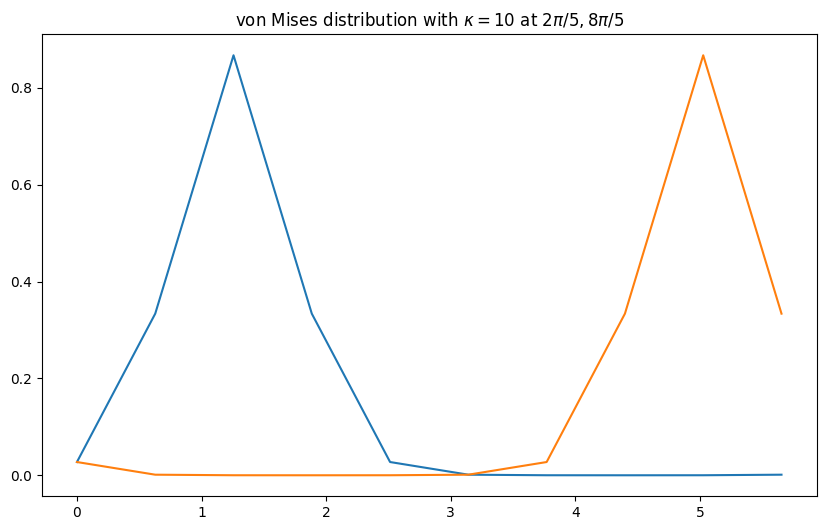

In [25]:
N=10
xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 5)
p2 = von_mises_pdf(xs, 8*np.pi/5, 5)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(xs, p1)
plt.plot(xs, p2)
plt.title('von Mises distribution with $\kappa=10$ at $2\pi/5, 8\pi/5$')
plt.show()

We first see the relationship between WFR and the relaxation constant.


rels: 1
rels: 2
rels: 3
rels: 4
rels: 5
rels: 6
rels: 7
rels: 8
rels: 9
rels: 10
rels: 11
rels: 12
rels: 13
rels: 14
rels: 15
rels: 16
rels: 17
rels: 18
rels: 19
rels: 20
rels: 21
rels: 22
rels: 23
rels: 24
rels: 25
rels: 26
rels: 27
rels: 28
rels: 29
rels: 30
rels: 31
rels: 32
rels: 33
rels: 34
rels: 35
rels: 36
rels: 37
rels: 38
rels: 39
rels: 40
rels: 41
rels: 42
rels: 43
rels: 44
rels: 45
rels: 46
rels: 47
rels: 48
rels: 49
rels: 50
rels: 51
rels: 52
rels: 53
rels: 54
rels: 55
rels: 56
rels: 57
rels: 58
rels: 59
rels: 60
rels: 61
rels: 62
rels: 63
rels: 64
rels: 65
rels: 66
rels: 67
rels: 68
rels: 69
rels: 70
rels: 71
rels: 72
rels: 73
rels: 74
rels: 75
rels: 76
rels: 77
rels: 78
rels: 79
rels: 80
rels: 81
rels: 82
rels: 83
rels: 84
rels: 85
rels: 86
rels: 87
rels: 88
rels: 89
rels: 90
rels: 91
rels: 92
rels: 93
rels: 94
rels: 95
rels: 96
rels: 97
rels: 98
rels: 99


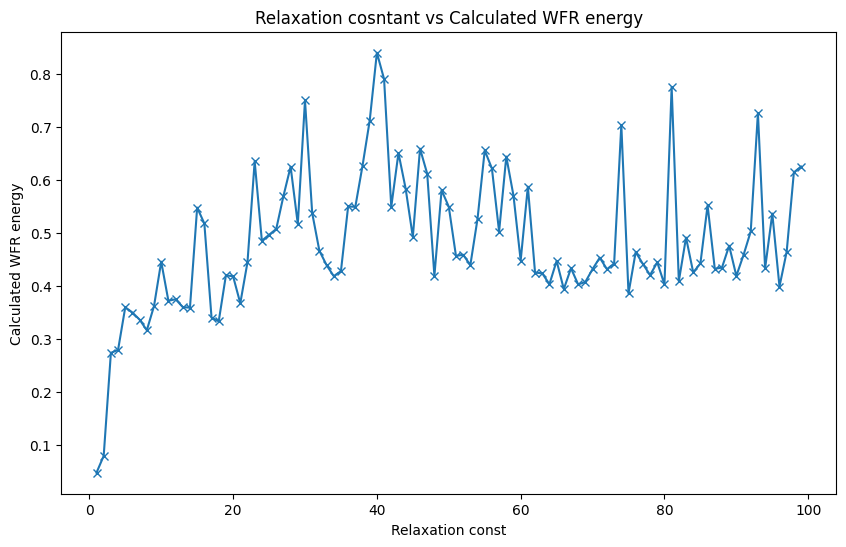

In [101]:
T = 10
N = 10
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 10)
p2 = von_mises_pdf(xs, 8*np.pi/5, 10)

wfrs = []
rels = np.arange(1, 100, 1)
for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=0.1, rel=rel, T=T, H=H, F=F, dx=dx)
    wfrs.append(float(wfr))

# Plottinga
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

In [124]:
T = 500
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 5)+0.2 # avoid having zero density
p2 = von_mises_pdf(xs, 8*np.pi/5, 5)+0.2 # avoid having zero density

wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=0.1, rel=5000, T=T, H=H, F=F, dx=dx)

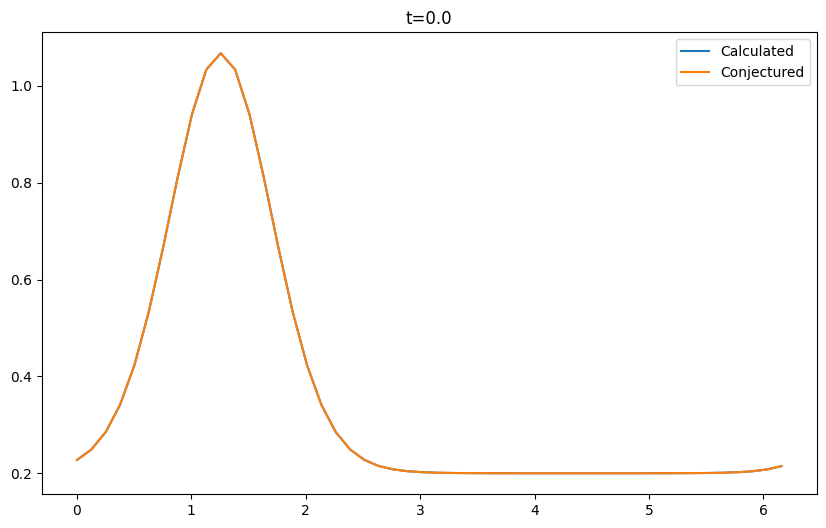

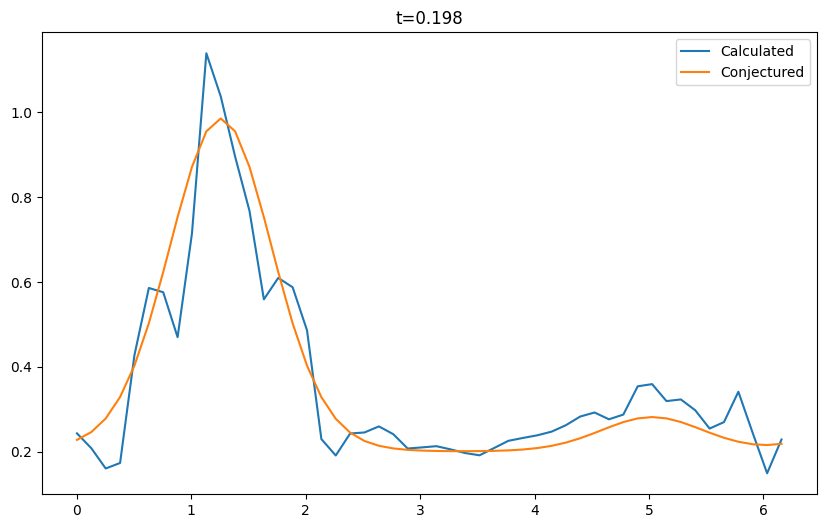

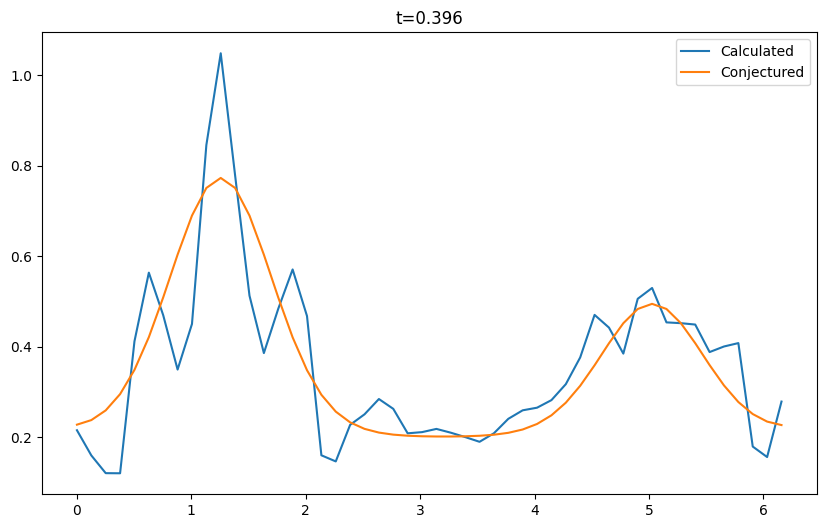

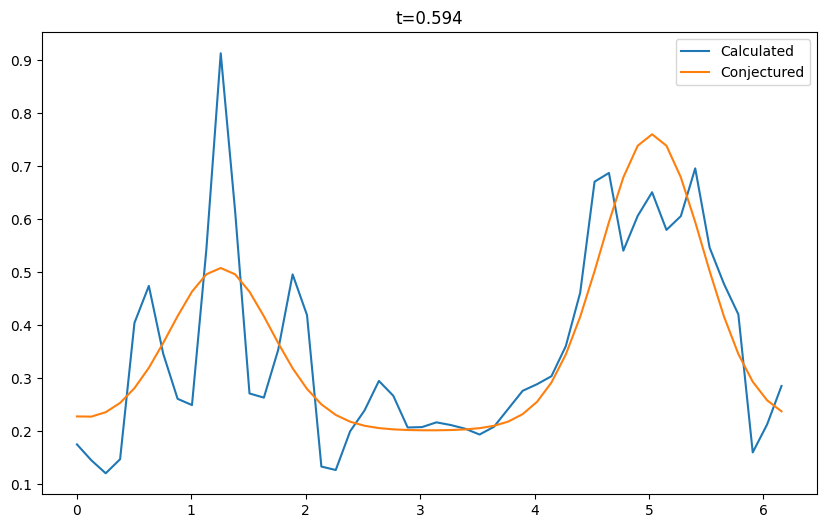

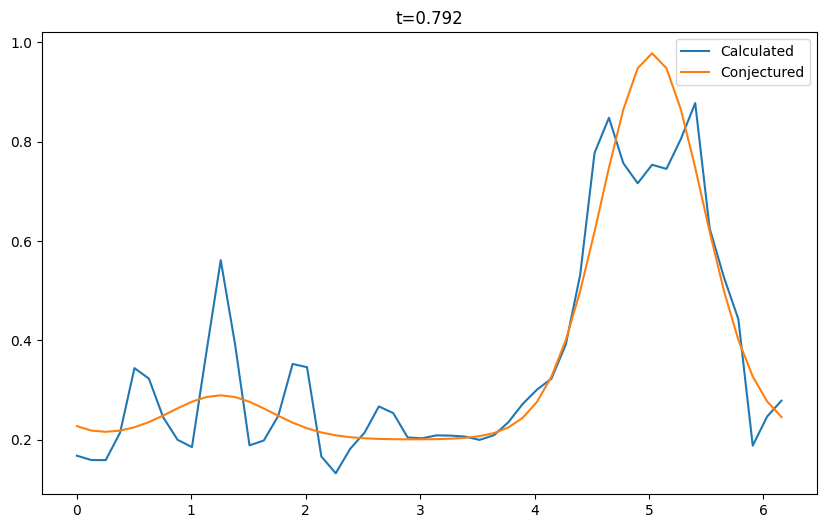

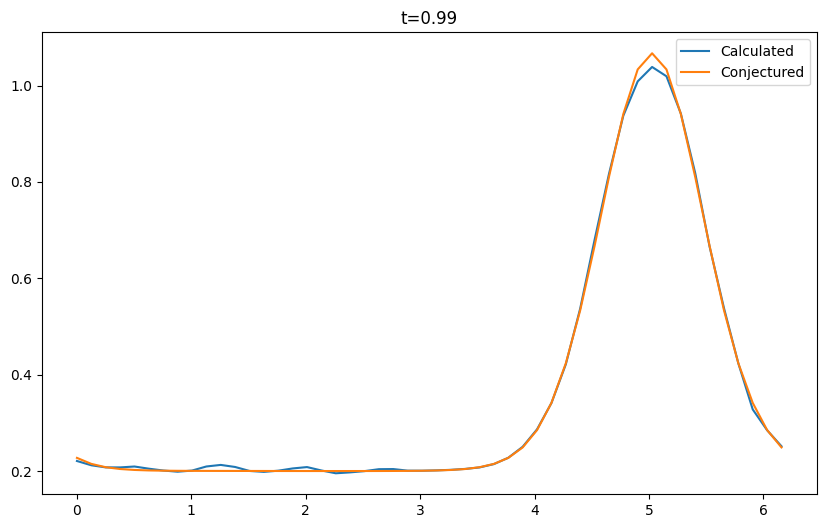

In [126]:
time_steps = p.shape[0]
space_steps = p.shape[-1]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, p1*np.cos(np.pi*time/2.)**2+p2*np.sin(np.pi*time/2.)**2, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

rels: 0.01
rels: 0.1
rels: 1
rels: 10
rels: 100
rels: 1000
rels: 2000
rels: 3000
rels: 4000
rels: 5000
rels: 6000
rels: 7000
rels: 8000
rels: 9000
rels: 10000


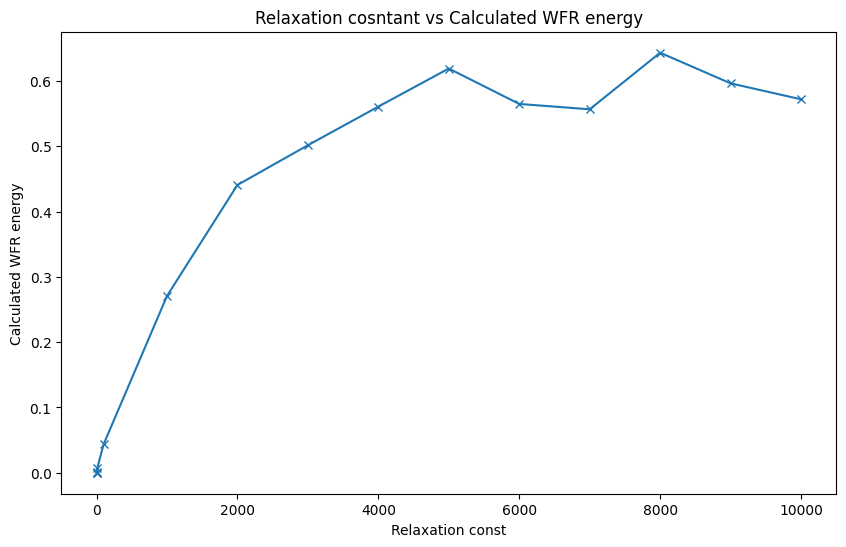

In [127]:
T = 500
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 10)
p2 = von_mises_pdf(xs, 8*np.pi/5, 10)

wfrs = []
rels = [0.01, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=0.1, rel=rel, T=T, H=H, F=F, dx=dx)
    wfrs.append(float(wfr))

# Plottinga
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

#201min

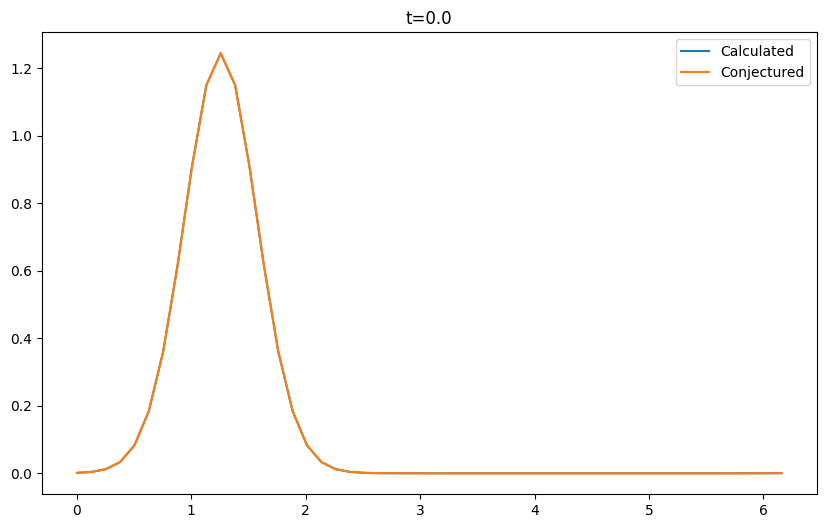

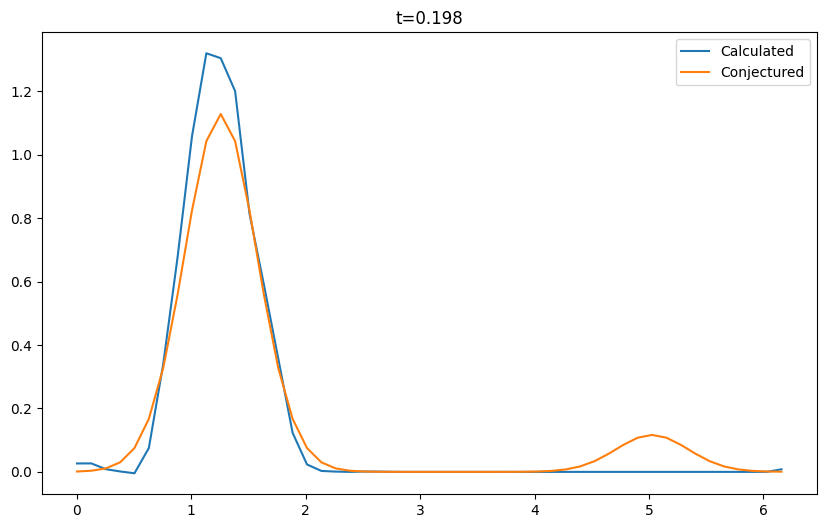

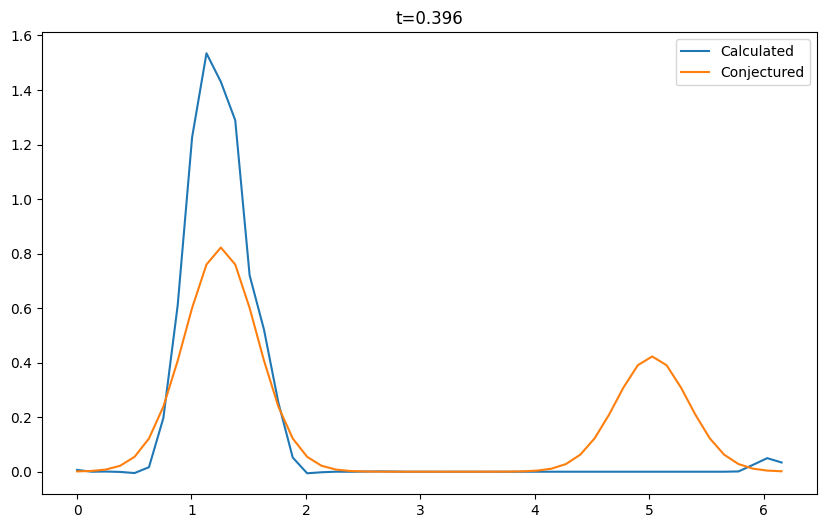

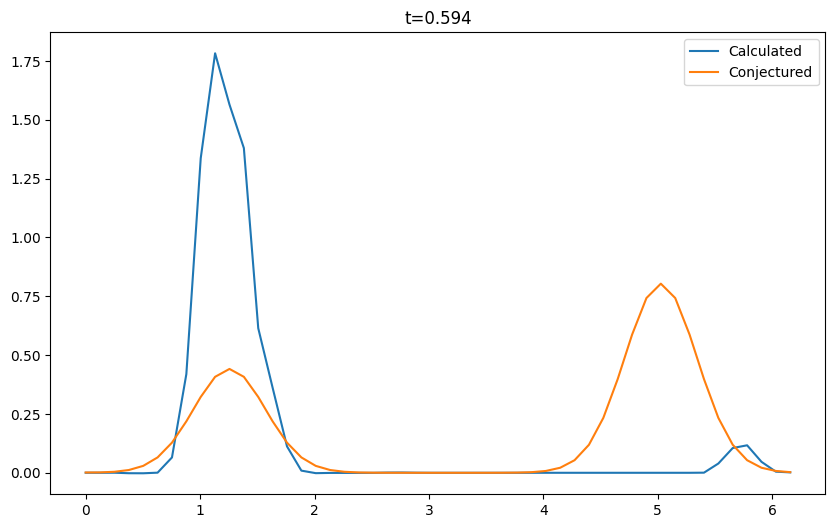

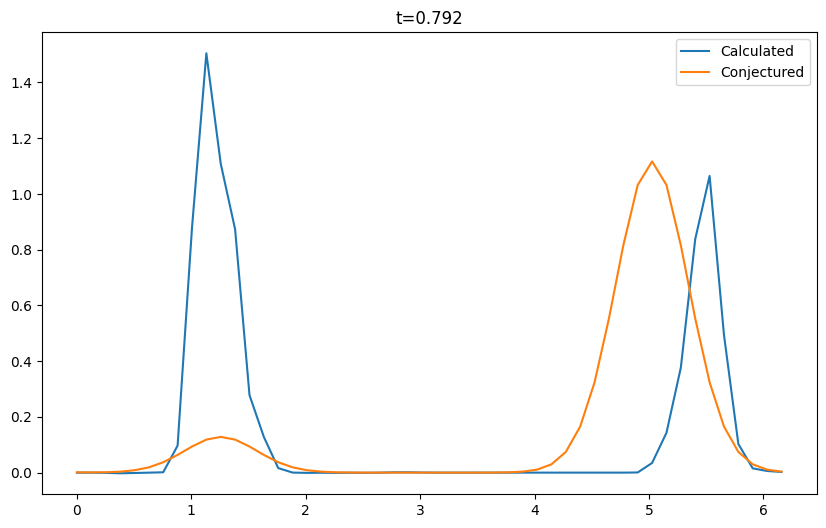

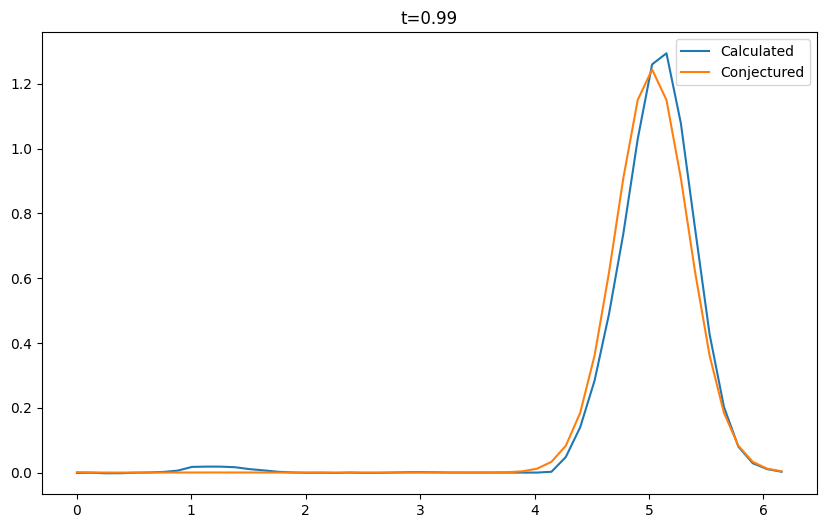

In [128]:
time_steps = p.shape[0]
space_steps = p.shape[-1]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, p1*np.cos(np.pi*time/2.)**2+p2*np.sin(np.pi*time/2.)**2, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

# The iterative process for tuning the relaxation constant

In this section, we will see if the following strategy mitigates the oscilaltion of the relaxation constant. The strategy is that we use the final solution for the previous relaxation constant as the initial condition of the next.

## Example 6: Unconstrained Scaling of Uniforms
Here, we conduct the same experiment as Example 1 to see how our new strategy changes the result.

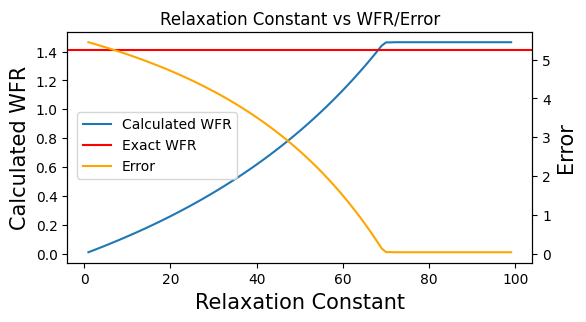

In [4]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

rels = np.arange(1,100,1)
wfrs = []
errors = []

t = np.linspace(0, 1, T+1)
exact = (t+1)**2

v = None
z = None

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, v0=v, z0=z)
    wfrs.append(float(wfr))
    errors.append(np.linalg.norm(p[:, 0]-exact))

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(rels, wfrs, label='Calculated WFR')
ax1.axhline(y=np.sqrt(2), color='r', linestyle='-', label = 'Exact WFR')
ax1.set_xlabel('Relaxation Constant', fontsize = '15')
ax1.set_ylabel('Calculated WFR', fontsize = '15')
ax1.set_title('Relaxation Constant vs WFR/Error')
ax2 = ax1.twinx()
ax2.plot(rels, errors, color = 'orange', label = 'Error')
ax2.set_ylabel('Error', fontsize = '15')
fig.legend(loc ='center left', bbox_to_anchor = (0.13,0.5))
plt.show()

In fact, we obtain a smoother result with faster convergence. (6.1 sec with the strategy / 20 sec without the strategy)

## Example 7: Unconstrained Translation of von Mises

We do the same experiment as Example 2.

In [8]:
T = 10
N = 10
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

rels = np.arange(1,100,1)
wfrs = []

v = None
z = None

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, dx=dx, v0=v, z0=z)
    wfrs.append(float(wfr))

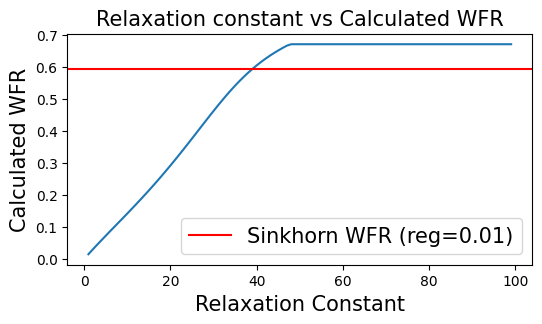

In [10]:
# Plotting
plt.figure(figsize=(6, 3))

plt.plot(rels, wfrs)
plt.axhline(y=wfr_sink, color='r', linestyle='-', label = 'Sinkhorn WFR (reg=0.01)')
plt.xlabel('Relaxation Constant', fontsize = '15')
plt.ylabel('Calculated WFR', fontsize='15')
plt.title('Relaxation constant vs Calculated WFR', fontsize = '15')
plt.legend(fontsize = '15')
plt.show()

Again, we observe faster convergence with a smooth curve.

# Example 8: Scaling of uniforms with total mass constraint

Redo of Example 3.

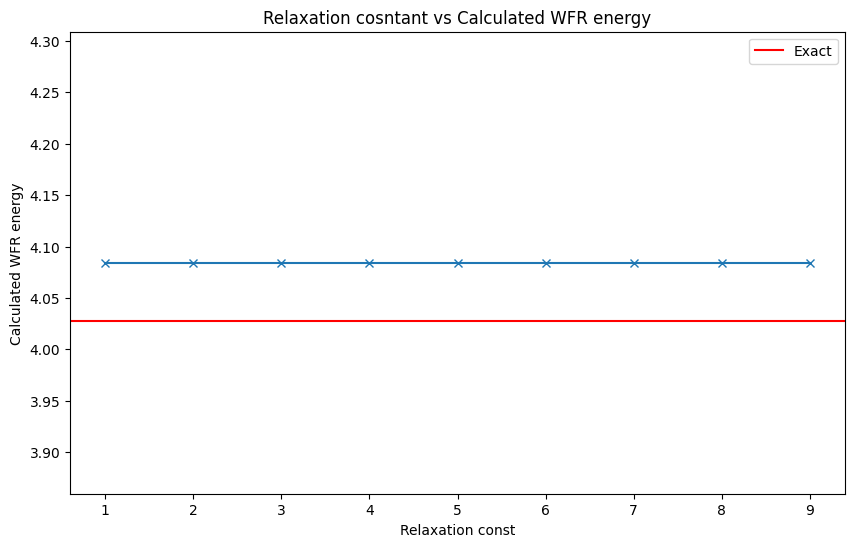

In [15]:
T = 100
N = 100
p1 = np.ones(N)
p2 = 4*np.ones(N)

t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 6*np.sin((5*np.pi/6)*t)+1

wfrs = []
rels = np.arange(1, 10, 1)

v = None
z = None

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, v0=v, z0=z)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=4.0275581885737655, color='r', linestyle='-', label = 'Exact')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.legend()
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

## Example 9: Scaling of von Mises with total mass constraint $\rho_t(\Omega) =2(t-1/2)^2+1/2$ (a U-shaped function)

Redo of Example 4.


In [26]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = p1

wfrs = []
rels = np.arange(1, 100, 1)
v = None
z = None

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, dx=dx, H=H, F=F, v0=v, z0 = z)
    wfrs.append(float(wfr))

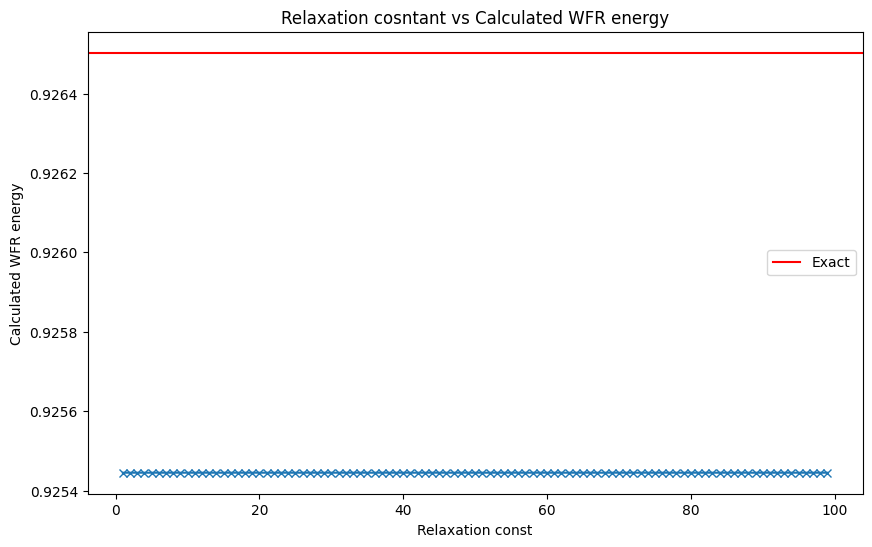

In [23]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=np.sqrt(4-np.pi), color='r', linestyle='-', label = 'Exact')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.legend()
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We observe that the calculated WFR is very stable, and the error from the exact WFR is very small given our time steps and the space steps. The following is the plot of p, v and z for the last `rel`, that is, the case when `rel`=100.

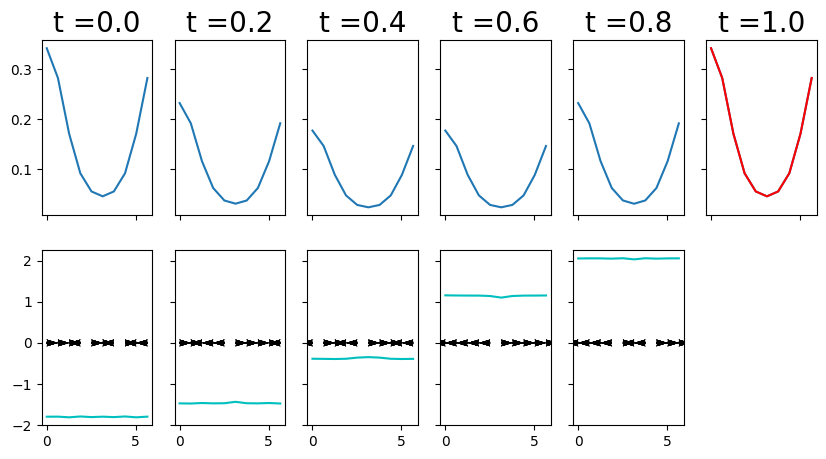

In [27]:
# Plotting

time_steps = p.shape[0]
space_steps = p.shape[-1]
if dx is None:
    dx = [1.0/space_steps]

xs = np.arange(0, space_steps*dx[0], dx[0])

X, Y = np.meshgrid(xs, np.zeros_like(xs))

time_steps = [0, 2, 4, 6, 8, 10]
fig, ax = plt.subplots(2, len(time_steps), figsize = (10, 5), sharex='col', sharey = 'row')

for i in range(len(time_steps)):
    ax[0, i].plot(xs, p[time_steps[i]])
    ax[0, i].set_title(f't ={time_steps[i]/10}', fontsize = '20')
    if p2 is not None and i == 5:
        ax[0, i].plot(xs, p2, color='r')
    if i < 5:
        if v is not None:
            U = np.tile(v[time_steps[i]].squeeze(), (1, space_steps))
            V = np.zeros_like(X)
            ax[1,i].quiver(X, Y, U/np.sqrt(U**2), V, width=0.05, scale=10)
        if z is not None:
            ax[1,i].plot(xs, z[time_steps[i]], color='c')

ax[1,5].axis('off')
plt.show()

The following shows the numerical values of `v`. As expected, all of the values are very small, meaning that there is almost no transport.

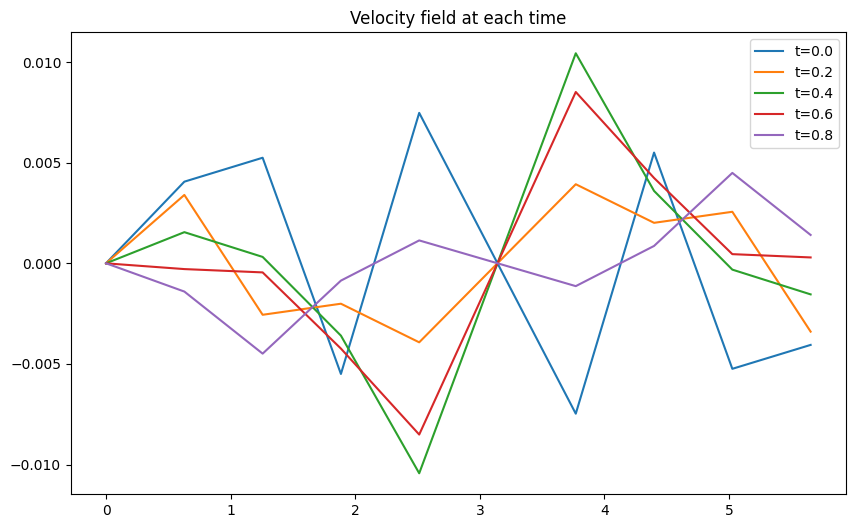

In [32]:
time_steps = [0, 2, 4, 6, 8]
plt.figure(figsize=(10, 6))
plt.title(f'Velocity field at each time')
for time_step in time_steps:
    plt.plot(xs, v[time_step], label = f't={time_step/(10)}')
    plt.legend()
plt.show()

## Example 10: Transport of von Mises with total mass constraint $\rho_t(\Omega) = 2(t-1/2)^2+1/2$

Redo of Experiment 4.1. We notice that there is not much diference from the original case.

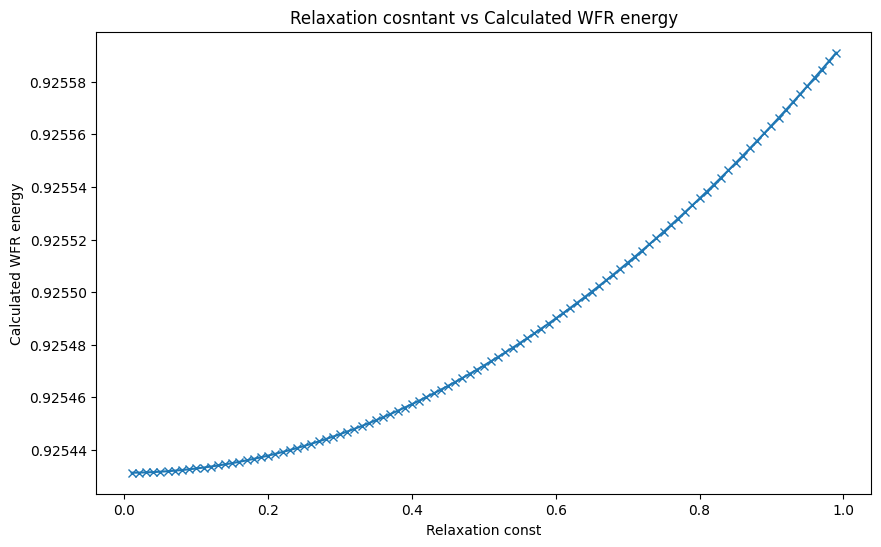

In [37]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

wfrs = []
rels = np.arange(0.01, 1, 0.01)

v = None
z = None

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, dx=dx, H=H, F=F, v0=v, z0=z)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

As done in the origianl case, we plot the relaxation constant in the large scale.

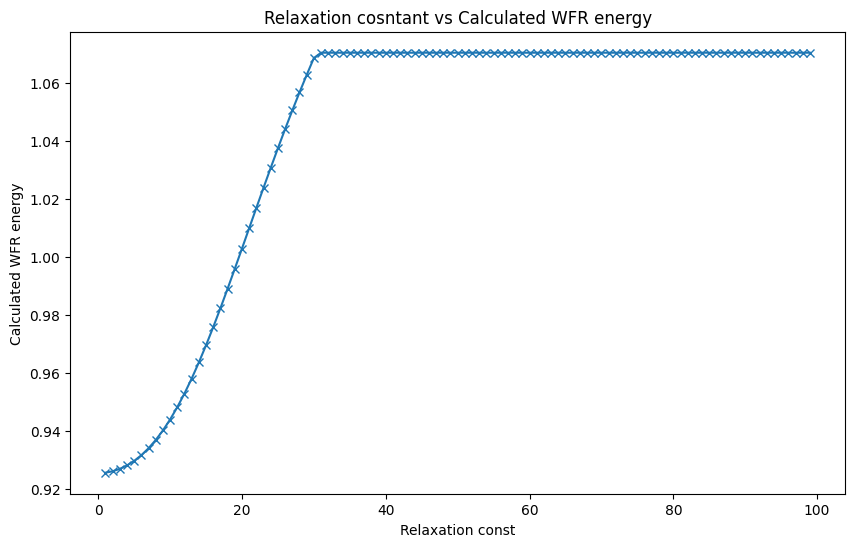

In [38]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

wfrs = []
rels = np.arange(1, 100, 1)

v=None
z=None

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v,z0=z)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We observe that our graph is more stable than the original case. We will now plot p, v, z for the last solution (i.e. the case when `rel`=100.) We observe that the solution visually looks the same as the one with `rel`=30 in the original case.

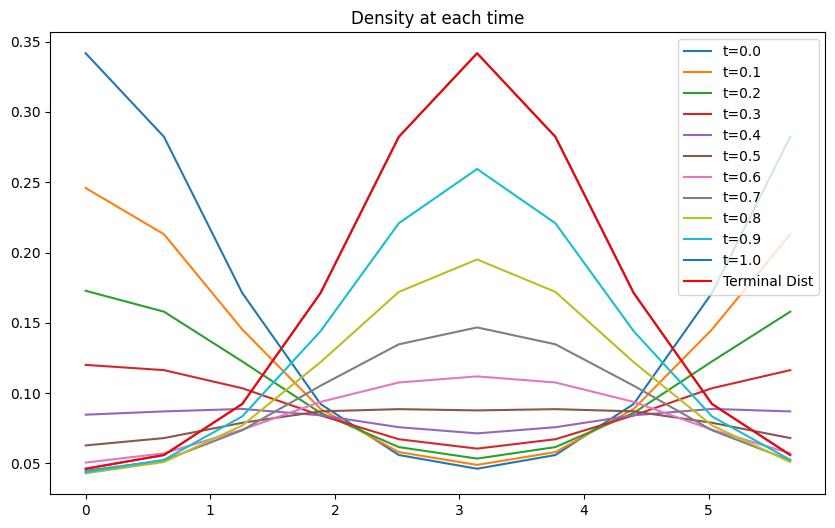

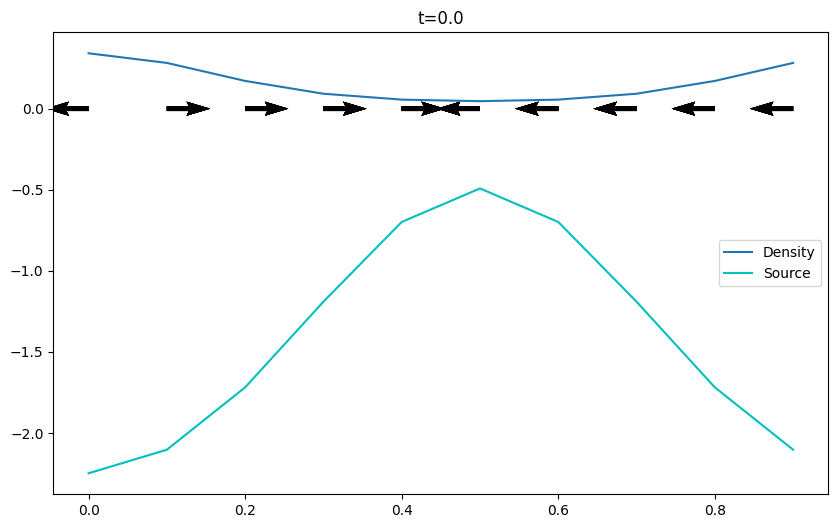

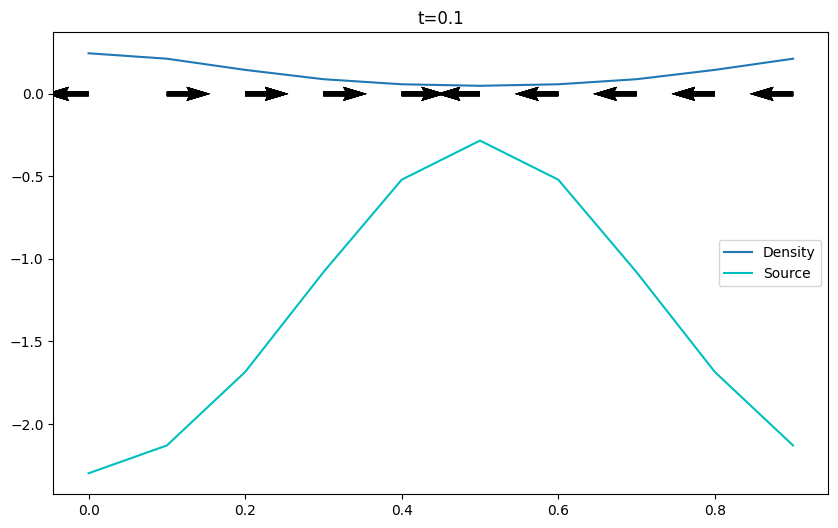

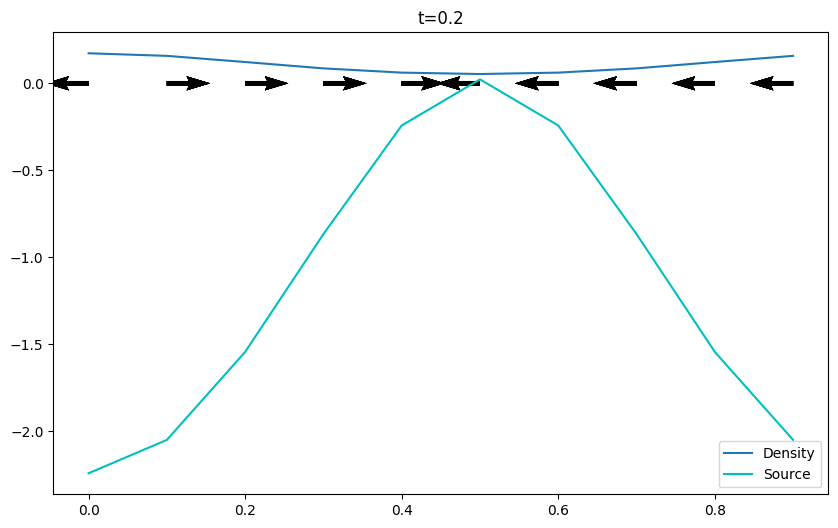

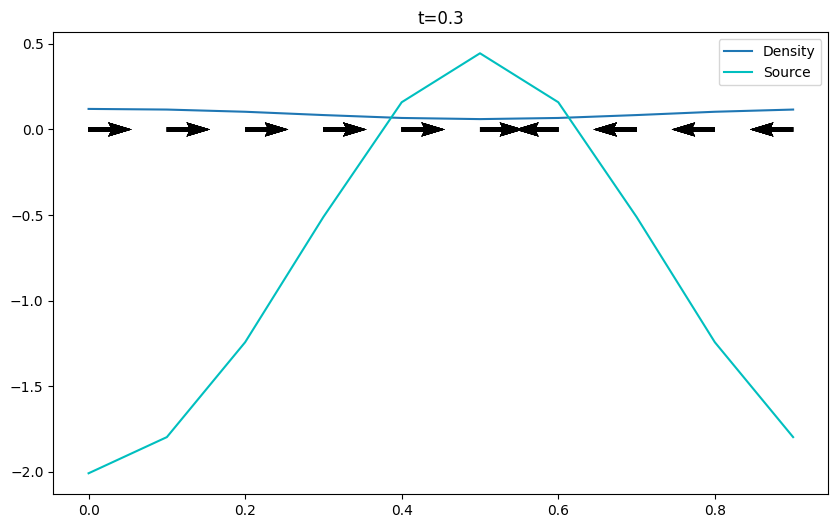

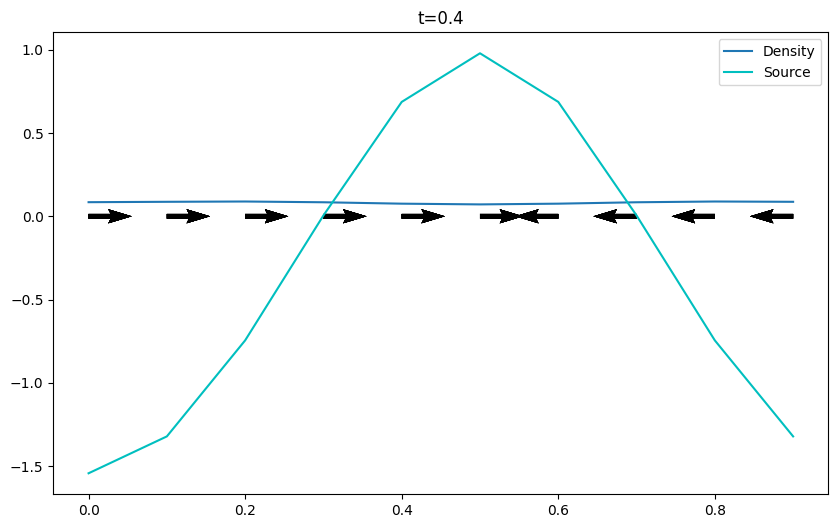

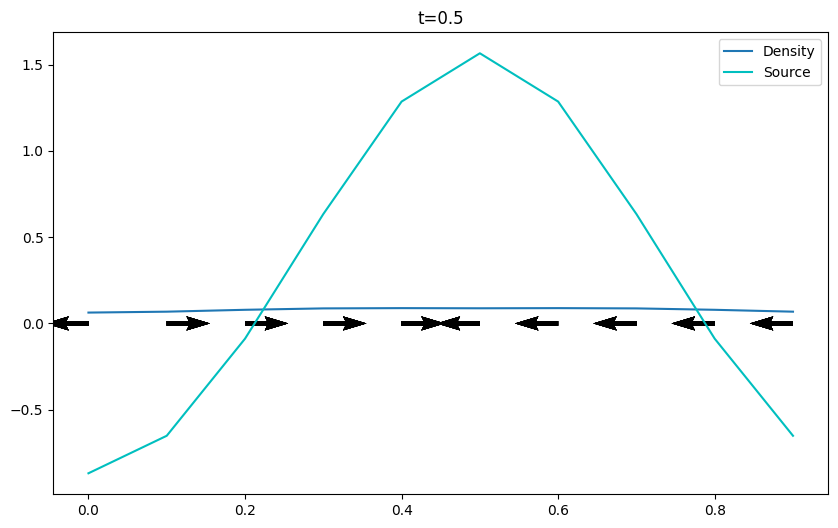

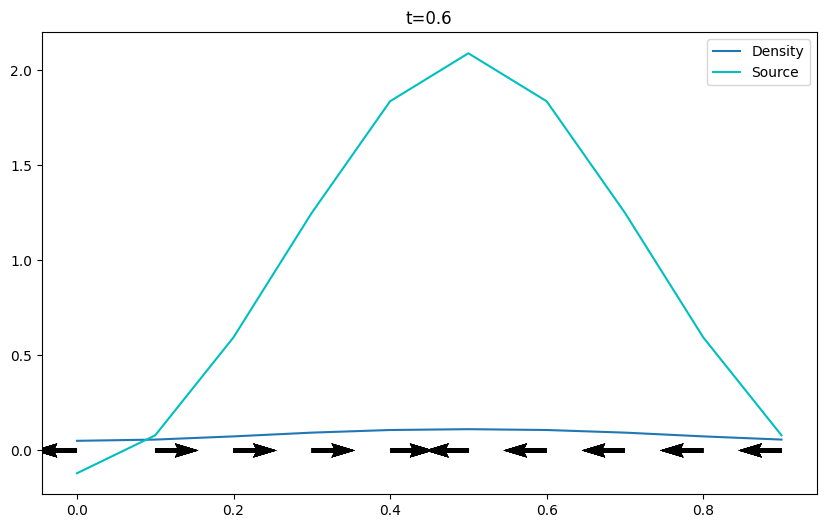

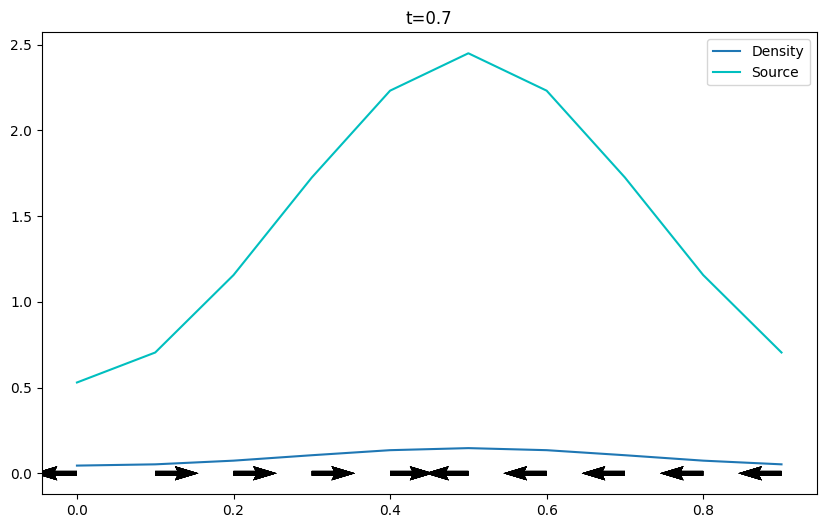

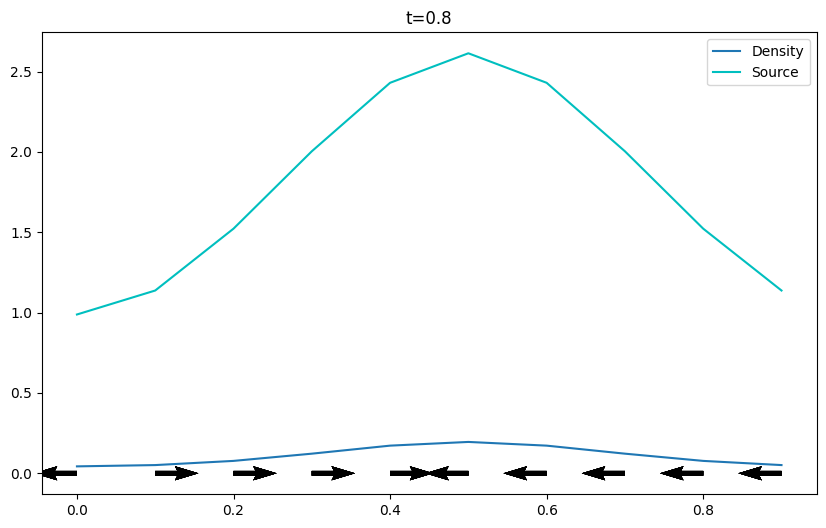

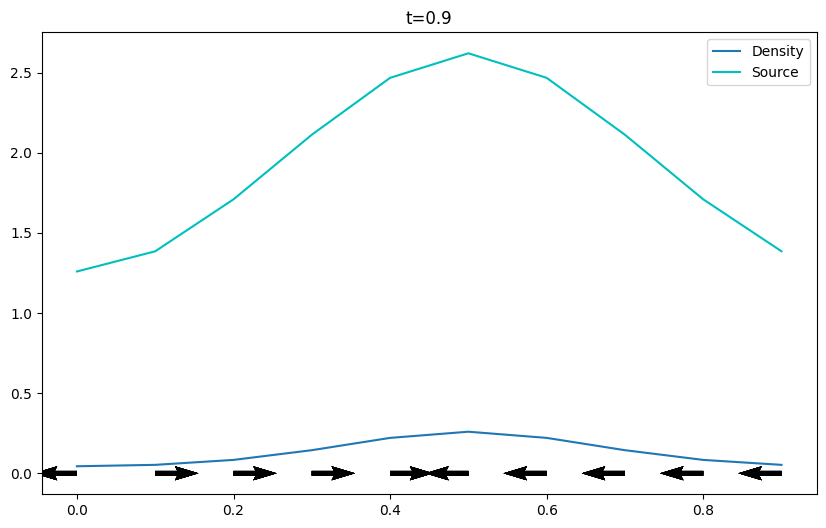

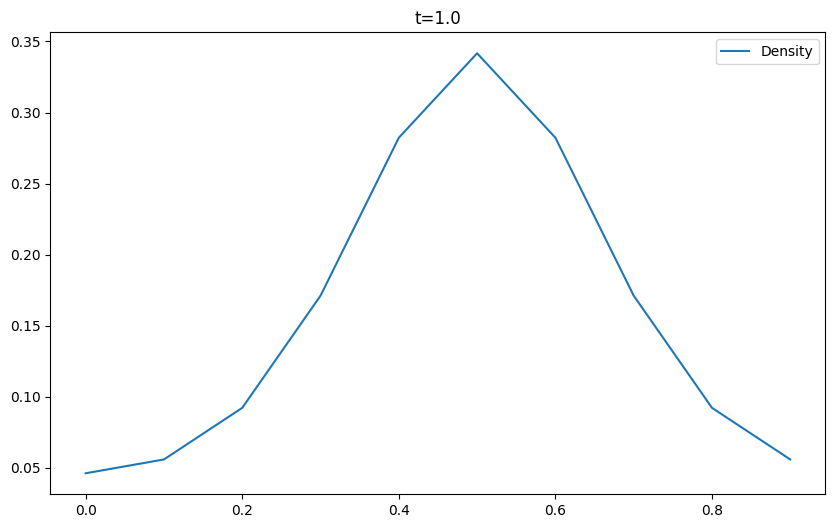

In [39]:
# Plotting
plot_p_1D_same(p, dx=dx, p2 = p2)
plot_pvz_1D(p, v, z)

## Example 11: The balanced transport with source. Verification of the conjecture.
Redo of Example 5.

rels: 1
rels: 2
rels: 3
rels: 4
rels: 5
rels: 6
rels: 7
rels: 8
rels: 9
rels: 10
rels: 11
rels: 12
rels: 13
rels: 14
rels: 15
rels: 16
rels: 17
rels: 18
rels: 19
rels: 20
rels: 21
rels: 22
rels: 23
rels: 24
rels: 25
rels: 26
rels: 27
rels: 28
rels: 29
rels: 30
rels: 31
rels: 32
rels: 33
rels: 34
rels: 35
rels: 36
rels: 37
rels: 38
rels: 39
rels: 40
rels: 41
rels: 42
rels: 43
rels: 44
rels: 45
rels: 46
rels: 47
rels: 48
rels: 49
rels: 50
rels: 51
rels: 52
rels: 53
rels: 54
rels: 55
rels: 56
rels: 57
rels: 58
rels: 59
rels: 60
rels: 61
rels: 62
rels: 63
rels: 64
rels: 65
rels: 66
rels: 67
rels: 68
rels: 69
rels: 70
rels: 71
rels: 72
rels: 73
rels: 74
rels: 75
rels: 76
rels: 77
rels: 78
rels: 79
rels: 80
rels: 81
rels: 82
rels: 83
rels: 84
rels: 85
rels: 86
rels: 87
rels: 88
rels: 89
rels: 90
rels: 91
rels: 92
rels: 93
rels: 94
rels: 95
rels: 96
rels: 97
rels: 98
rels: 99


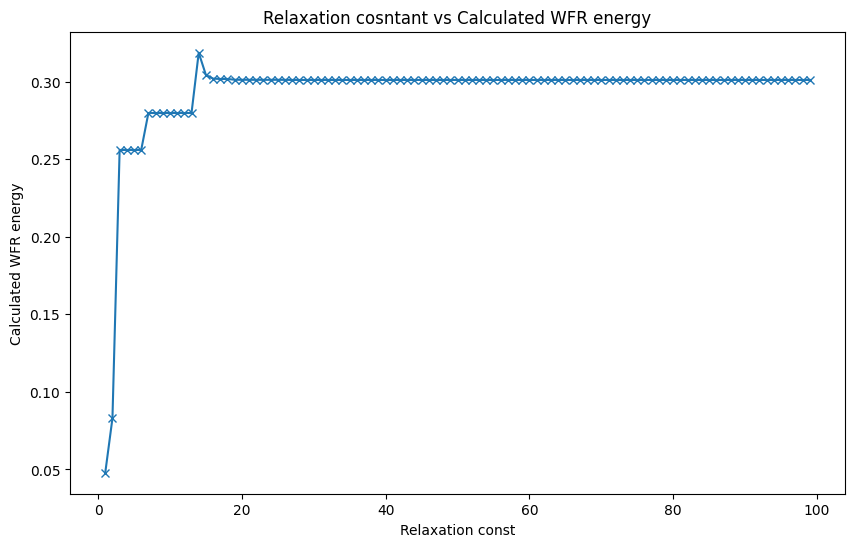

In [40]:
T = 10
N = 10
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 10)
p2 = von_mises_pdf(xs, 8*np.pi/5, 10)

wfrs = []
rels = np.arange(1, 100, 1)

v = None
z = None

for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=0.1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z)
    wfrs.append(float(wfr))

# Plottinga
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We notice that the calculated WFR is fairly stable. We will now see the plot of the solution at `rel`=100.

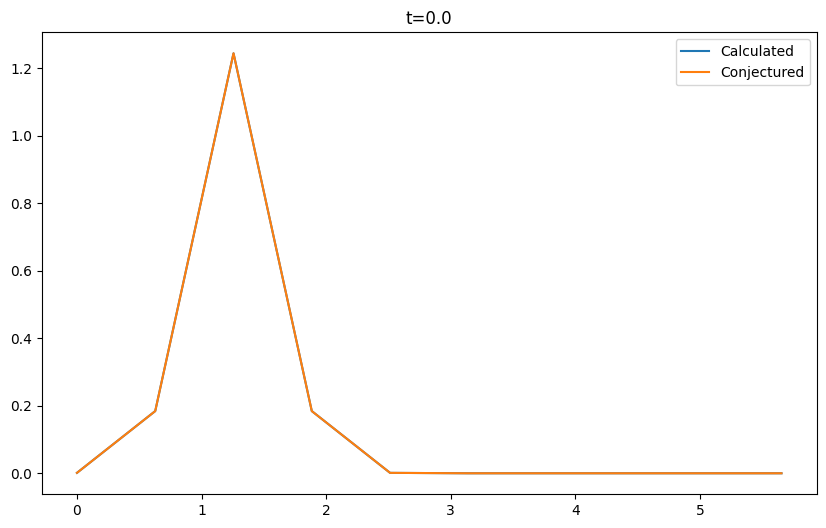

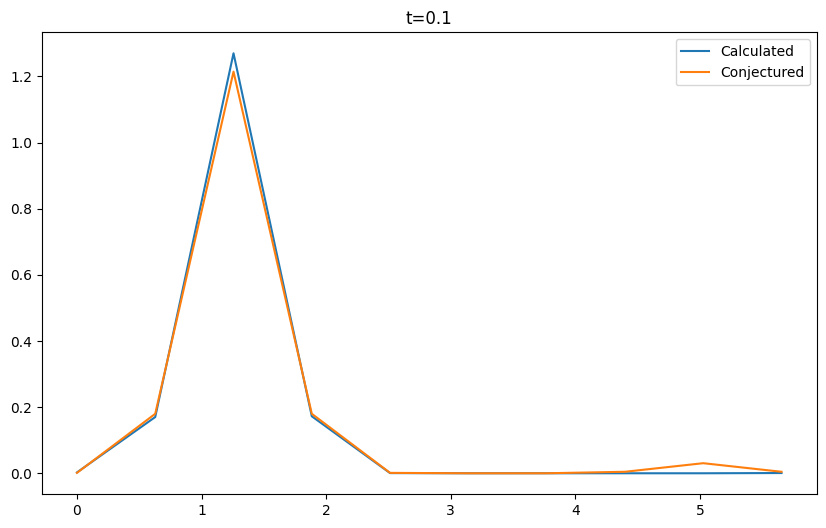

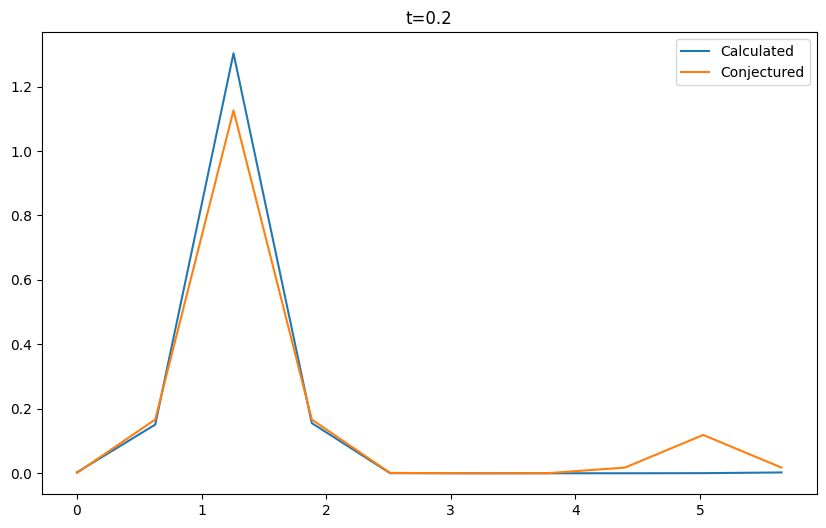

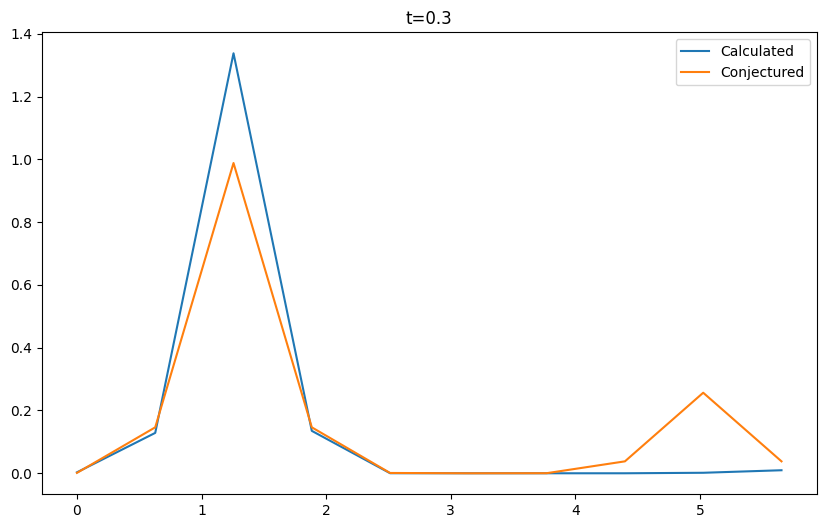

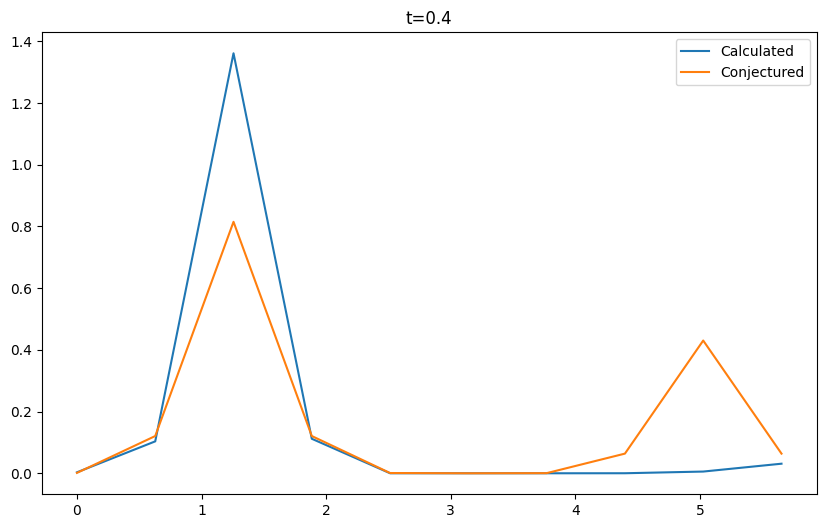

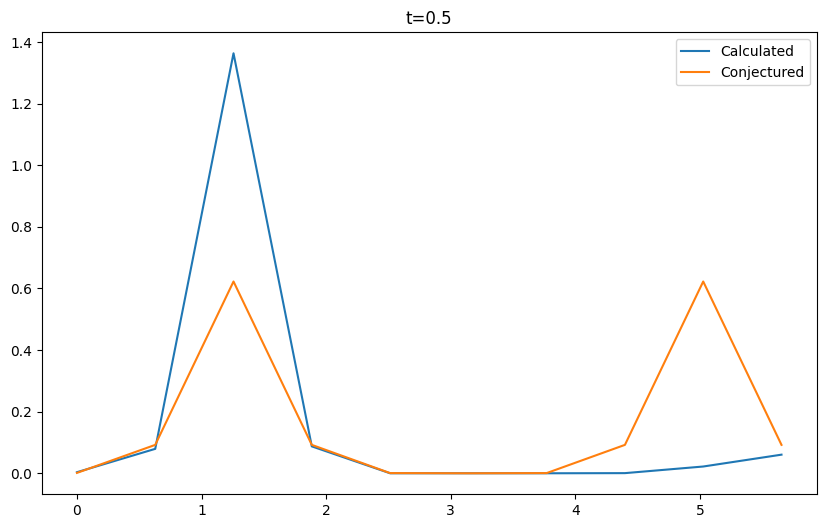

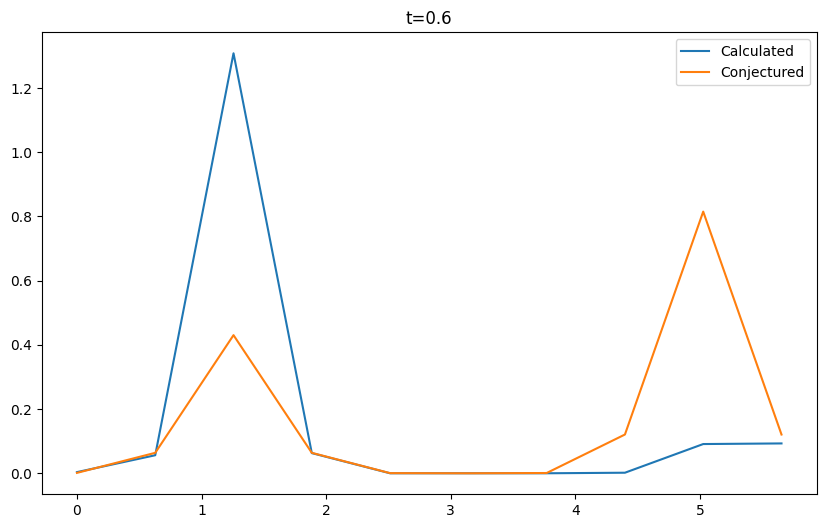

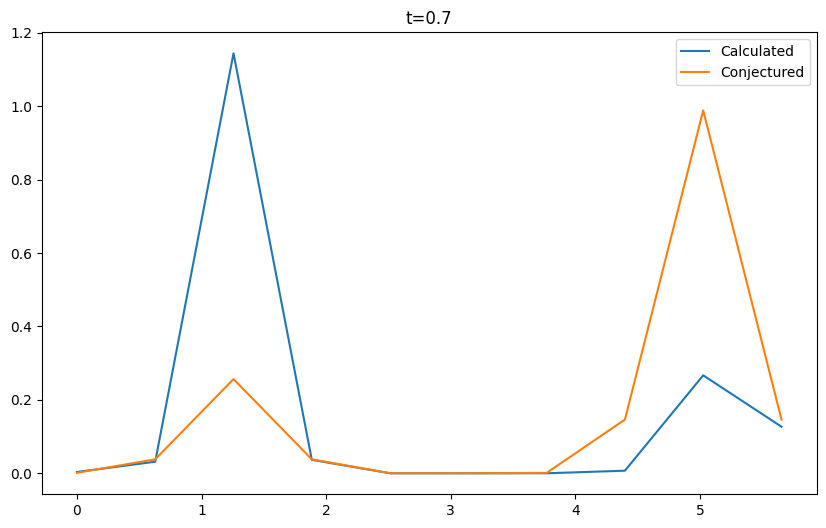

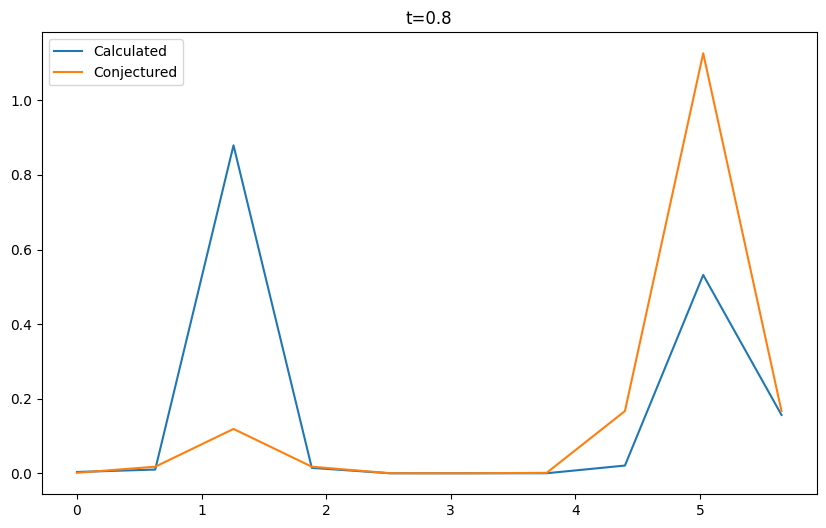

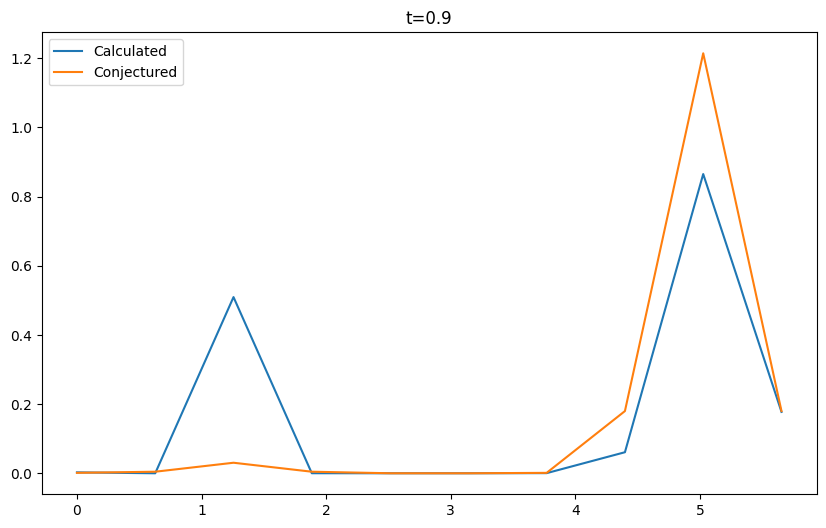

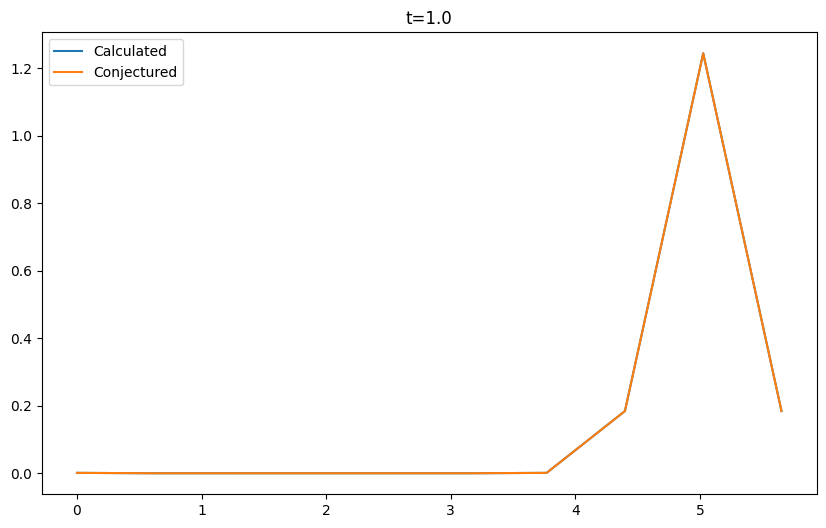

In [42]:
time_steps = p.shape[0]
space_steps = p.shape[-1]

for time_step in range(0, time_steps):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, p1*np.cos(np.pi*time/2.)**2+p2*np.sin(np.pi*time/2.)**2, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

The solution does not quite match, but adding a small mass to both p1 and p2 improves the behavior.

rels: 1
rels: 2
rels: 3
rels: 4
rels: 5
rels: 6
rels: 7
rels: 8
rels: 9
rels: 10
rels: 11
rels: 12
rels: 13
rels: 14
rels: 15
rels: 16
rels: 17
rels: 18
rels: 19
rels: 20
rels: 21
rels: 22
rels: 23
rels: 24
rels: 25
rels: 26
rels: 27
rels: 28
rels: 29
rels: 30
rels: 31
rels: 32
rels: 33
rels: 34
rels: 35
rels: 36
rels: 37
rels: 38
rels: 39
rels: 40
rels: 41
rels: 42
rels: 43
rels: 44
rels: 45
rels: 46
rels: 47
rels: 48
rels: 49
rels: 50
rels: 51
rels: 52
rels: 53
rels: 54
rels: 55
rels: 56
rels: 57
rels: 58
rels: 59
rels: 60
rels: 61
rels: 62
rels: 63
rels: 64
rels: 65
rels: 66
rels: 67
rels: 68
rels: 69
rels: 70
rels: 71
rels: 72
rels: 73
rels: 74
rels: 75
rels: 76
rels: 77
rels: 78
rels: 79
rels: 80
rels: 81
rels: 82
rels: 83
rels: 84
rels: 85
rels: 86
rels: 87
rels: 88
rels: 89
rels: 90
rels: 91
rels: 92
rels: 93
rels: 94
rels: 95
rels: 96
rels: 97
rels: 98
rels: 99


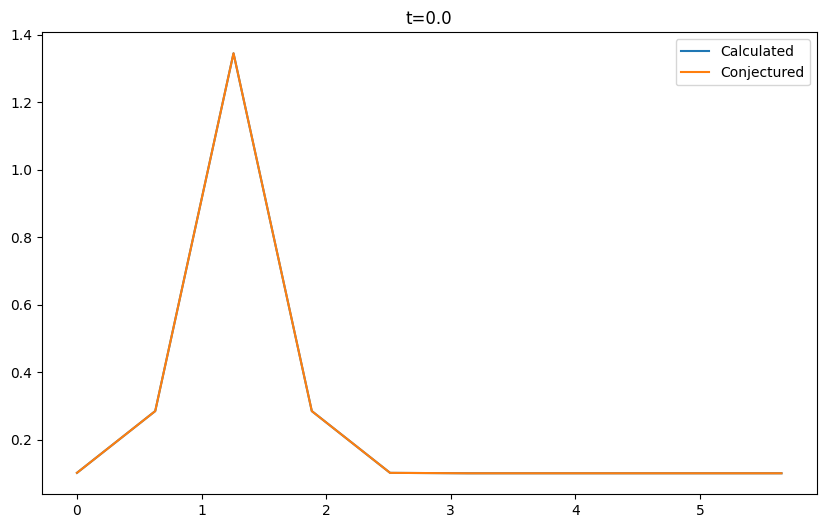

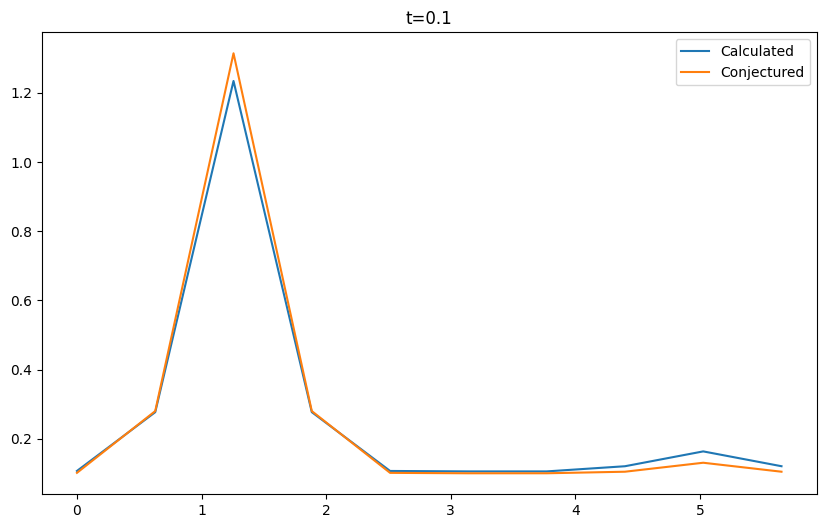

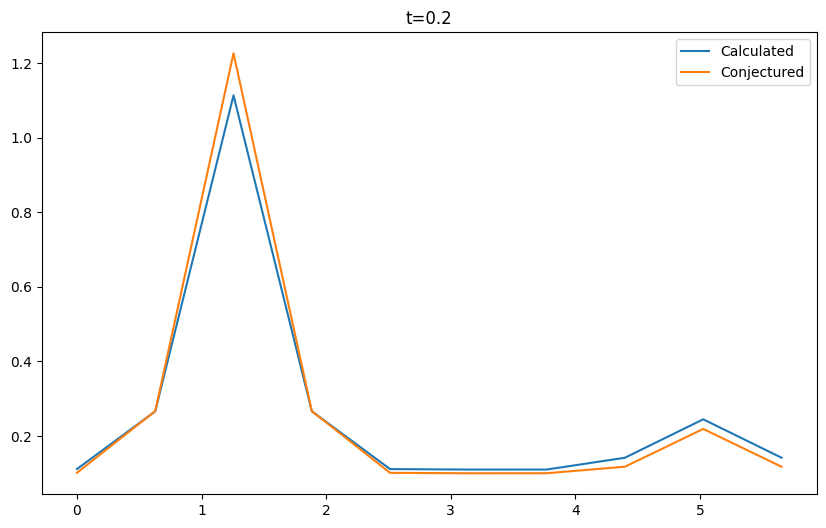

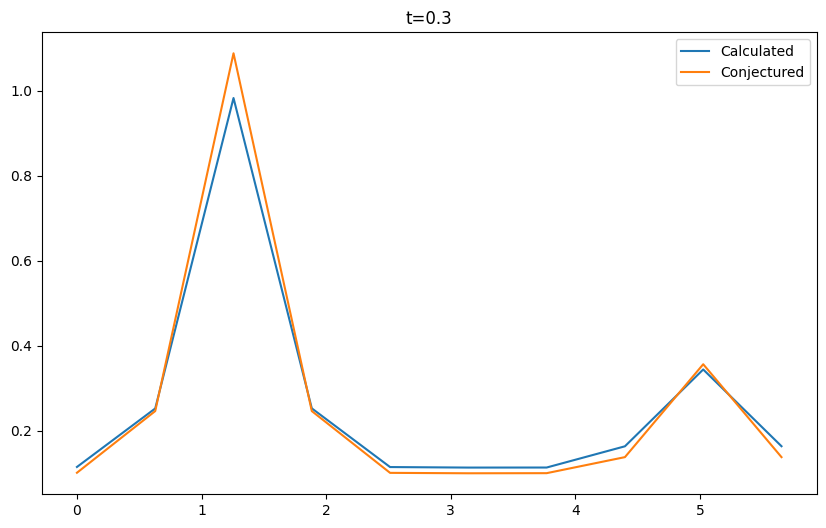

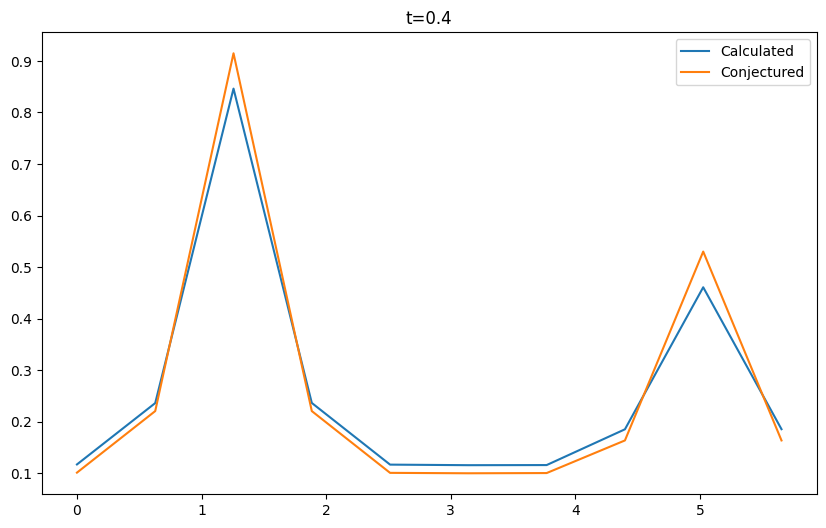

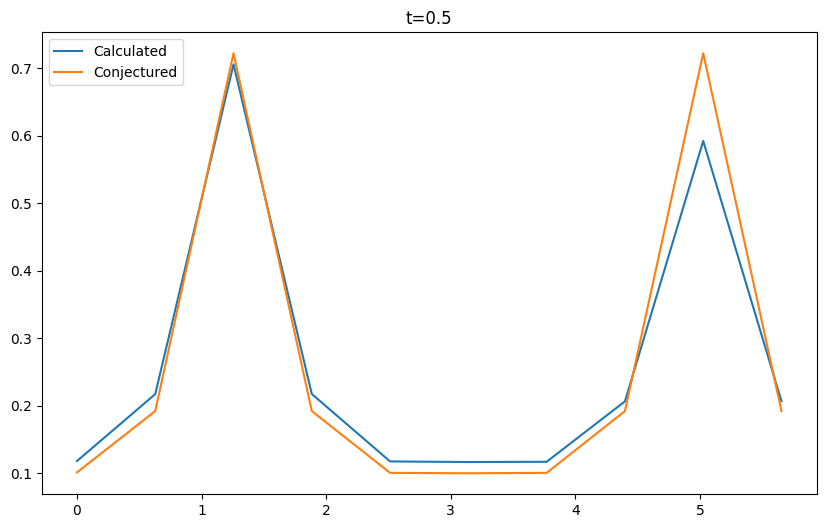

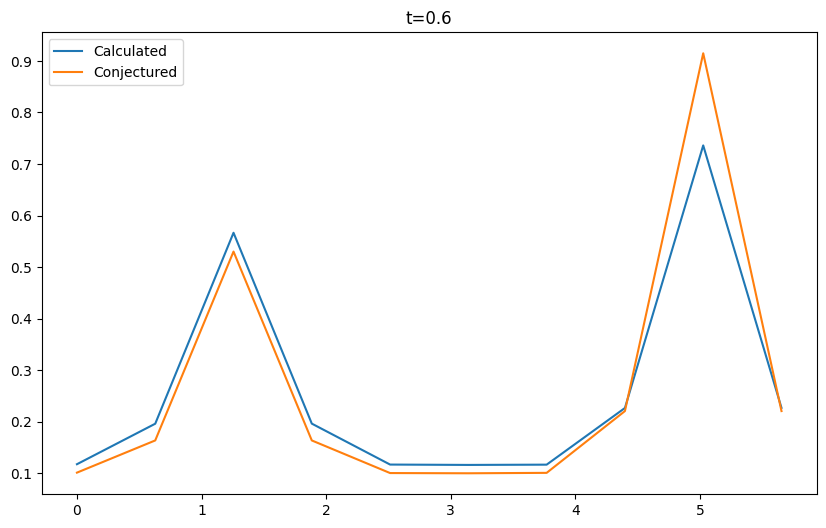

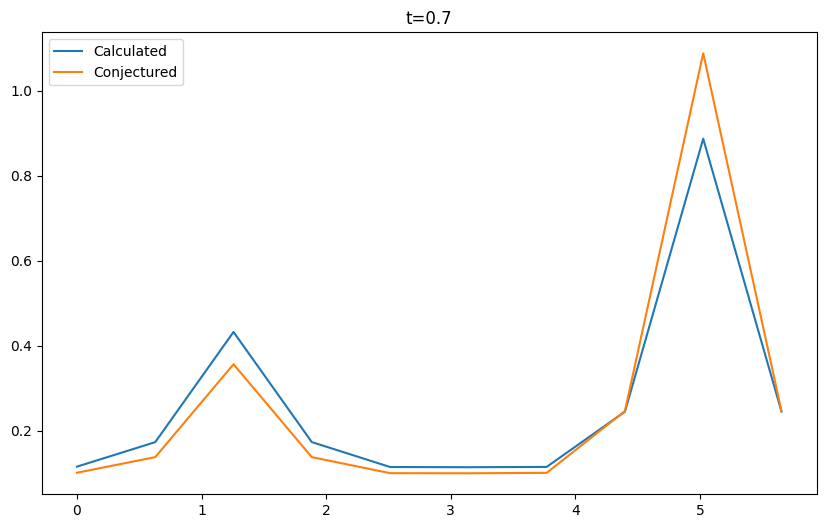

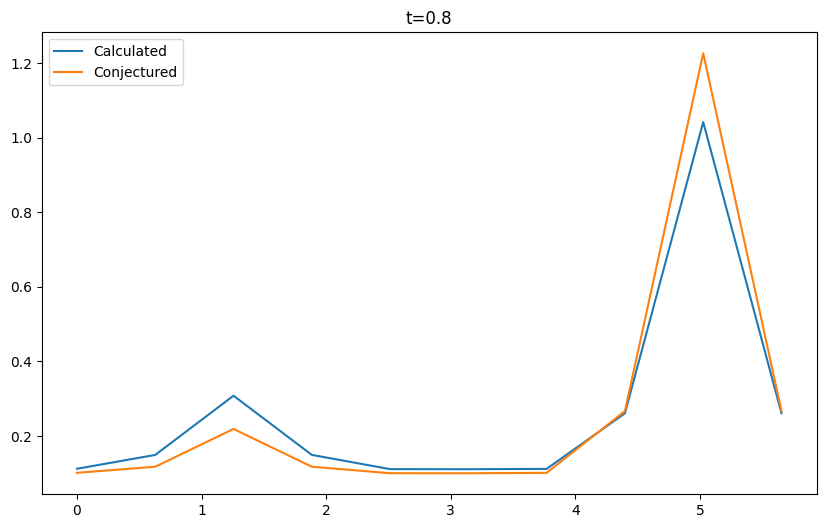

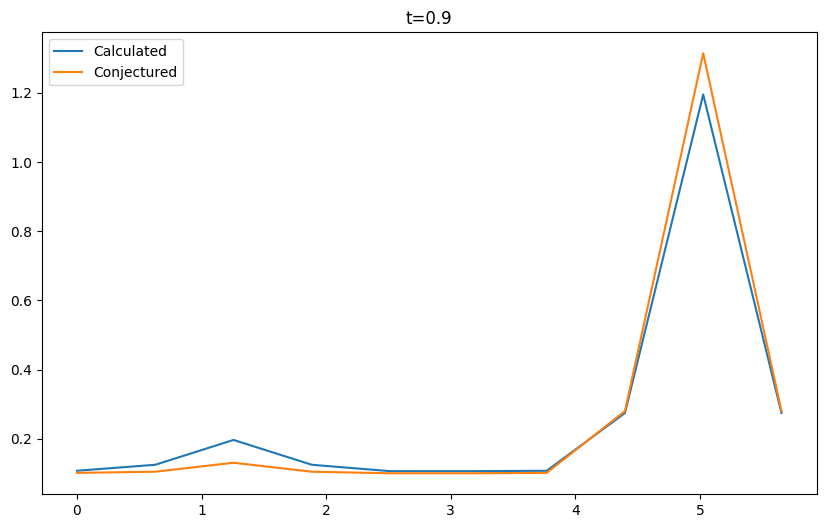

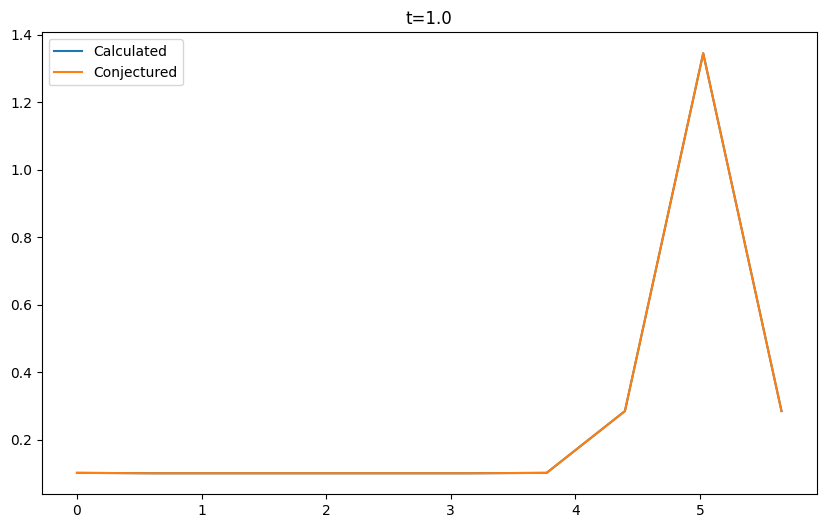

In [4]:
T = 10
N = 10
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 10)+0.1
p2 = von_mises_pdf(xs, 8*np.pi/5, 10)+0.1

wfrs = []
rels = np.arange(1, 100, 1)

v = None
z = None

for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=0.1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z)
    wfrs.append(float(wfr))

time_steps = p.shape[0]
space_steps = p.shape[-1]

for time_step in range(0, time_steps):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, p1*np.cos(np.pi*time/2.)**2+p2*np.sin(np.pi*time/2.)**2, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

We will now do the experiment with larger `T,N` to see if the oscillating behavior still occurs in the solution.

In [26]:
T = 500
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 700)+0.1
p2 = von_mises_pdf(xs, 8*np.pi/5, 700)+0.1

wfrs = []
rels = np.arange(1000, 6000, 1000)

v = None
z = None

for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=0.1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z)
    wfrs.append(float(wfr))


rels: 1000
rels: 2000
rels: 3000
rels: 4000
rels: 5000


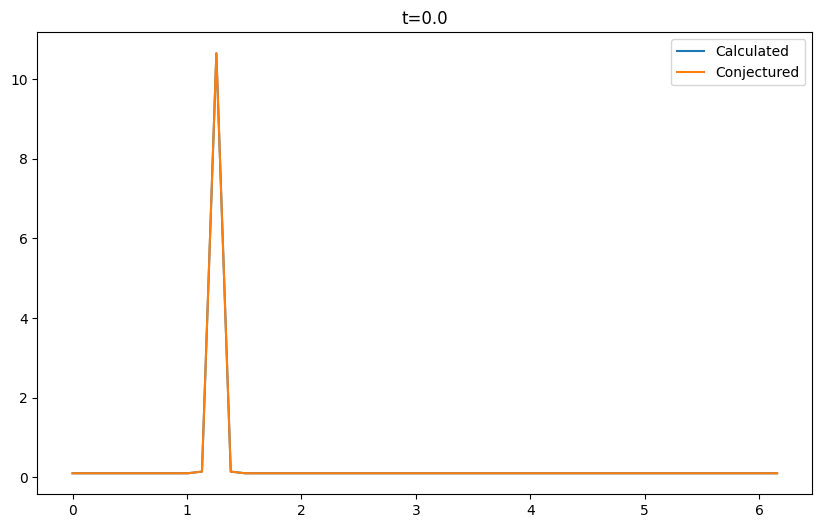

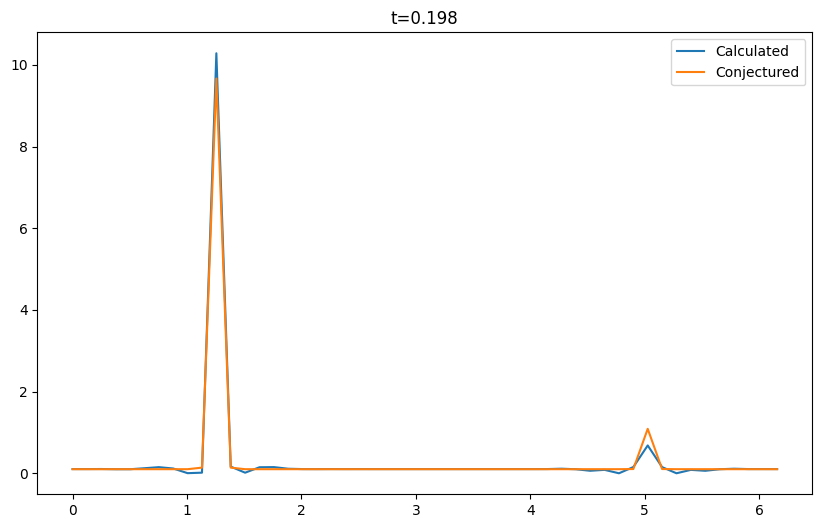

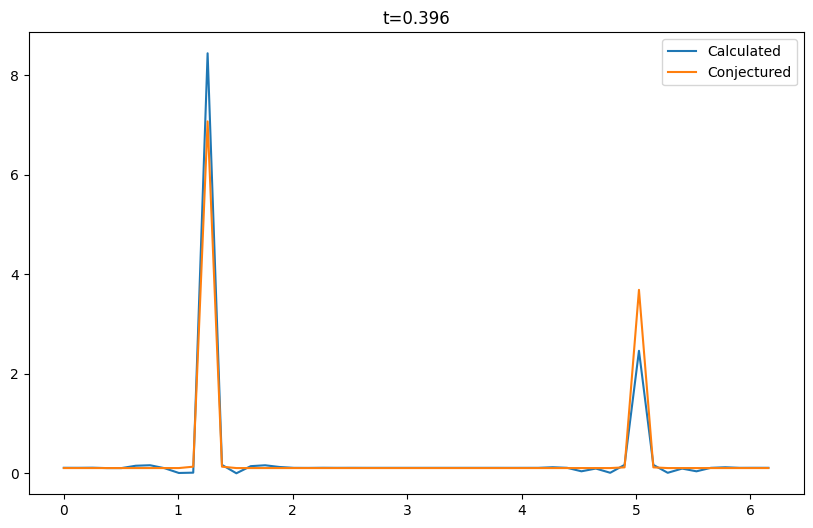

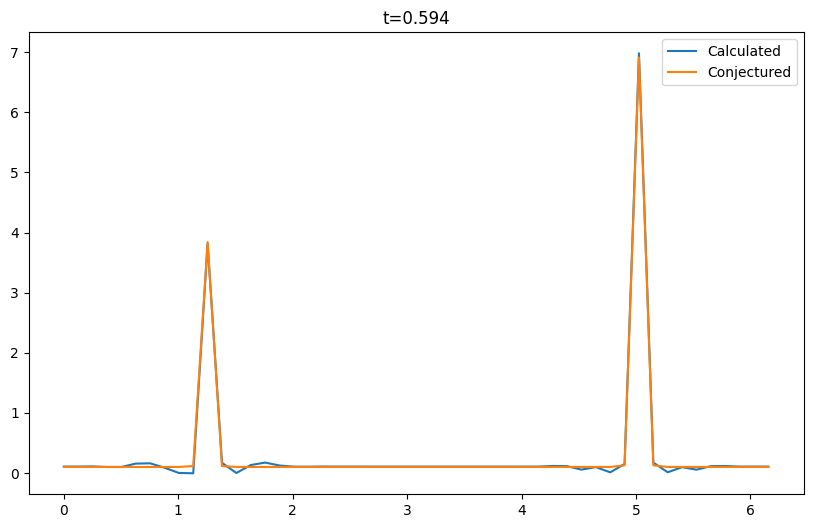

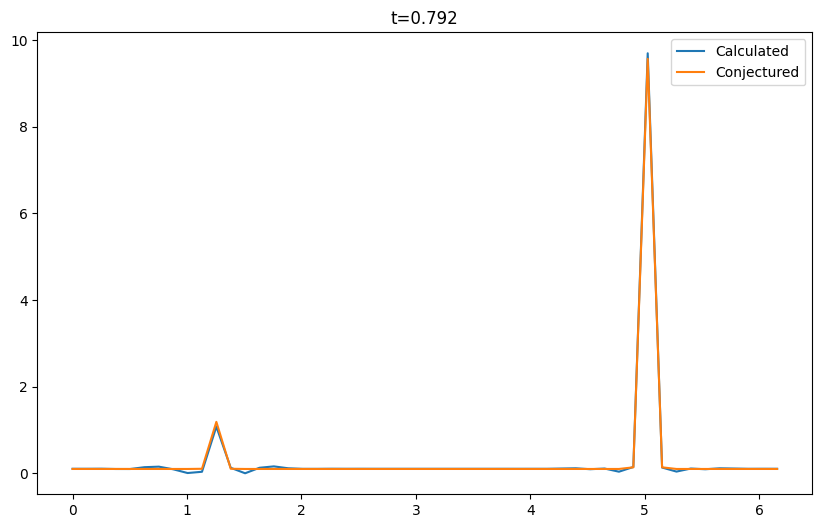

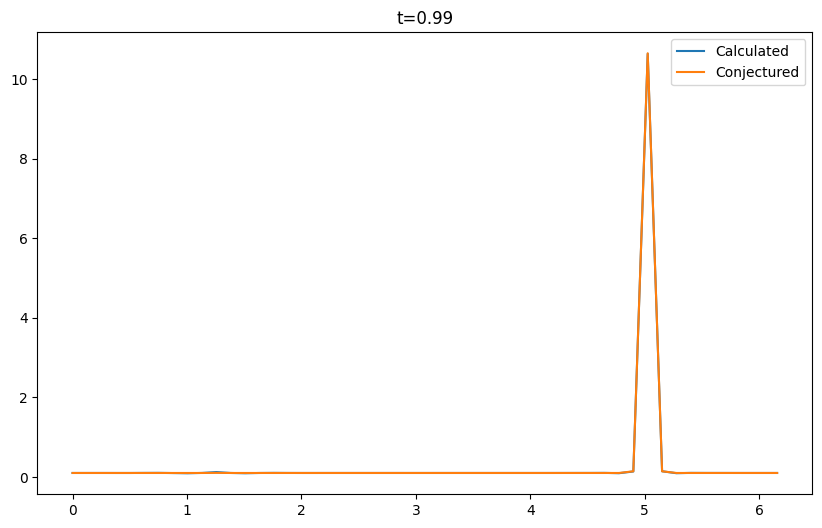

In [28]:
time_steps = p.shape[0]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, p1*np.cos(np.pi*time/2.)**2+p2*np.sin(np.pi*time/2.)**2, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

# Example 12 The balanced transport of a travelling Dirac.

In this example, we will verify another conjecture regarding the transporting Dirac. In the paper, The minimal energy path between Diracs located at $x_0$ and $x_1$ under the constraint $\rho_t(\Omega)=F(t)$ is conjectured to be $\rho=F(t)\delta_{x(t)}$ where
$\begin{equation} x(t) = \frac{\|x_1-x_0\|^2}{2\int_0^1 1/F(s) \, ds} +\frac{\delta^2}{2} \int_0^1 \frac{F'(t)^2}{F(t)} \, dt.\end{equation}$ when $\|x_1-x_0\|<\pi \delta$. We will set $F(t)=1, x_0=\pi-0.1$ and $x_1=\pi+0.1$ to observe if the conjecture is valid.

In [4]:
T = 500
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, np.pi-0.5, 700)+0.1
p2 = von_mises_pdf(xs, np.pi+0.5, 700)+0.1

wfrs = []
rels = np.arange(1000, 6000, 1000)

v = None
z = None

for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z)
    wfrs.append(float(wfr))


rels: 1000
rels: 2000
rels: 3000
rels: 4000
rels: 5000


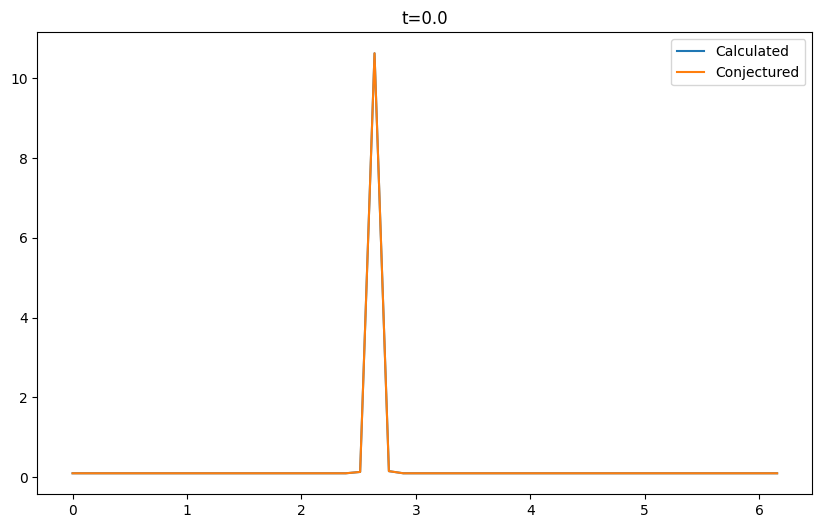

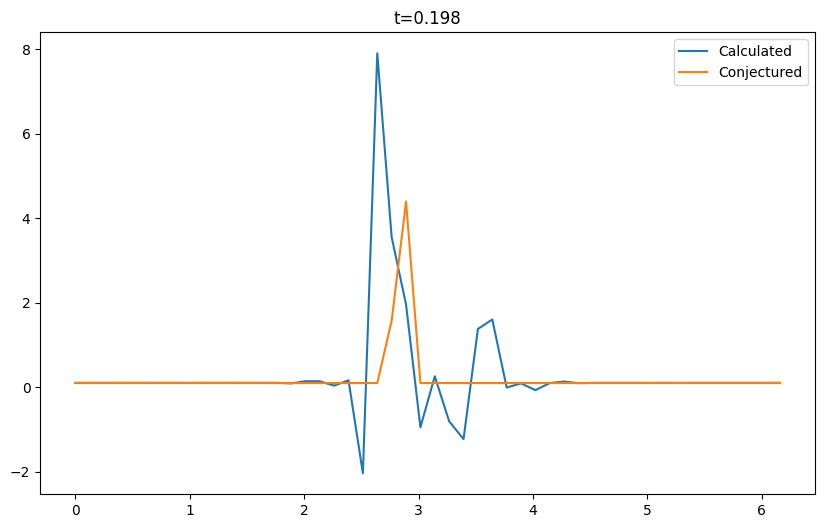

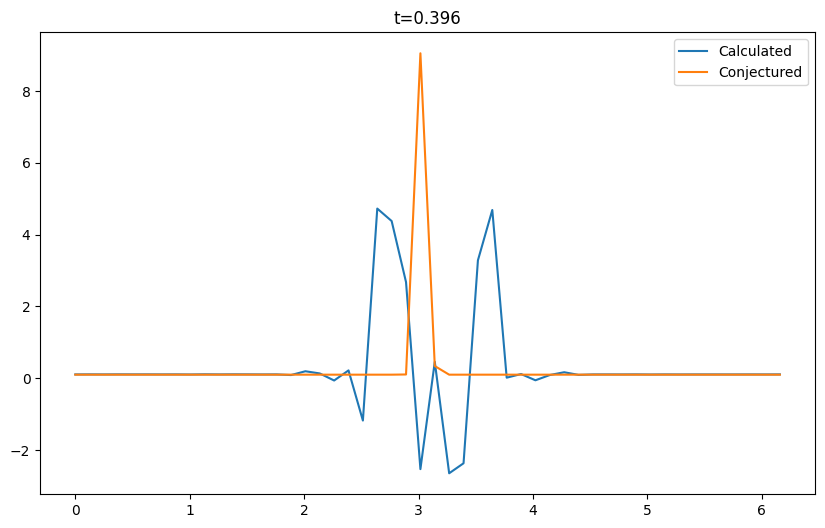

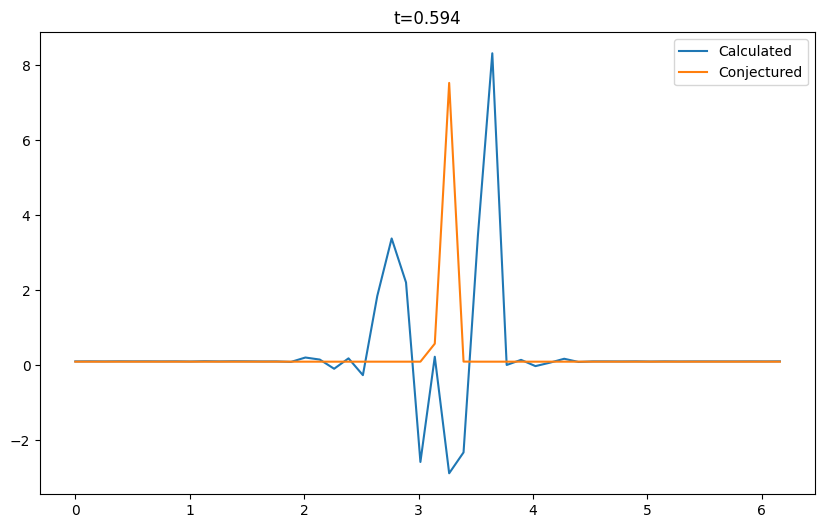

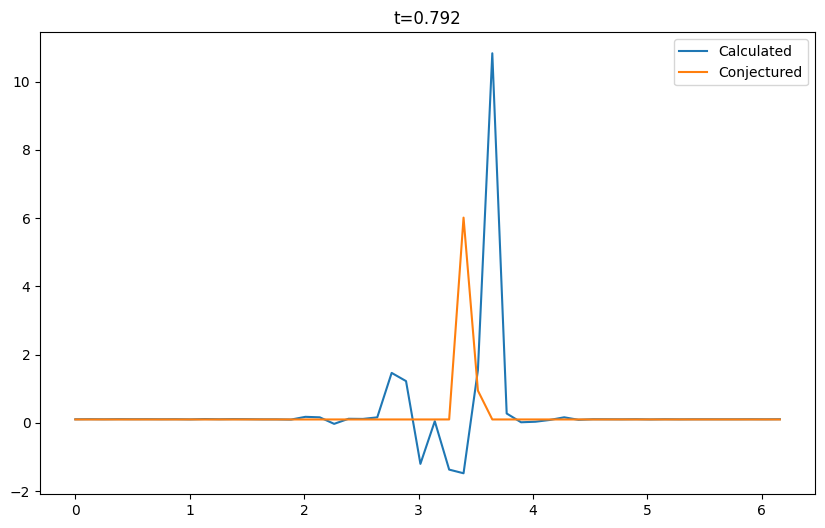

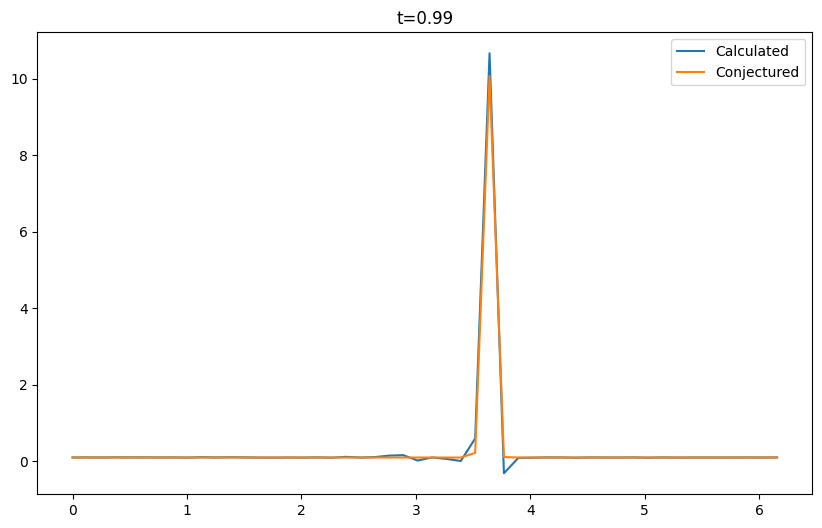

In [6]:
time_steps = p.shape[0]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, von_mises_pdf(xs, np.pi-0.5+time, 700)+0.1, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

# Example 11.1 Initializing by the conjectured solution
Continuing the previous example, we initialize the solver by the conjectured solution. We have $\rho=\delta_{x(t)}\otimes dt$ wih $x(t)=x_0+t(x_1-x_0)$, so we have $\omega = x'(t)\delta_{x(t)} = (x_1-x_0)\delta_{x(t)}\otimes dt,\zeta=0$. 

In [10]:
T = 500
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, np.pi-0.5, 700)+0.1
p2 = von_mises_pdf(xs, np.pi+0.5, 700)+0.1


wfrs = []
rels = np.arange(1000, 6000, 1000)
v = np.ones((T, N, 1))*0.3
z = None
for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z)
    wfrs.append(float(wfr))


rels: 1000
rels: 2000
rels: 3000
rels: 4000
rels: 5000


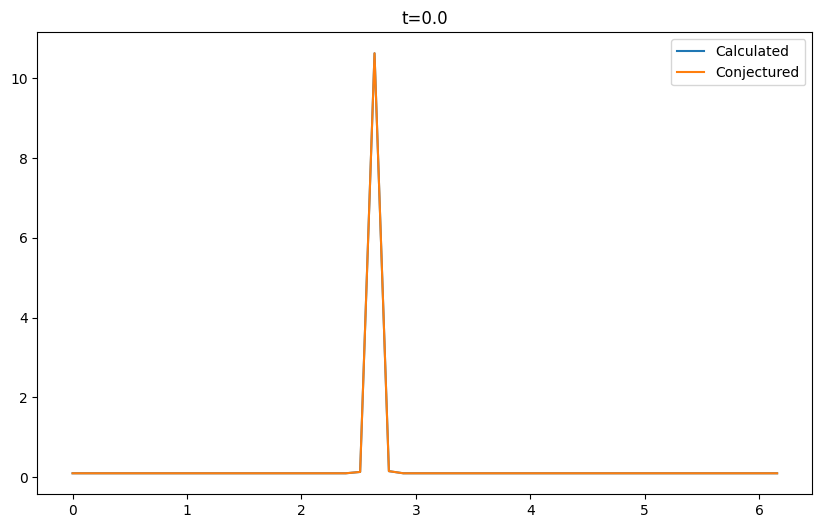

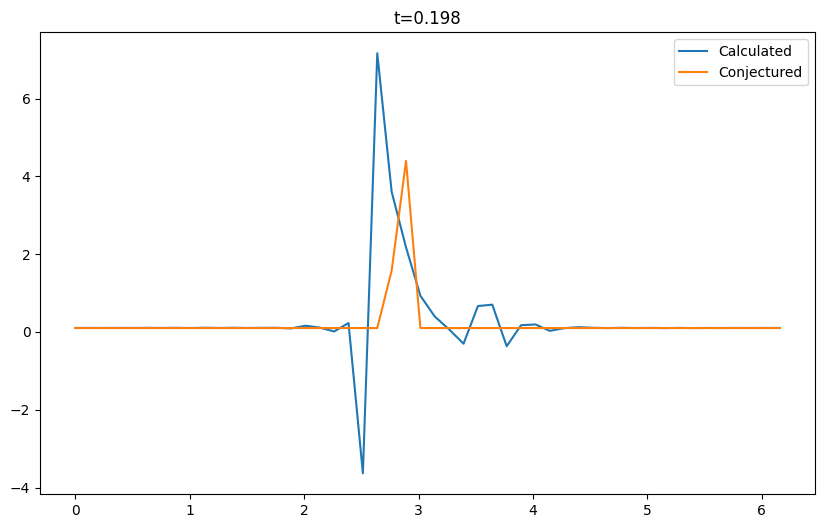

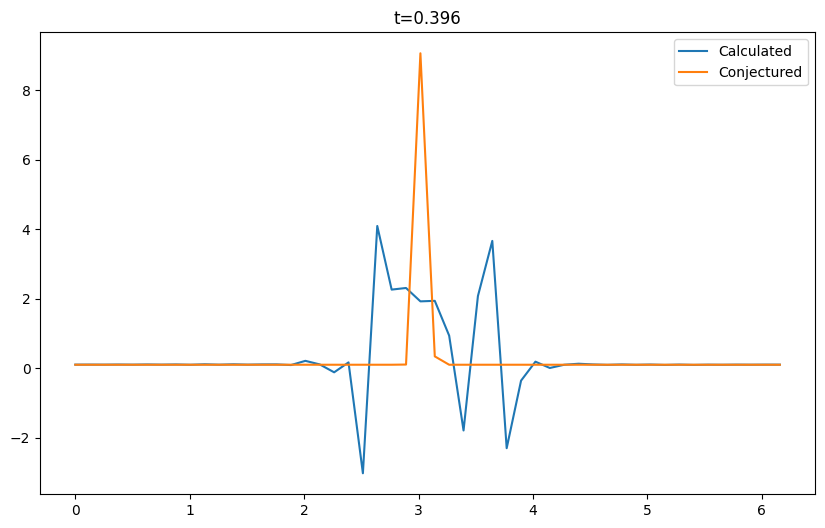

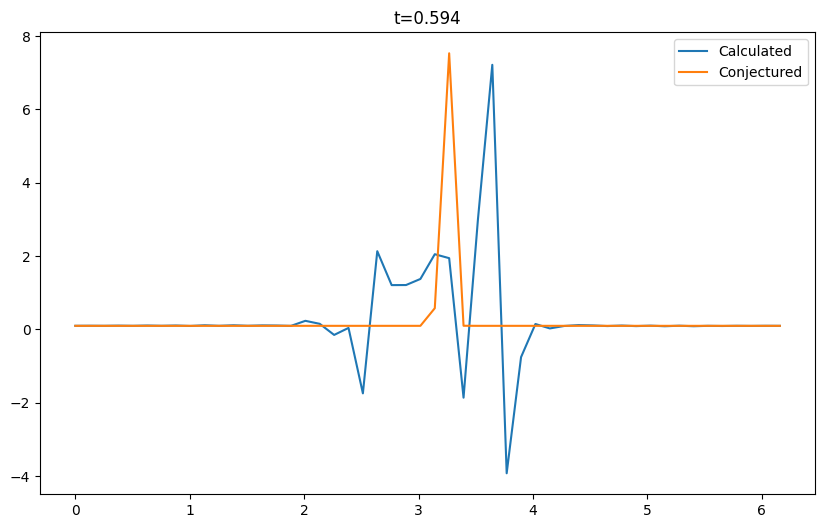

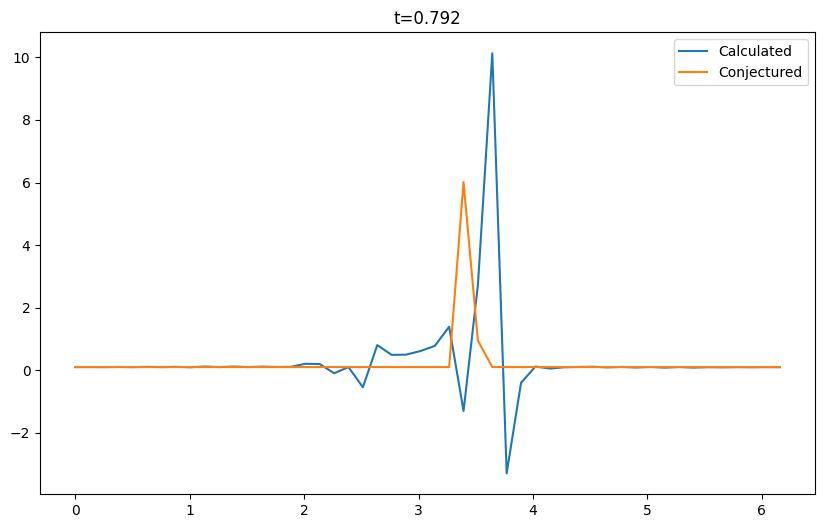

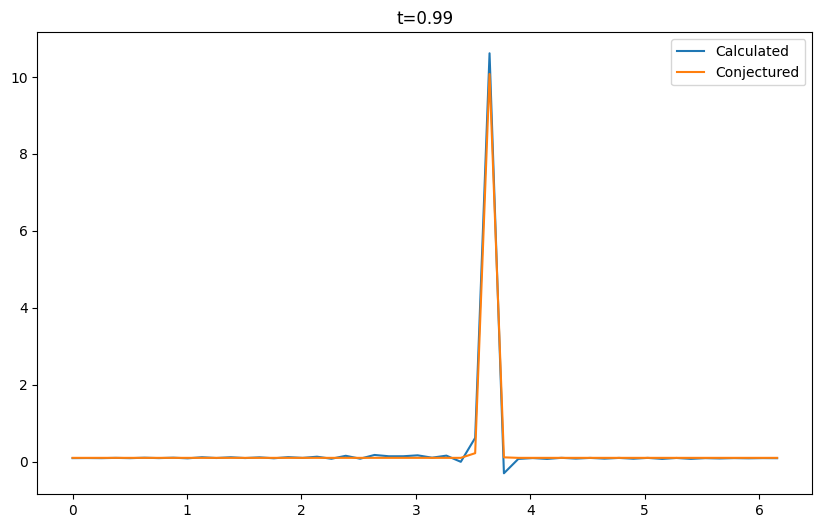

In [11]:
time_steps = p.shape[0]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, von_mises_pdf(xs, np.pi-0.5+time, 700)+0.1, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

In [4]:
T = 500
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, np.pi-0.5, 700)+0.1
p2 = von_mises_pdf(xs, np.pi+0.5, 700)+0.1

wfrs = []
rels = np.arange(1000, 6000, 1000)
v = np.ones((T, N, 1))
z = None
for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z)
    wfrs.append(float(wfr))


rels: 1000
rels: 2000
rels: 3000
rels: 4000
rels: 5000


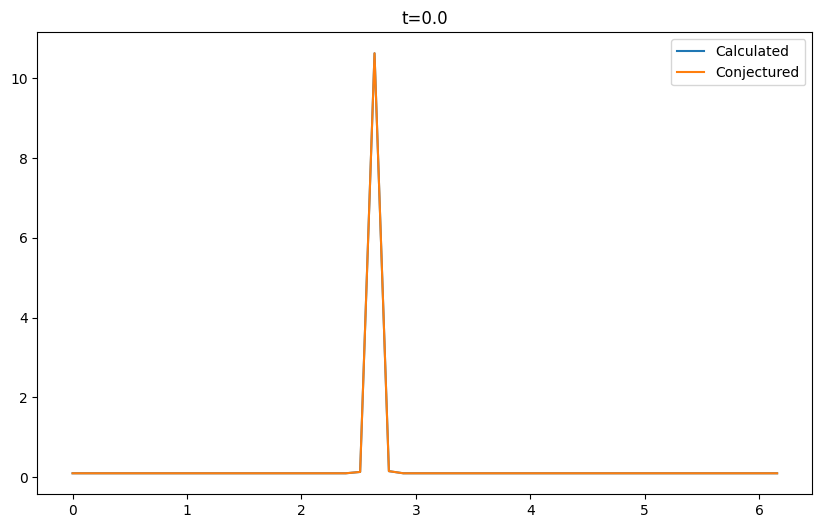

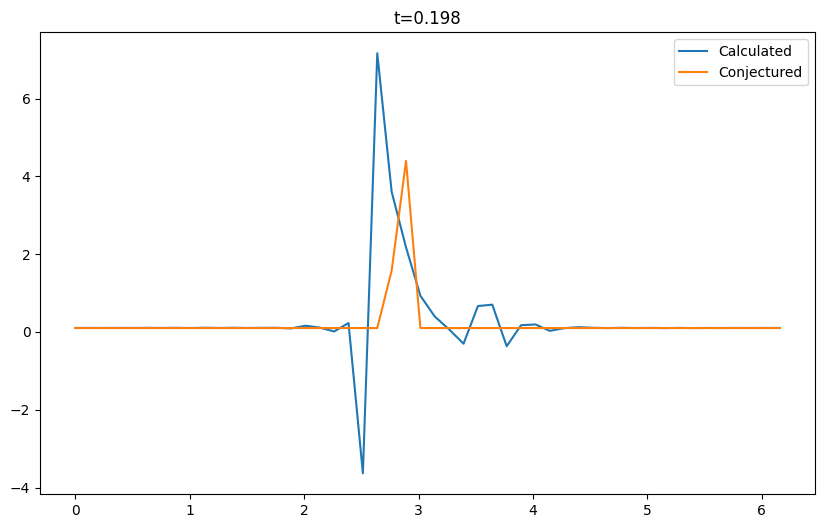

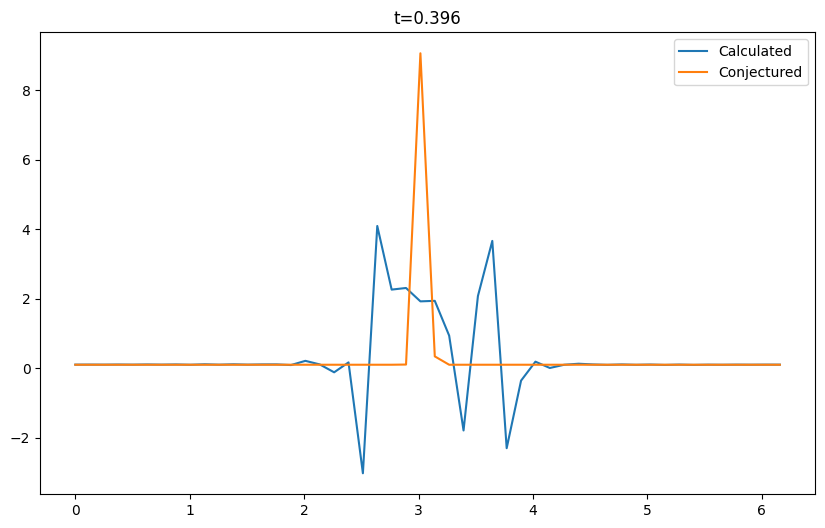

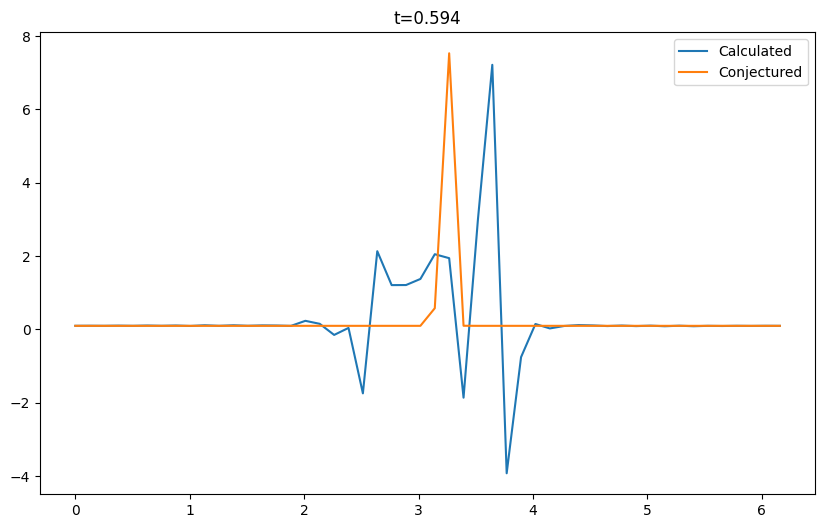

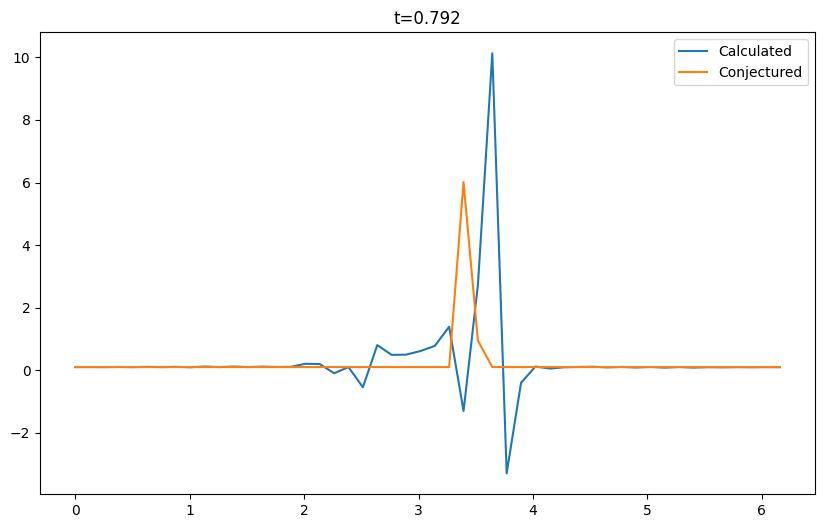

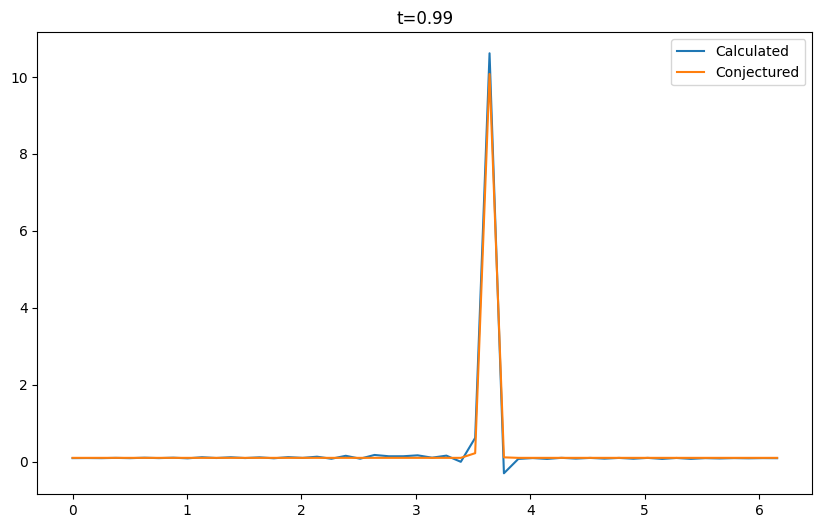

In [5]:
time_steps = p.shape[0]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, von_mises_pdf(xs, np.pi-0.5+time, 700)+0.1, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

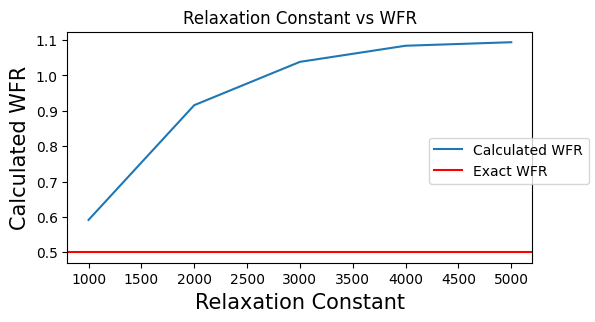

In [9]:
# Plotting WFRs
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(rels, wfrs, label='Calculated WFR')
ax1.axhline(y=0.5, color='r', linestyle='-', label = 'Exact WFR')
ax1.set_xlabel('Relaxation Constant', fontsize = '15')
ax1.set_ylabel('Calculated WFR', fontsize = '15')
ax1.set_title('Relaxation Constant vs WFR')
fig.legend(loc ='center right')
plt.show()

In [17]:
T = 500
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, np.pi-0.5, 700)+0.1
p2 = von_mises_pdf(xs, np.pi+0.5, 700)+0.1

wfrs = []
rels = np.arange(1000, 6000, 1000)
v = np.ones((T, N, 1))
z = np.zeros((T,N))

In [2]:
import math
import functools
import torchdiffeq
spatial_dim =1
H_torch = torch.from_numpy(H)

# Forward difference in time
Fprime = T * (np.roll(F, -1) - F)
Fprime_torch = torch.from_numpy(Fprime)

# Forward difference in time
dHdt = T * (np.roll(H, -1, 0) - H)
dHdt_torch = torch.from_numpy(dHdt)

# Central difference in space
gradH = [
    (np.roll(H, -1, i + 1) - np.roll(H, 1, i + 1)) / (2 * dx[i])
    for i in range(spatial_dim)
]

gradH_torch = [torch.from_numpy(component) for component in gradH]

p1_torch = torch.tensor(p1)

wfrs = []

def collect_wfr(_vz: np.ndarray):
    _v = torch.tensor(_vz[: math.prod(v.shape)].reshape(v.shape))
    _z = torch.tensor(_vz[math.prod(v.shape) :].reshape(z.shape))
    divpz = functools.partial(
    _div_plus_pz_grid,
    v=_v,
    z=_z,
    dx=dx,
    T=T,
    H=H_torch,
    Fprime=Fprime_torch,
    dHdt=dHdt_torch,
    gradH=gradH_torch,
    scheme='central',
    )
    _p = torchdiffeq.odeint(
            divpz,
            p1_torch,
            torch.linspace(0, 1, steps=T + 1),
            method='euler',
        )
    _v, _z = _batch_project_affine(
        _p, _v, _z, H_torch, dHdt_torch, gradH_torch, Fprime_torch, dx
    )
    wfr_energy = torch.sqrt(
        0.5 * _WFR_energy(_p[:-1], _v, _z, 1.) * math.prod(dx) * (1./T)
    ).numpy()
    wfrs.append(float(wfr_energy))

NameError: name 'H' is not defined

In [13]:
for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z, callback=collect_wfr)

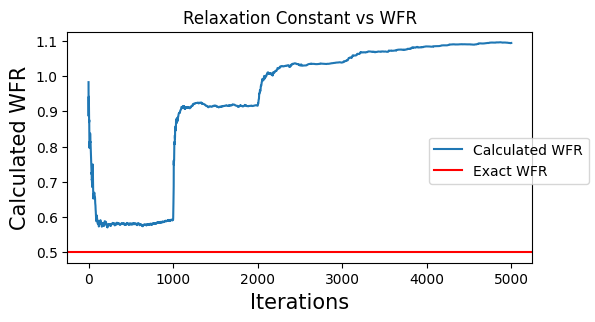

In [16]:
# Plotting WFRs
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(range(5000), wfrs, label='Calculated WFR')
ax1.axhline(y=0.5, color='r', linestyle='-', label = 'Exact WFR')
ax1.set_xlabel('Iterations', fontsize = '15')
ax1.set_ylabel('Calculated WFR', fontsize = '15')
ax1.set_title('Relaxation Constant vs WFR')
fig.legend(loc ='center right')
plt.show()

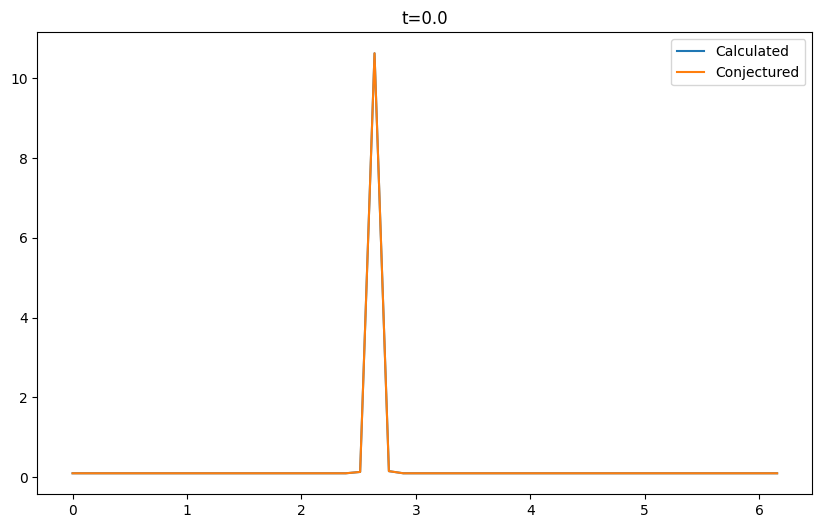

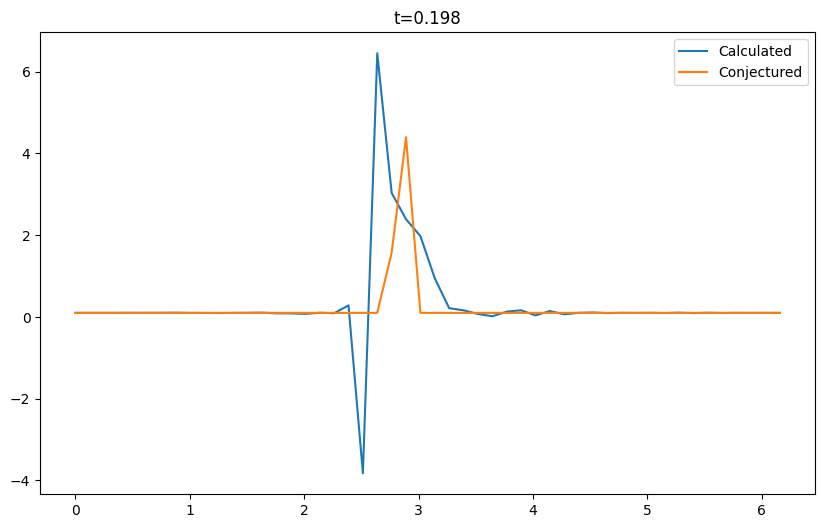

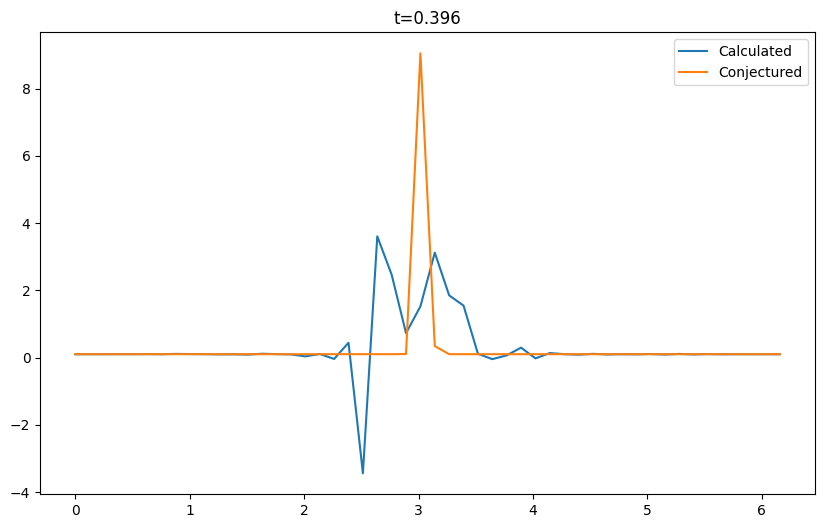

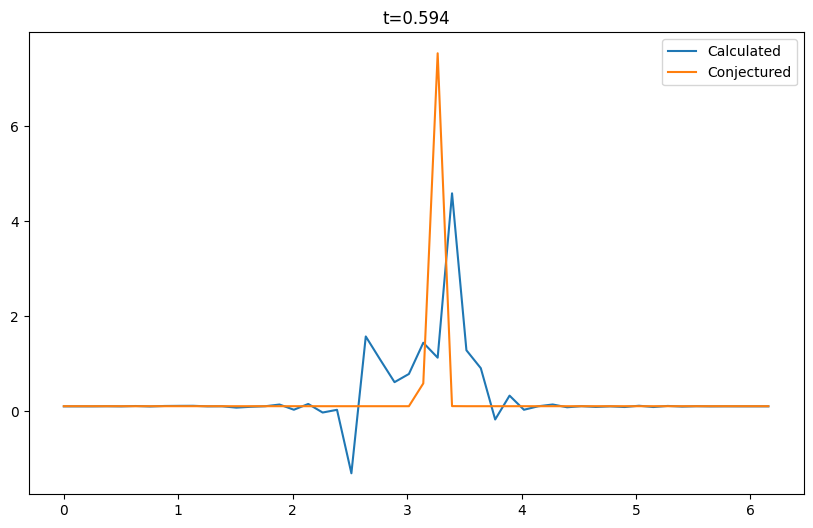

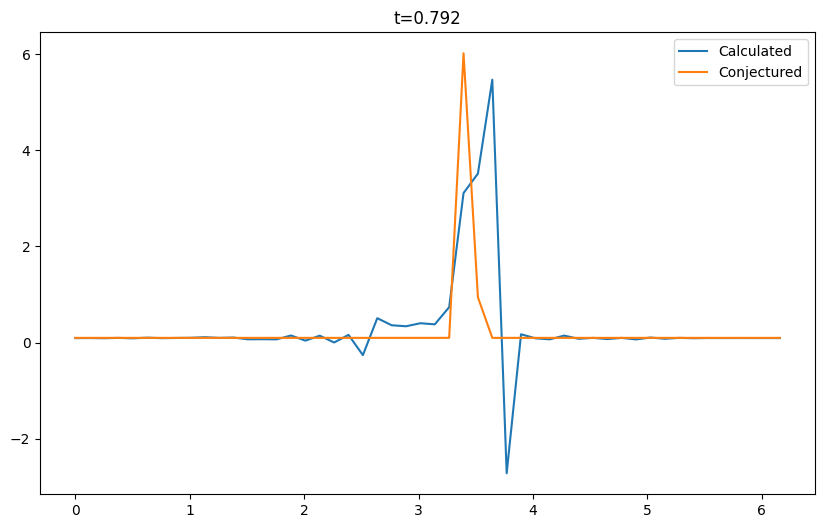

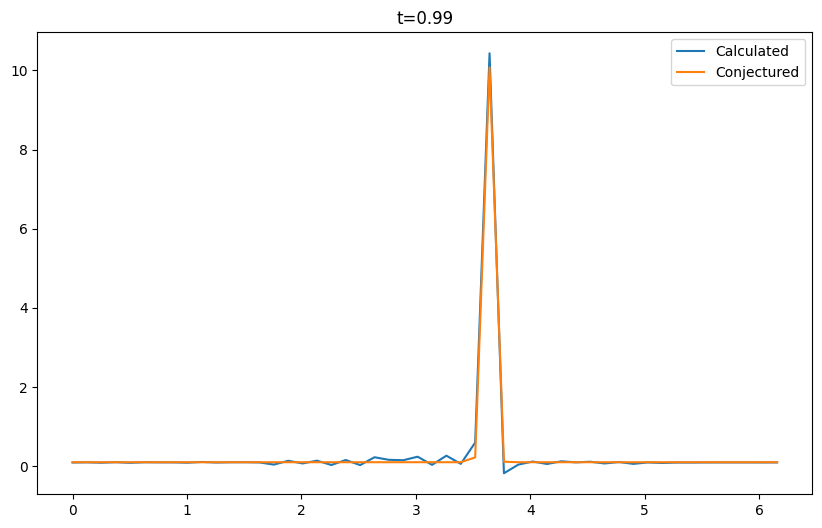

In [18]:
time_steps = p.shape[0]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, von_mises_pdf(xs, np.pi-0.5+time, 700)+0.1, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

# Example 12.2
We do the same experiment with more smoothness (less sharp gaussian)

In [28]:
T = 100
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, np.pi-0.5, 5)+0.1
p2 = von_mises_pdf(xs, np.pi+0.5, 5)+0.1

wfrs = []
rels = np.arange(1000, 6000, 1000)
v = np.ones((T, N, 1))
z = np.zeros((T,N))

In [29]:
for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z, iprint=1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39551D+03    |proj g|=  1.76897D+01


 This problem is unconstrained.



At iterate    1    f=  1.36701D+03    |proj g|=  1.74698D+01

At iterate    2    f=  1.35216D+03    |proj g|=  1.69518D+01

At iterate    3    f=  1.34251D+03    |proj g|=  1.73489D+01

At iterate    4    f=  1.33518D+03    |proj g|=  1.27870D+01

At iterate    5    f=  1.33046D+03    |proj g|=  1.65658D+01

At iterate    6    f=  1.32601D+03    |proj g|=  1.28302D+01

At iterate    7    f=  1.32294D+03    |proj g|=  1.97948D+01

At iterate    8    f=  1.31954D+03    |proj g|=  9.35701D+00

At iterate    9    f=  1.31710D+03    |proj g|=  9.24855D+00

At iterate   10    f=  1.31526D+03    |proj g|=  1.29330D+01

At iterate   11    f=  1.31255D+03    |proj g|=  1.37864D+01

At iterate   12    f=  1.31089D+03    |proj g|=  1.26087D+01

At iterate   13    f=  1.30930D+03    |proj g|=  1.18067D+01

At iterate   14    f=  1.30804D+03    |proj g|=  8.46733D+00

At iterate   15    f=  1.30598D+03    |proj g|=  1.46673D+01

At iterate   16    f=  1.30523D+03    |proj g|=  1.84428D+01

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29890D+02    |proj g|=  1.53178D+01

At iterate    1    f=  4.29890D+02    |proj g|=  9.69786D+00

At iterate    2    f=  4.29890D+02    |proj g|=  5.13609D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10000      2      9      1     0     0   5.136D+00   4.299D+02
  F =   429.88982412610682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29890D+02    |proj g|=  7.28258D+00

At iterate    1    f=  4.29890D+02    |proj g|=  1.37681D+01

At iterate    2    f=  4.29890D+02    |proj g|=  9.26860D+00

At iterate    3    f=  4.29890D+02    |proj g|=  2.27109D+01

At iterate    4    f=  4.29890D+02    |proj g|=  1.32642D+01

At iterate    5    f=  4.29890D+02    |proj g|=  1.15351D+01

At iterate    6    f=  4.29890D+02    |proj g|=  1.20983D+01

At iterate    7    f=  4.29890D+02    |proj g|=  1.31720D+01

At iterate    8    f=  4.29890D+02    |proj g|=  1.08474D+01

At iterate    9    f=  4.29890D+02    |proj g|=  9.09622D+00

At iterate   10    f=  4.29890D+02    |proj g|=  7.16772D+00

At iterate   11    f=  4.29890D+02    |proj g|=  1.61586D+01

At iterate   12    f=  4.29890D+02    |proj g|=  3.14296D+01

           * * *

Tit   = 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29890D+02    |proj g|=  4.15181D+01

At iterate    1    f=  4.29890D+02    |proj g|=  1.17693D+01

At iterate    2    f=  4.29890D+02    |proj g|=  1.00661D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10000      2     10      1     0     0   1.007D+01   4.299D+02
  F =   429.88983932205974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    1    f=  4.29890D+02    |proj g|=  2.71968D+01

At iterate    2    f=  4.29890D+02    |proj g|=  2.01573D+01

At iterate    3    f=  4.29890D+02    |proj g|=  4.40828D+01

At iterate    4    f=  4.29890D+02    |proj g|=  1.78039D+01

At iterate    5    f=  4.29890D+02    |proj g|=  9.04889D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10000      5     12      1     0     0   9.049D+00   4.299D+02
  F =   429.88984746791431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


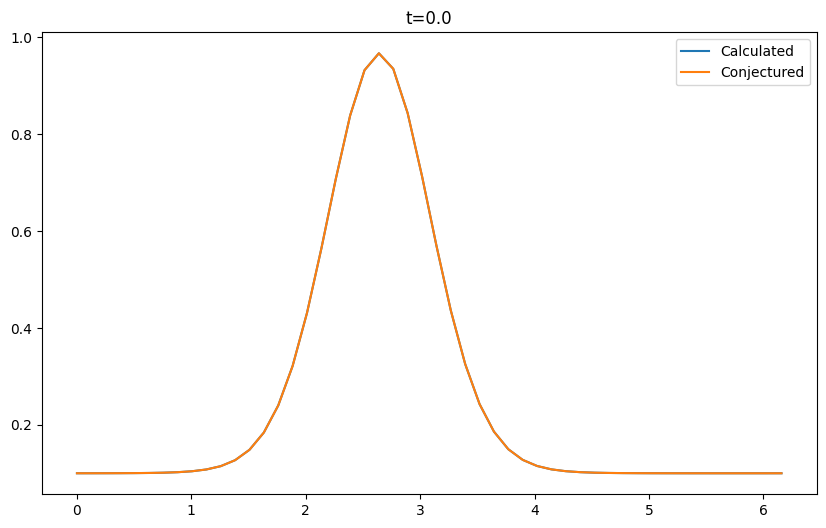

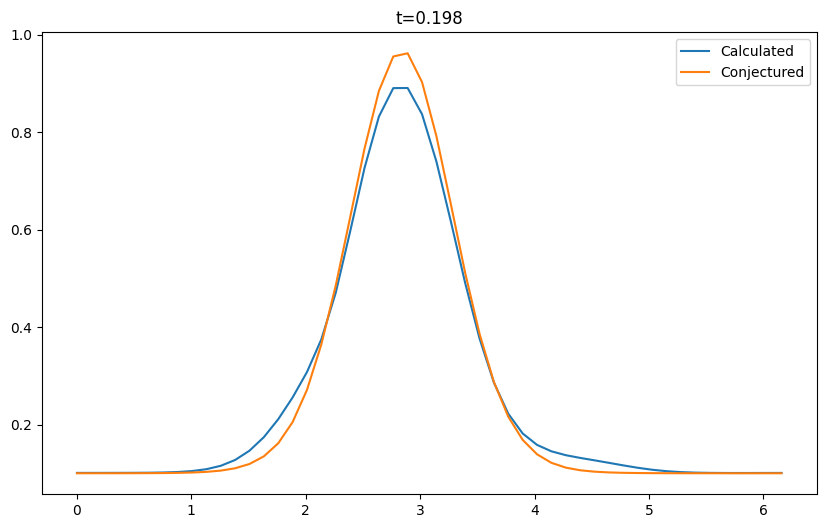

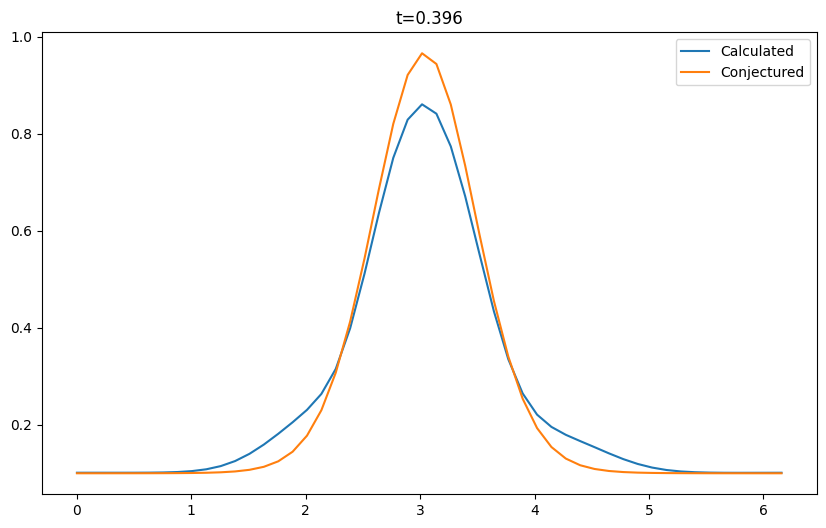

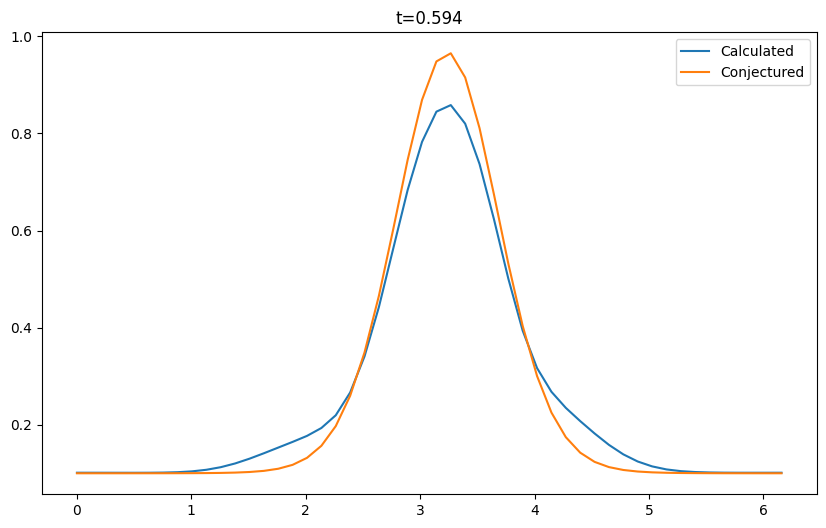

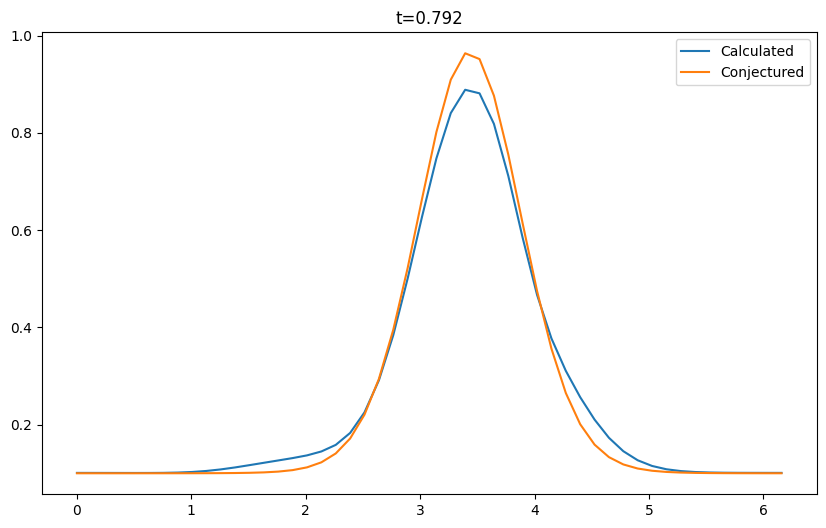

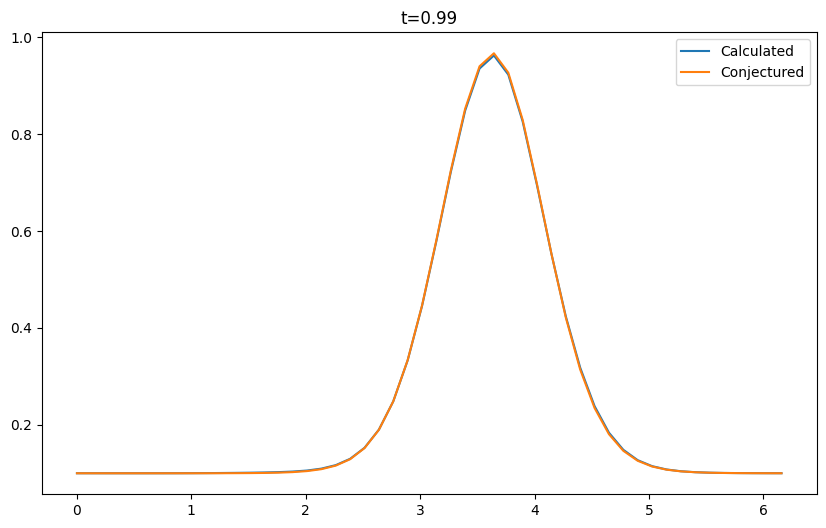

In [8]:
time_steps = p.shape[0]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, von_mises_pdf(xs, np.pi-0.5+time, 5)+0.1, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

In [22]:
np.max(z,axis=0)

array([ 0.08674907,  0.06281698,  0.03915588,  0.01541069, -0.00876119,
       -0.03367025, -0.05963297, -0.08693379, -0.11589051, -0.14678806,
       -0.17993186, -0.21545245, -0.25318839, -0.29221222, -0.33006121,
       -0.36104812, -0.37734287, -0.36885501, -0.33268383, -0.27577416,
       -0.20754461, -0.13150323, -0.05057558,  0.0338513 ,  0.11981702,
        0.20483209,  0.28669821,  0.36334017,  0.43307277,  0.49393272,
        0.54472633,  0.58430303,  0.6114503 ,  0.62571095,  0.62713271,
        0.61650198,  0.59476125,  0.56323974,  0.52400245,  0.47945924,
        0.43242747,  0.38543133,  0.34047886,  0.29864881,  0.26033458,
        0.22541336,  0.19355825,  0.16426921,  0.13703102,  0.11134043])

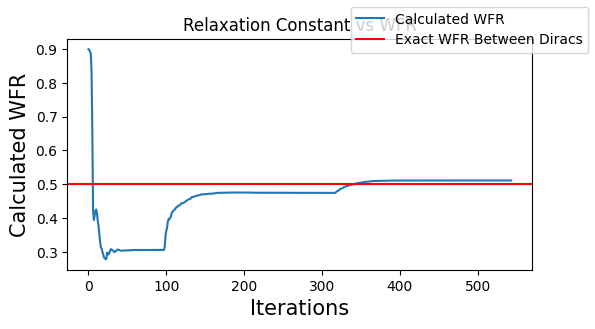

In [18]:
# Plotting WFRs
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(range(544), wfrs, label='Calculated WFR')
ax1.axhline(y=0.5, color='r', linestyle='-', label = 'Exact WFR Between Diracs')
ax1.set_xlabel('Iterations', fontsize = '15')
ax1.set_ylabel('Calculated WFR', fontsize = '15')
ax1.set_title('Relaxation Constant vs WFR')
fig.legend()
plt.show()

# Convex Curve Constraint
We consider the constraint
$\begin{equation} \int_{\mathbb{S}^1} x d\rho_t = 0\end{equation} \tag*{}$
We implement this as

$\begin{align} \int_{0}^{2\pi} \cos{\theta} d\rho_t(\theta) &= 0 \\ \int_{0}^{2\pi} \sin{\theta} d\rho_t(\theta) &= 0\end{align} \tag*{}$


In [8]:
T = 50
N = 20
dx = [2*np.pi/N]
xs = np.arange(0, 2*np.pi, 2*np.pi/N)
sinx = np.sin(xs)
cosx = np.cos(xs)

H_1 = sinx
H_2 = cosx

p1 = von_mises_pdf(xs, 0, 5)+von_mises_pdf(xs, np.pi, 5)
p2 = np.roll(p1, 5)

H = np.stack([H_1, H_2], axis=0)
H = H[:, np.newaxis, :].repeat(T+1,1)
F = np.zeros((2, T+1))

In [9]:
import math
import functools
import torchdiffeq

spatial_dim =1

H_torch, Fprime_torch, dHdt_torch, gradH_torch = _calculate_derivatives(
    H, F, dx, T, p1.shape
)

print(gradH_torch[0][0][0])
p1_torch = torch.tensor(p1)

wfrs = []

def collect_wfr(_vz: np.ndarray):
    _v = torch.tensor(_vz[: math.prod(v.shape)].reshape(v.shape))
    _z = torch.tensor(_vz[math.prod(v.shape) :].reshape(z.shape))
    divpz = functools.partial(
    _div_plus_pz_grid,
    v=_v,
    z=_z,
    dx=dx,
    T=T,
    H=H_torch,
    Fprime=Fprime_torch,
    dHdt=dHdt_torch,
    gradH=gradH_torch,
    scheme='central',
    )
    _p = torchdiffeq.odeint(
            divpz,
            p1_torch,
            torch.linspace(0, 1, steps=T + 1),
            method='euler',
        )
    _v, _z = _batch_project_affine(
        _p, _v, _z, H_torch, dHdt_torch, gradH_torch, Fprime_torch, dx
    )
    #for t in range(_p.shape[0]):
        #print('sinx',(_p[t]*sinx).sum())
        #print('cosx',(_p[t]*cosx).sum())
    wfr_energy = torch.sqrt(
        0.5 * _WFR_energy(_p[:-1], _v, _z, 1.) * math.prod(dx) * (1./T)
    ).numpy()
    print("wfr = ", wfr_energy)
    wfrs.append(float(wfr_energy))

tensor([ 9.8363e-01,  9.3549e-01,  7.9577e-01,  5.7816e-01,  3.0396e-01,
         1.7670e-16, -3.0396e-01, -5.7816e-01, -7.9577e-01, -9.3549e-01,
        -9.8363e-01, -9.3549e-01, -7.9577e-01, -5.7816e-01, -3.0396e-01,
        -1.7670e-16,  3.0396e-01,  5.7816e-01,  7.9577e-01,  9.3549e-01],
       dtype=torch.float64)


In [10]:
wfrs = []
rels = np.arange(1000, 6000, 1000)
v = np.ones((T, N, 1))
z = np.zeros((T,N))

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z, callback=collect_wfr)

wfr =  1.012681865652539
wfr =  1.1472971115084243
wfr =  1.2367424974591685
wfr =  1.2966999645213328
wfr =  1.3140677306724102
wfr =  1.3356547562477872
wfr =  1.3936442127295274
wfr =  1.4106168389969298
wfr =  1.4318454541083736
wfr =  1.4410958214260277
wfr =  1.444489547643753
wfr =  1.4360336784261407
wfr =  1.4366534798657826
wfr =  1.4381019360763094
wfr =  1.4380665515133522
wfr =  1.4383505494054358
wfr =  1.438554325890935
wfr =  1.4348472255421507
wfr =  1.4379193208278855
wfr =  1.4383433136973642
wfr =  1.4394346828740068
wfr =  1.4357798920144405
wfr =  1.4374141773932196
wfr =  1.437852484537477
wfr =  1.4379268337068871
wfr =  1.4380254797890308
wfr =  1.4381527012838762
wfr =  1.4382033795395877
wfr =  1.438249835007595
wfr =  1.4382611849843203
wfr =  1.4382296396107432
wfr =  1.438262700176847
wfr =  1.438296207972865
wfr =  1.438315413339004
wfr =  1.4383303981361253
wfr =  1.4383346297307238
wfr =  1.438337553487359
wfr =  1.4383405731723007
wfr =  1.438343353142

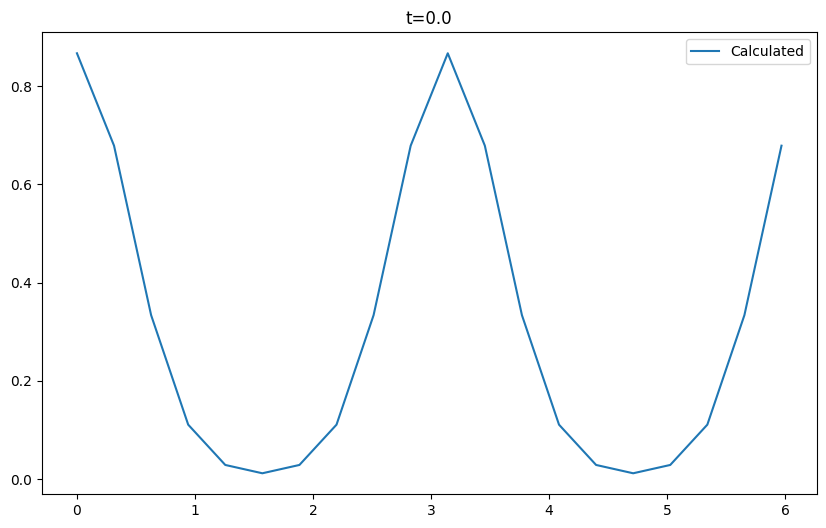

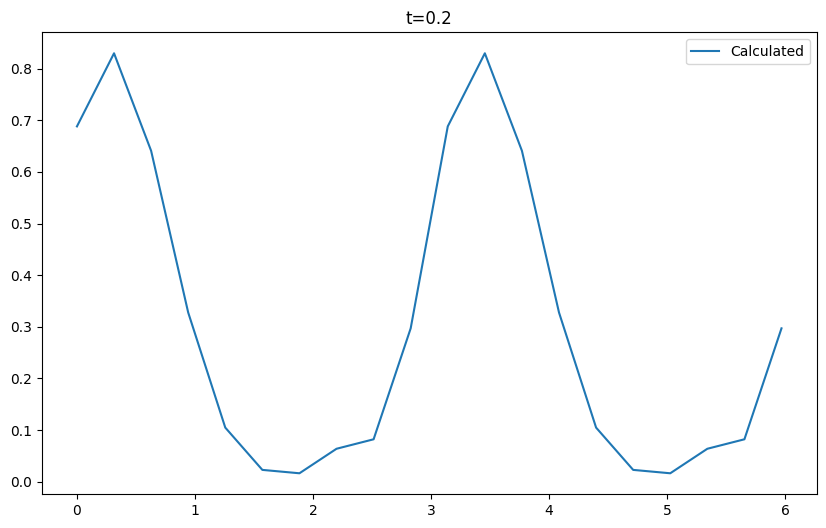

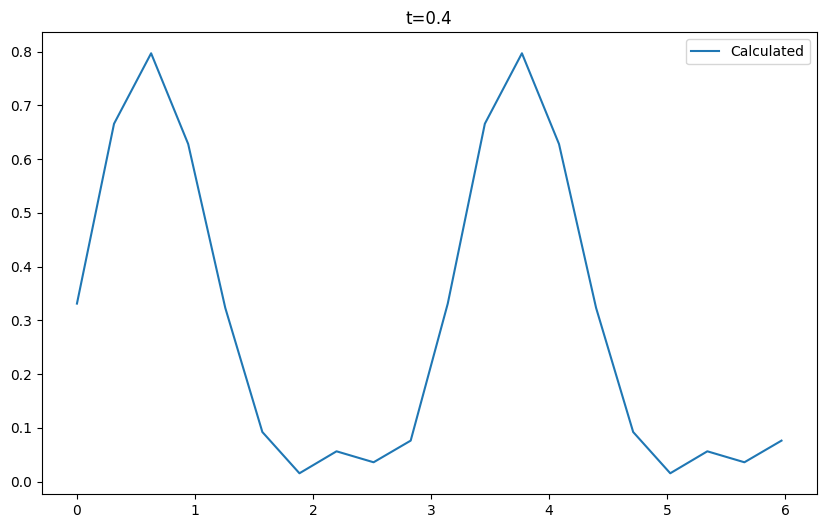

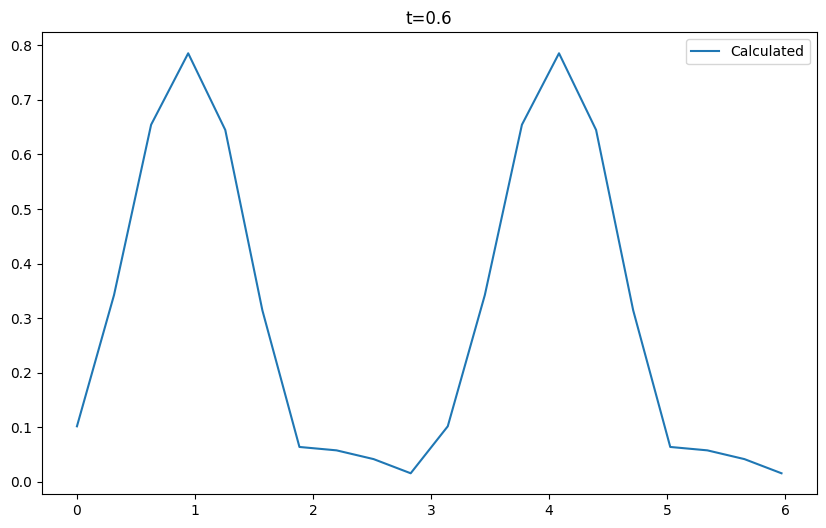

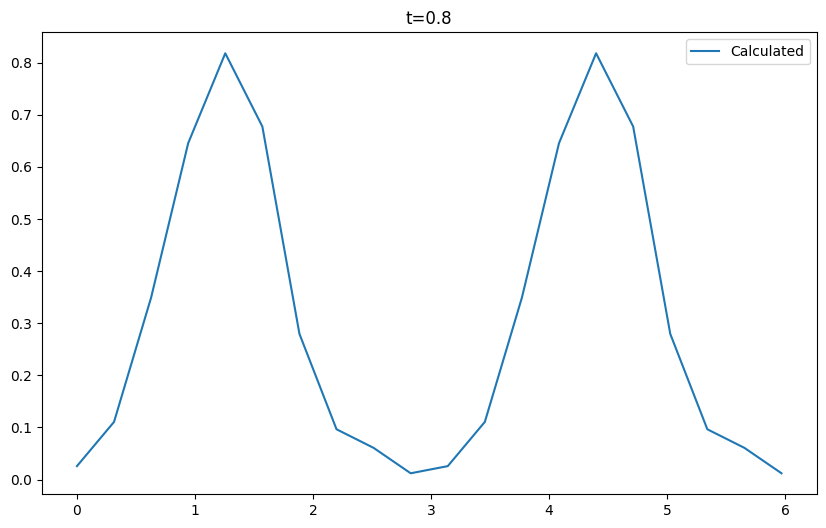

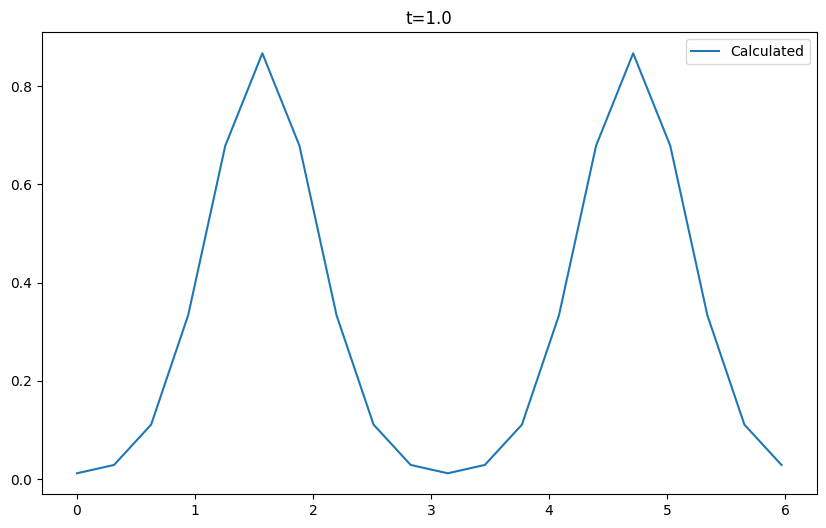

In [11]:
time_steps = p.shape[0]

for time_step in range(0, time_steps, 10):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    #plt.plot(xs, von_mises_pdf(xs, np.pi-0.5+time, 5)+0.1, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

In [14]:
# plot of integral p*sin(x) and integral p*cos(x) at each time

for time_step in range(T):
    sin_int = (p[time_step]*sinx).sum(-1)
    cos_int = (p[time_step]*cosx).sum(-1)
    print(sin_int)
    print(cos_int)

4.996003610813204e-16
-2.220446049250313e-16
4.718447854656915e-16
-3.3306690738754696e-16
4.440892098500626e-16
-2.220446049250313e-16
4.718447854656915e-16
-5.551115123125783e-16
6.106226635438361e-16
-3.885780586188048e-16
4.996003610813204e-16
-2.220446049250313e-16
4.163336342344337e-16
-3.885780586188048e-16
5.828670879282072e-16
-4.996003610813204e-16
5.828670879282072e-16
-7.216449660063518e-16
4.440892098500626e-16
-5.551115123125783e-16
7.077671781985373e-16
-5.551115123125783e-16
5.134781488891349e-16
-7.771561172376096e-16
4.3021142204224816e-16
-5.551115123125783e-16
5.828670879282072e-16
-9.71445146547012e-16
5.48172618408671e-16
-6.938893903907228e-16
6.730727086790012e-16
-6.106226635438361e-16
6.175615574477433e-16
-3.885780586188048e-16
5.898059818321144e-16
-8.049116928532385e-16
6.800116025829084e-16
-5.551115123125783e-16
5.204170427930421e-16
-6.800116025829084e-16
5.134781488891349e-16
-9.298117831235686e-16
3.226585665316861e-16
-9.08995101411847e-16
4.440892098

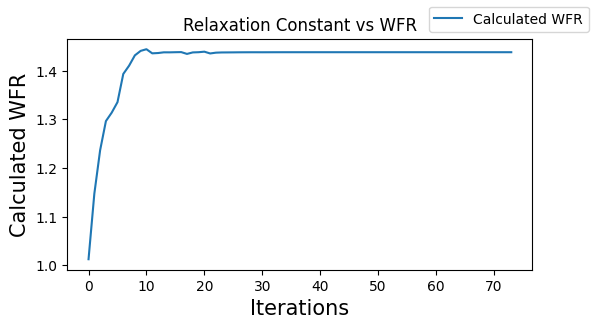

In [15]:
# Plotting WFRs
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(range(74), wfrs, label='Calculated WFR')
#ax1.axhline(y=0.5, color='r', linestyle='-', label = 'Exact WFR Between Diracs')
ax1.set_xlabel('Iterations', fontsize = '15')
ax1.set_ylabel('Calculated WFR', fontsize = '15')
ax1.set_title('Relaxation Constant vs WFR')
fig.legend()
plt.show()

### 3 vertices -> 2 vertices

tensor([ 0.9974,  0.9895,  0.9660,  0.9273,  0.8740,  0.8069,  0.7271,  0.6357,
         0.5344,  0.4247,  0.3082,  0.1869,  0.0626, -0.0626, -0.1869, -0.3082,
        -0.4247, -0.5344, -0.6357, -0.7271, -0.8069, -0.8740, -0.9273, -0.9660,
        -0.9895, -0.9974, -0.9895, -0.9660, -0.9273, -0.8740, -0.8069, -0.7271,
        -0.6357, -0.5344, -0.4247, -0.3082, -0.1869, -0.0626,  0.0626,  0.1869,
         0.3082,  0.4247,  0.5344,  0.6357,  0.7271,  0.8069,  0.8740,  0.9273,
         0.9660,  0.9895], dtype=torch.float64)
wfr =  1.2148258358098096
wfr =  1.152521316658187
wfr =  1.127159833451534
wfr =  1.1212572103199838
wfr =  1.118476023485629
wfr =  1.1131308541495124
wfr =  1.1033483542844242
wfr =  1.095859131585353
wfr =  1.0961232146337463
wfr =  1.0950793317388188
wfr =  1.094190580340992
wfr =  1.0924837843591015
wfr =  1.0902503066383413
wfr =  1.0881147206097315
wfr =  1.0843592143142318
wfr =  1.0791251926942056
wfr =  1.0675389518828462
wfr =  1.0651958299611088
wfr =  1.

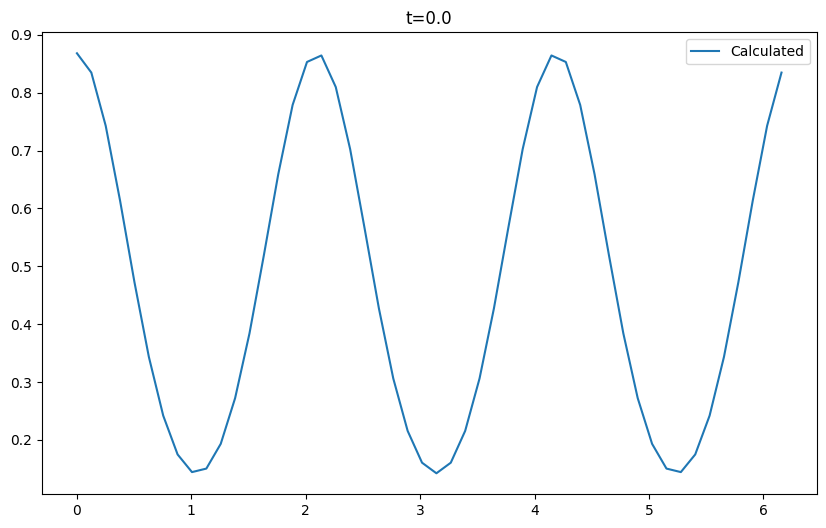

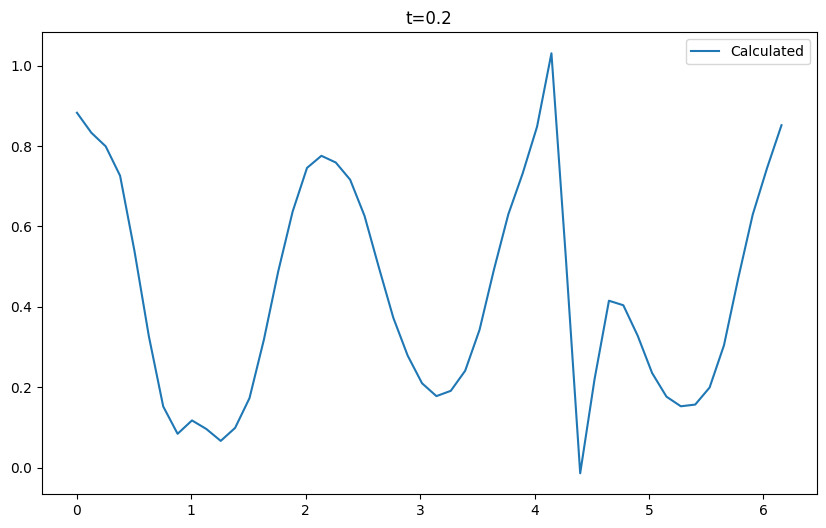

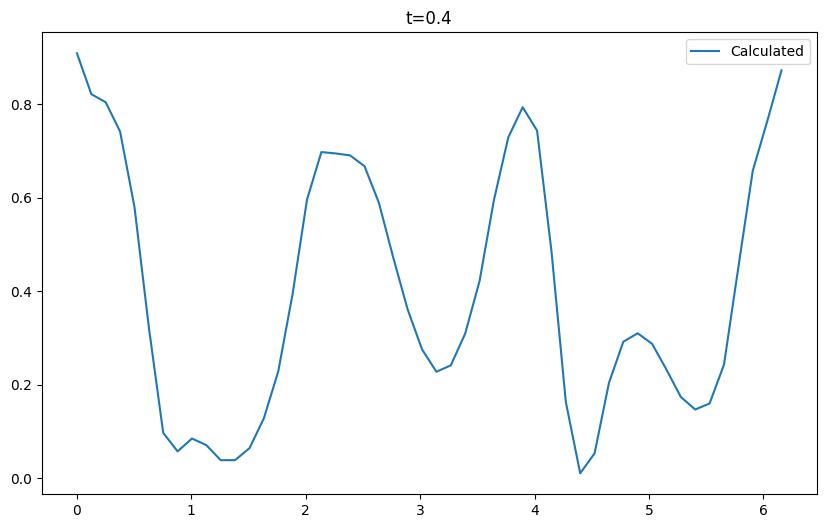

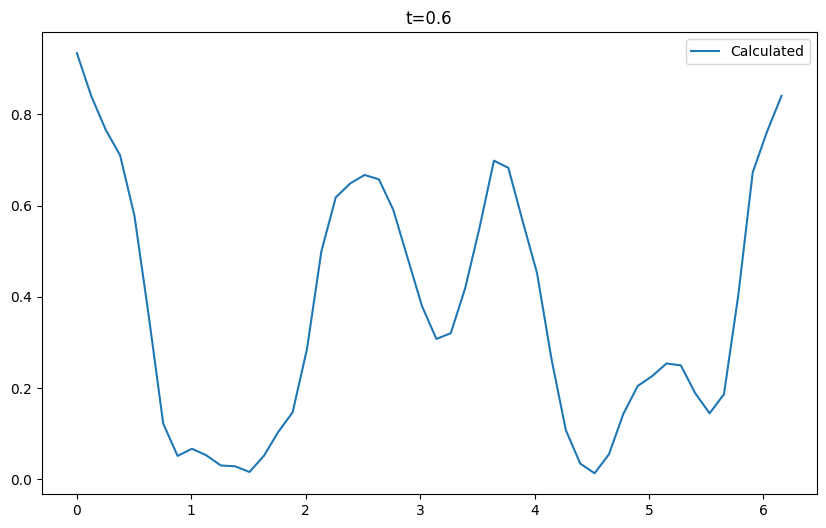

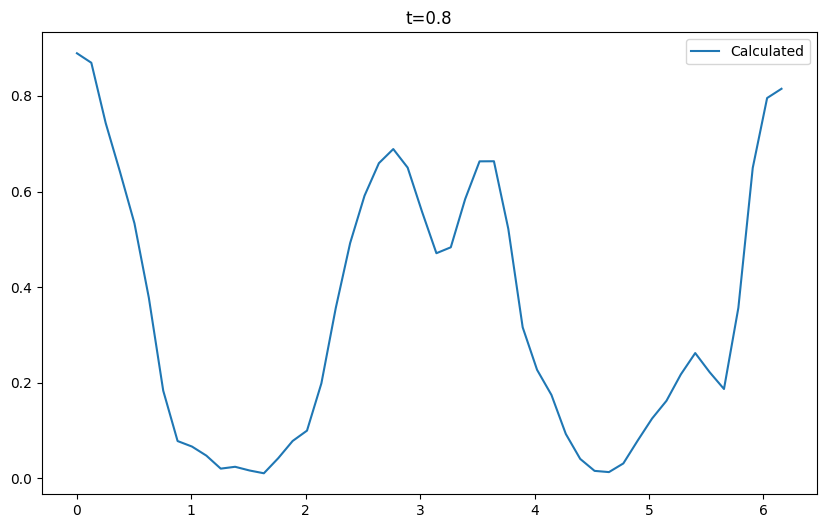

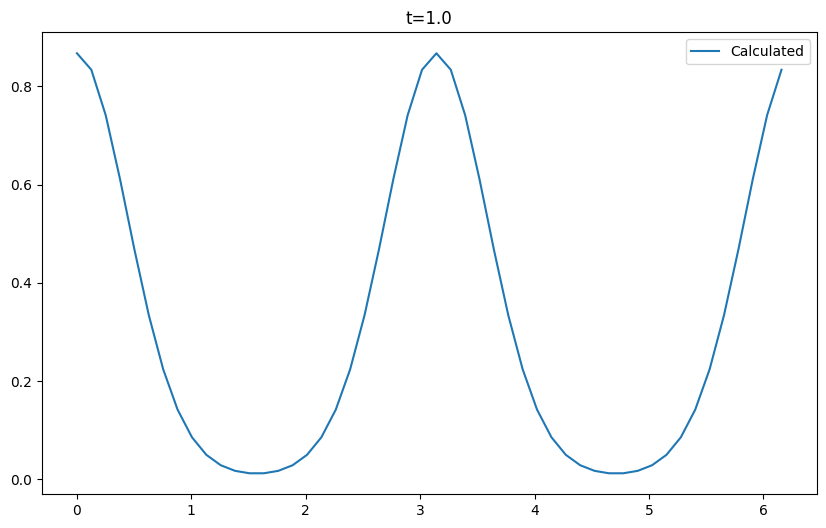

sin 2.525757381022231e-15
cos 3.3306690738754696e-16
sin 2.9976021664879227e-15
cos 1.1102230246251565e-15
sin 2.6506574712925612e-15
cos 1.1102230246251565e-15
sin 2.831068712794149e-15
cos 6.661338147750939e-16
sin 2.67841304690819e-15
cos 6.661338147750939e-16
sin 2.8171909249863347e-15
cos 9.992007221626409e-16
sin 2.9559688030644793e-15
cos 8.881784197001252e-16
sin 3.094746681142624e-15
cos 8.881784197001252e-16
sin 3.552713678800501e-15
cos 8.881784197001252e-16
sin 3.2612801348363973e-15
cos 6.661338147750939e-16
sin 3.2751579226442118e-15
cos 7.771561172376096e-16
sin 3.247402347028583e-15
cos 4.440892098500626e-16
sin 3.524958103184872e-15
cos 7.771561172376096e-16
sin 3.524958103184872e-15
cos 6.661338147750939e-16
sin 3.4555691641457997e-15
cos 5.551115123125783e-16
sin 3.2890357104520263e-15
cos 3.3306690738754696e-16
sin 3.70536934468646e-15
cos 6.661338147750939e-16
sin 3.469446951953614e-15
cos 4.440892098500626e-16
sin 3.4139358007223564e-15
cos 4.440892098500626e-16
s

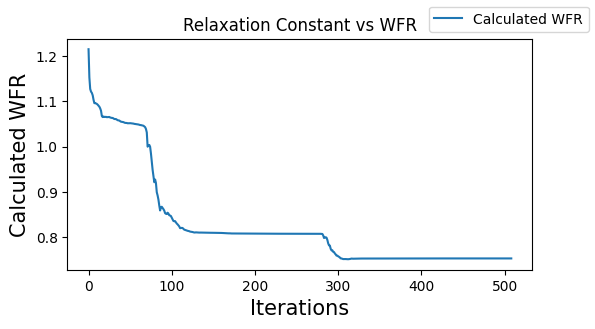

In [16]:
T = 50
N = 50
dx = [2*np.pi/N]
xs = np.arange(0, 2*np.pi, 2*np.pi/N)
sinx = np.sin(xs)
cosx = np.cos(xs)

H_1 = sinx
H_2 = cosx

p1 = von_mises_pdf(xs, 0, 5)+von_mises_pdf(xs, 2*np.pi/3, 5)+von_mises_pdf(xs, 4*np.pi/3, 5)
p2 = von_mises_pdf(xs, 0, 5)+von_mises_pdf(xs, np.pi, 5)

H = np.stack([H_1, H_2], axis=0)
H = H[:, np.newaxis, :].repeat(T+1,1)
F = np.zeros((2, T+1))

import math
import functools
import torchdiffeq

spatial_dim =1

H_torch, Fprime_torch, dHdt_torch, gradH_torch = _calculate_derivatives(
    H, F, dx, T, p1.shape
)

print(gradH_torch[0][0][0])
p1_torch = torch.tensor(p1)

wfrs = []

def collect_wfr(_vz: np.ndarray):
    _v = torch.tensor(_vz[: math.prod(v.shape)].reshape(v.shape))
    _z = torch.tensor(_vz[math.prod(v.shape) :].reshape(z.shape))
    divpz = functools.partial(
    _div_plus_pz_grid,
    v=_v,
    z=_z,
    dx=dx,
    T=T,
    H=H_torch,
    Fprime=Fprime_torch,
    dHdt=dHdt_torch,
    gradH=gradH_torch,
    scheme='central',
    )
    _p = torchdiffeq.odeint(
            divpz,
            p1_torch,
            torch.linspace(0, 1, steps=T + 1),
            method='euler',
        )
    _v, _z = _batch_project_affine(
        _p, _v, _z, H_torch, dHdt_torch, gradH_torch, Fprime_torch, dx
    )
    #for t in range(_p.shape[0]):
        #print('sinx',(_p[t]*sinx).sum())
        #print('cosx',(_p[t]*cosx).sum())
    wfr_energy = torch.sqrt(
        0.5 * _WFR_energy(_p[:-1], _v, _z, 1.) * math.prod(dx) * (1./T)
    ).numpy()
    print("wfr = ", wfr_energy)
    wfrs.append(float(wfr_energy))

wfrs = []
rels = np.arange(1000, 6000, 1000)
v = np.ones((T, N, 1))
z = np.zeros((T,N))

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z, callback=collect_wfr)

time_steps = p.shape[0]

for time_step in range(0, time_steps, 10):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    #plt.plot(xs, von_mises_pdf(xs, np.pi-0.5+time, 5)+0.1, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

# plot of integral p*sin(x) and integral p*cos(x) at each time

for time_step in range(T):
    sin_int = (p[time_step]*sinx).sum(-1)
    cos_int = (p[time_step]*cosx).sum(-1)
    print('sin',sin_int)
    print('cos',cos_int)

# Plotting WFRs
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(range(len(wfrs)), wfrs, label='Calculated WFR')
#ax1.axhline(y=0.5, color='r', linestyle='-', label = 'Exact WFR Between Diracs')
ax1.set_xlabel('Iterations', fontsize = '15')
ax1.set_ylabel('Calculated WFR', fontsize = '15')
ax1.set_title('Relaxation Constant vs WFR')
fig.legend()
plt.show()

tensor([ 9.8363e-01,  9.3549e-01,  7.9577e-01,  5.7816e-01,  3.0396e-01,
         1.7670e-16, -3.0396e-01, -5.7816e-01, -7.9577e-01, -9.3549e-01,
        -9.8363e-01, -9.3549e-01, -7.9577e-01, -5.7816e-01, -3.0396e-01,
        -1.7670e-16,  3.0396e-01,  5.7816e-01,  7.9577e-01,  9.3549e-01],
       dtype=torch.float64)


wfr =  1.2182960829389746
wfr =  1.2147163299473365
wfr =  1.2226105720865916
wfr =  1.217095237690286
wfr =  1.1954120657290883
wfr =  1.1753635728674092
wfr =  1.1423867916928776
wfr =  1.130409381192552
wfr =  1.1211094615476793
wfr =  1.0874022834628705
wfr =  1.0278203494655191
wfr =  0.9416671507709555
wfr =  0.8806435001208307
wfr =  0.8590800161246038
wfr =  0.8536116664690047
wfr =  0.8400280786077107
wfr =  0.80008080076521
wfr =  0.7772709186467986
wfr =  0.7479562551266948
wfr =  0.7466302766650667
wfr =  0.7437851046905528
wfr =  0.7365019641907006
wfr =  0.7215345816726176
wfr =  0.705555728956126
wfr =  0.6973104046465254
wfr =  0.6865072323561245
wfr =  0.6807301354279297
wfr =  0.6738972016426567
wfr =  0.6743558444566057
wfr =  0.6739665049380129
wfr =  0.6708981737957906
wfr =  0.6677462434408227
wfr =  0.6636709435165892
wfr =  0.6538238085948515
wfr =  0.6477458795267447
wfr =  0.6415116238537789
wfr =  0.6394527966407275
wfr =  0.6366183996025413
wfr =  0.63360613

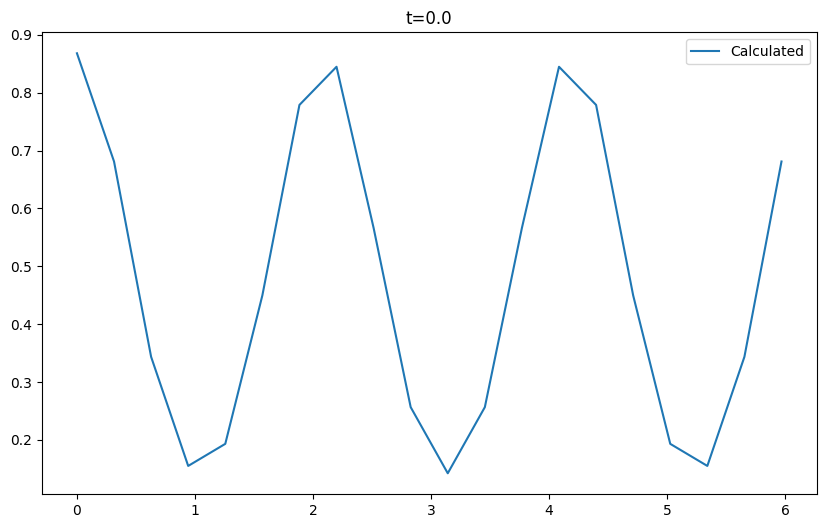

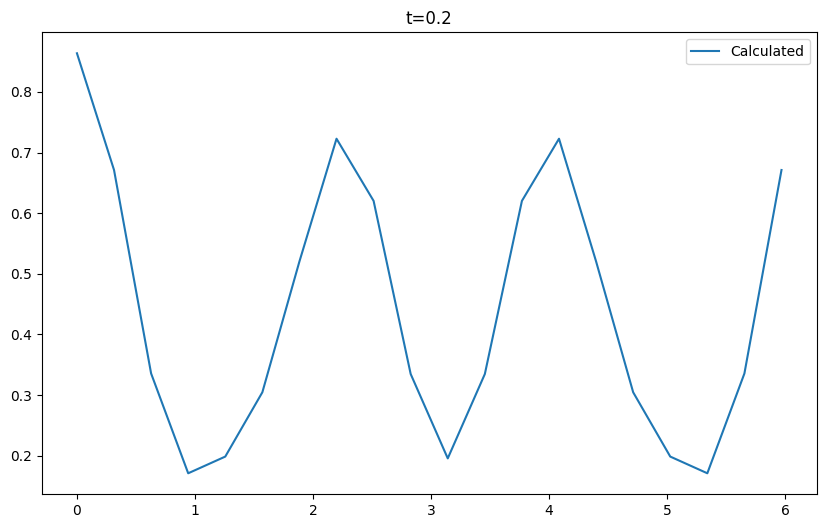

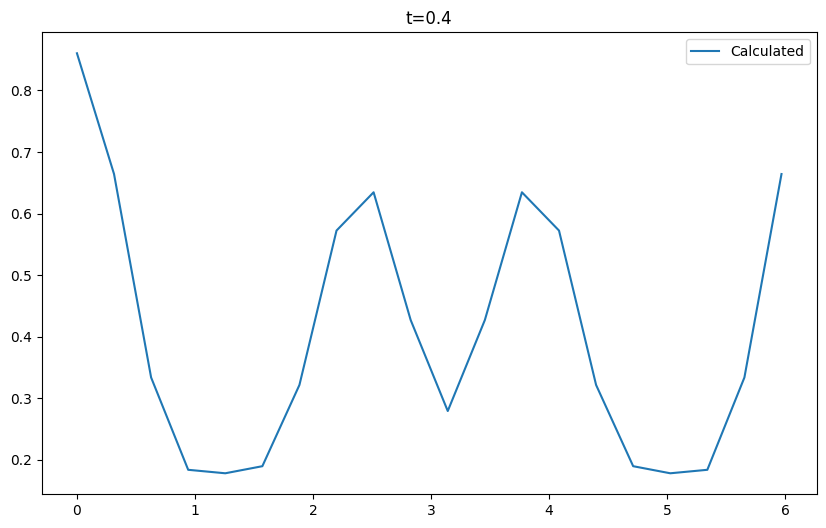

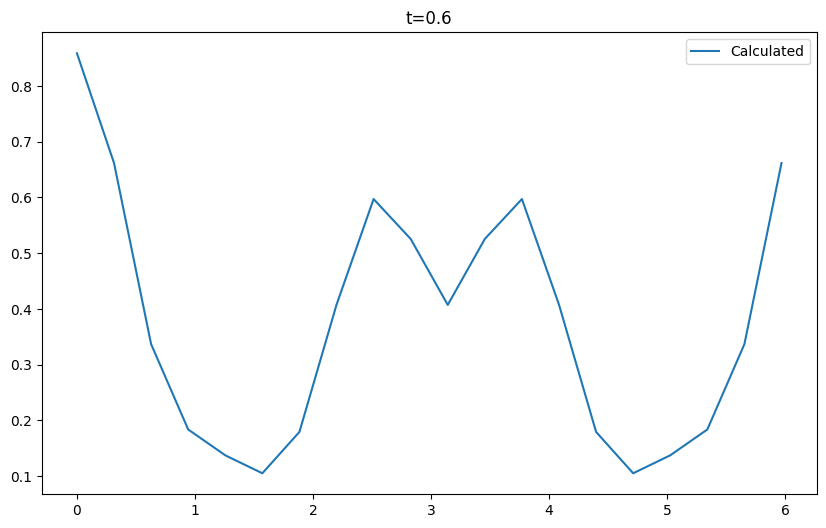

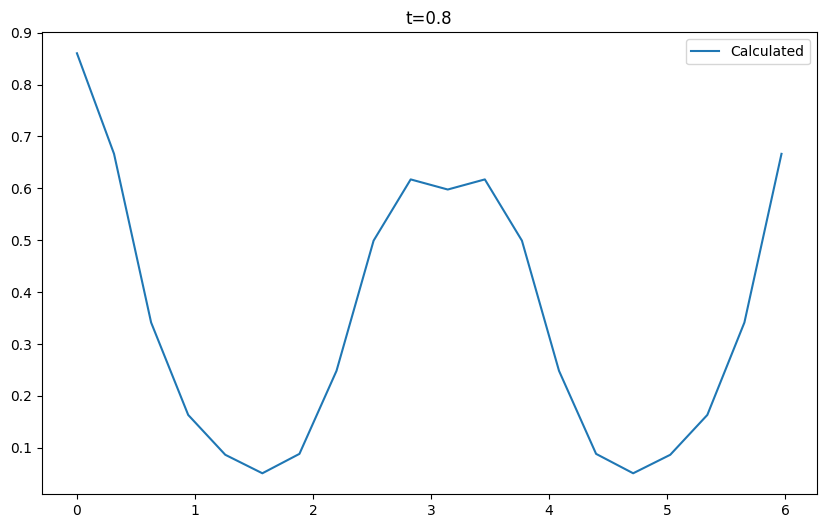

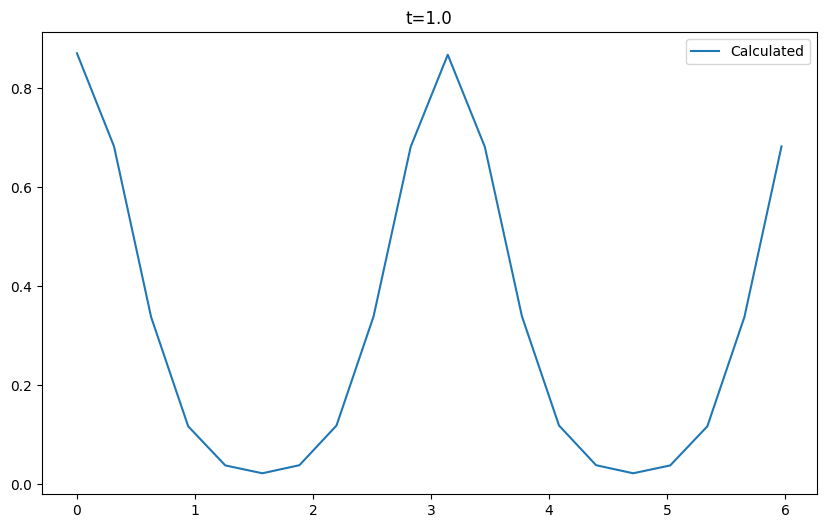

sin 1.0547118733938987e-15
cos 2.0676793610618915e-12
sin 1.3600232051658168e-15
cos 2.0674573164569665e-12
sin 1.4432899320127035e-15
cos 2.067346294154504e-12
sin 1.304512053934559e-15
cos 2.0672352718520415e-12
sin 1.3600232051658168e-15
cos 2.0674573164569665e-12
sin 1.4432899320127035e-15
cos 2.0676793610618915e-12
sin 1.5543122344752192e-15
cos 2.067568338759429e-12
sin 1.4432899320127035e-15
cos 2.067124249549579e-12
sin 1.5265566588595902e-15
cos 2.066902204944654e-12
sin 1.4988010832439613e-15
cos 2.0674573164569665e-12
sin 1.4988010832439613e-15
cos 2.067568338759429e-12
sin 1.4710455076283324e-15
cos 2.0674573164569665e-12
sin 1.5265566588595902e-15
cos 2.067568338759429e-12
sin 1.7486012637846216e-15
cos 2.0672352718520415e-12
sin 1.6375789613221059e-15
cos 2.067346294154504e-12
sin 1.6930901125533637e-15
cos 2.067346294154504e-12
sin 1.4988010832439613e-15
cos 2.067568338759429e-12
sin 1.4432899320127035e-15
cos 2.067346294154504e-12
sin 1.7208456881689926e-15
cos 2.067346

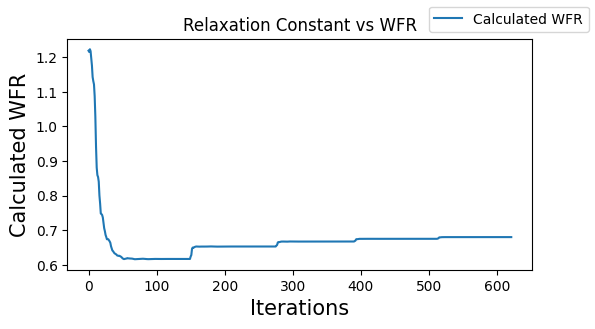

In [6]:
T = 50
N = 20
dx = [2*np.pi/N]
xs = np.arange(0, 2*np.pi, 2*np.pi/N)
sinx = np.sin(xs)
cosx = np.cos(xs)

H_1 = sinx
H_2 = cosx

p1 = von_mises_pdf(xs, 0, 5)+von_mises_pdf(xs, 2*np.pi/3, 5)+von_mises_pdf(xs, 4*np.pi/3, 5)
p2 = von_mises_pdf(xs, 0, 5)+von_mises_pdf(xs, np.pi, 5)

H = np.stack([H_1, H_2], axis=0)
H = H[:, np.newaxis, :].repeat(T+1,1)
F = np.zeros((2, T+1))

import math
import functools
import torchdiffeq

spatial_dim =1

H_torch, Fprime_torch, dHdt_torch, gradH_torch = _calculate_derivatives(
    H, F, dx, T, p1.shape
)

print(gradH_torch[0][0][0])
p1_torch = torch.tensor(p1)

wfrs = []

def collect_wfr(_vz: np.ndarray):
    _v = torch.tensor(_vz[: math.prod(v.shape)].reshape(v.shape))
    _z = torch.tensor(_vz[math.prod(v.shape) :].reshape(z.shape))
    divpz = functools.partial(
    _div_plus_pz_grid,
    v=_v,
    z=_z,
    dx=dx,
    T=T,
    H=H_torch,
    Fprime=Fprime_torch,
    dHdt=dHdt_torch,
    gradH=gradH_torch,
    scheme='central',
    )
    _p = torchdiffeq.odeint(
            divpz,
            p1_torch,
            torch.linspace(0, 1, steps=T + 1),
            method='euler',
        )
    _v, _z = _batch_project_affine(
        _p, _v, _z, H_torch, dHdt_torch, gradH_torch, Fprime_torch, dx
    )
    #for t in range(_p.shape[0]):
        #print('sinx',(_p[t]*sinx).sum())
        #print('cosx',(_p[t]*cosx).sum())
    wfr_energy = torch.sqrt(
        0.5 * _WFR_energy(_p[:-1], _v, _z, 1.) * math.prod(dx) * (1./T)
    ).numpy()
    print("wfr = ", wfr_energy)
    wfrs.append(float(wfr_energy))

wfrs = []
rels = np.arange(1000, 6000, 1000)
v = np.ones((T, N, 1))
z = np.zeros((T,N))

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F, dx=dx, v0=v, z0=z, callback=collect_wfr)

time_steps = p.shape[0]

for time_step in range(0, time_steps, 10):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    #plt.plot(xs, von_mises_pdf(xs, np.pi-0.5+time, 5)+0.1, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

# plot of integral p*sin(x) and integral p*cos(x) at each time

for time_step in range(T):
    sin_int = (p[time_step]*sinx).sum(-1)
    cos_int = (p[time_step]*cosx).sum(-1)
    print('sin',sin_int)
    print('cos',cos_int)

# Plotting WFRs
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.plot(range(len(wfrs)), wfrs, label='Calculated WFR')
#ax1.axhline(y=0.5, color='r', linestyle='-', label = 'Exact WFR Between Diracs')
ax1.set_xlabel('Iterations', fontsize = '15')
ax1.set_ylabel('Calculated WFR', fontsize = '15')
ax1.set_title('Relaxation Constant vs WFR')
fig.legend()
plt.show()

In [3]:
z

array([[-0.180202  , -0.18177341, -0.18643196, ..., -0.19479521,
        -0.18643265, -0.18177283],
       [-0.18107237, -0.18263653, -0.18727152, ..., -0.19565173,
        -0.18727221, -0.18263595],
       [-0.18193536, -0.18349372, -0.18811464, ..., -0.19652777,
        -0.18811533, -0.18349315],
       ...,
       [-0.24070861, -0.24245056, -0.24810288, ..., -0.26055405,
        -0.24810341, -0.24244995],
       [-0.24260141, -0.24434516, -0.2500089 , ..., -0.26260396,
        -0.2500094 , -0.24434455],
       [-0.24453452, -0.24628234, -0.25195803, ..., -0.26469908,
        -0.25195852, -0.24628171]])

In [5]:
v[20]

array([[-2.28691010e-06],
       [-2.67659091e-02],
       [-5.75760990e-02],
       [-9.70418944e-02],
       [-1.50297846e-01],
       [-2.22499391e-01],
       [-3.25391705e-01],
       [-4.56291654e-01],
       [-5.79773786e-01],
       [-6.52027394e-01],
       [-6.54559976e-01],
       [-5.80014855e-01],
       [-4.19970718e-01],
       [-1.60712235e-01],
       [ 1.16036336e-01],
       [ 3.05189971e-01],
       [ 4.23584643e-01],
       [ 4.93389950e-01],
       [ 5.28484421e-01],
       [ 5.37682937e-01],
       [ 5.22446924e-01],
       [ 4.81782103e-01],
       [ 4.11400576e-01],
       [ 3.08102919e-01],
       [ 1.70408472e-01],
       [-1.24900403e-06],
       [-1.70406799e-01],
       [-3.08105030e-01],
       [-4.11398426e-01],
       [-4.81785223e-01],
       [-5.22443842e-01],
       [-5.37686532e-01],
       [-5.28480945e-01],
       [-4.93393569e-01],
       [-4.23581327e-01],
       [-3.05193860e-01],
       [-1.16027993e-01],
       [ 1.60700475e-01],
       [ 4.1